In [2]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling2D, Dropout, Flatten
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import keras_tuner
import pandas as pd
import pickle
import numpy as np

# 1. Loading Data, One Hot Encoding Each Category & Splitting Testing/Training

In [5]:
# Run to Load DataFrame
df = pd.read_csv("data.csv")
df["Padded Resume"].iloc[0]

'[[-0.047738   0.018662   0.052443  ...  0.         0.         0.       ]\n [-0.083832  -0.035389  -0.04092   ...  0.         0.         0.       ]\n [-0.01847   -0.0040188  0.071409  ...  0.         0.         0.       ]\n ...\n [-0.084559  -0.0094542 -0.040778  ...  0.         0.         0.       ]\n [ 0.015291  -0.013225   0.0044598 ...  0.         0.         0.       ]\n [-0.13293   -0.0082755 -0.0013203 ...  0.         0.         0.       ]]'

In [6]:
# One Hot Encoding Results
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(df["Category"])
onehot_encoder = OneHotEncoder(sparse_output=False)
y = onehot_encoder.fit_transform(integer_encoded.reshape(-1, 1))
y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [7]:
# Taking Data and Turning It Into A 
reshaped_data = df['Padded Resume'].apply(lambda x: np.reshape(x, (1, x.shape[0], x.shape[1])))
X = np.concatenate(reshaped_data.to_numpy(), axis=0)
X.shape

AttributeError: 'str' object has no attribute 'shape'

In [62]:
# Splitting Training/Testing Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# 2. Building the Model

In [67]:
# Defining Model
def buildModel():
    model = Sequential([
        Conv1D(32, kernel_size=5, activation="relu", input_shape=(300, 1440, 1)),
        MaxPooling2D(pool_size=5),

        Conv1D(32, kernel_size=5, activation="relu"),
        MaxPooling2D(pool_size=5),

        Flatten(),
        Dense(128, activation="relu"),
        Dense(25, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Building Model
model = buildModel()
model.fit(X_train, 
          y_train, 
          batch_size=32, 
          epochs=10, 
          validation_data=(X_test, y_test))

Epoch 1/10
25/25 [==============================] - 37s 1s/step - loss: 2.9356 - accuracy: 0.1782 - val_loss: 2.6435 - val_accuracy: 0.2798
Epoch 2/10
25/25 [==============================] - 36s 1s/step - loss: 2.3008 - accuracy: 0.3550 - val_loss: 2.2042 - val_accuracy: 0.3990
Epoch 3/10
25/25 [==============================] - 39s 2s/step - loss: 1.7974 - accuracy: 0.5150 - val_loss: 1.6589 - val_accuracy: 0.4611
Epoch 4/10
25/25 [==============================] - 39s 2s/step - loss: 1.5826 - accuracy: 0.5475 - val_loss: 1.4329 - val_accuracy: 0.6269
Epoch 5/10
25/25 [==============================] - 36s 1s/step - loss: 1.1936 - accuracy: 0.6580 - val_loss: 1.2619 - val_accuracy: 0.6269
Epoch 6/10
25/25 [==============================] - 34s 1s/step - loss: 0.9244 - accuracy: 0.7425 - val_loss: 0.9879 - val_accuracy: 0.7306
Epoch 7/10
25/25 [==============================] - 41s 2s/step - loss: 0.7771 - accuracy: 0.7880 - val_loss: 0.8839 - val_accuracy: 0.7409
Epoch 8/10
25/25 [==

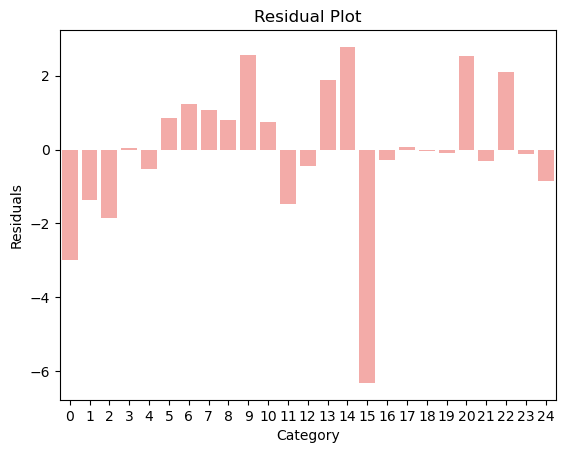

In [129]:
# Visualizing Predictions
def visualizePred(pred, test):
    pred = np.sum(pred, axis=0)
    test = np.sum(y_test, axis=0)
    index = list(range(len(pred)))

    # Creating Residual Graph
    res = test - pred
    sns.barplot(x=index, y=res, color="r")
    plt.xlabel('Category')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')
    plt.show()

visualizePred(f, y_test)

# 3. Performing HyperParameter Tuning and Saving Model as Pickle File

In [90]:
f = model.predict(X_test)

7/7 [==============================] - 2s 221ms/step


# 4. Reconverting One-Hot Encoding Into Textual Response and Printing Percent Distribution

[1.4344159e-09, 1.45159635e-08, 1.7657506e-07, 1.0057532e-06, 1.5861581e-06, 1.4776056e-05, 1.6078171e-05, 0.00010399074, 0.00013708921, 0.00028470825, 0.00034625913, 0.0006597311, 0.00067974033, 0.00071615307, 0.0018505598, 0.002595988, 0.004062972, 0.004289361, 0.011567962, 0.02308934, 0.023845026, 0.06974229, 0.32247585, 0.68612564, 98.84738]


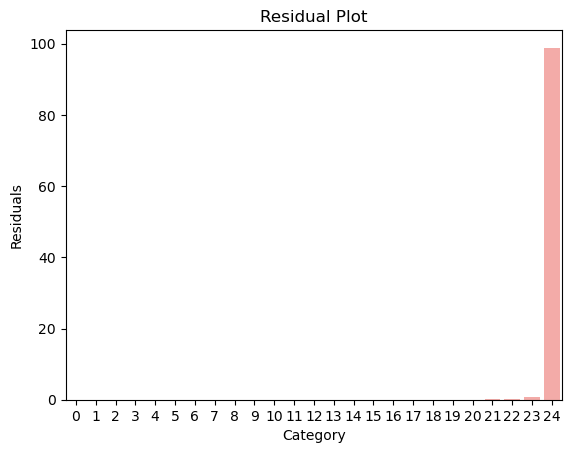

[0.0056236573, 0.007887363, 0.023062501, 0.0294877, 0.034545865, 0.046428237, 0.056163307, 0.06170462, 0.10462375, 0.12071476, 0.1605202, 0.18396325, 0.2845032, 0.33656216, 0.4382086, 0.43958566, 0.4527803, 0.73444664, 2.9763649, 3.2706187, 6.2288237, 6.6036744, 13.720759, 14.86689, 48.812054]


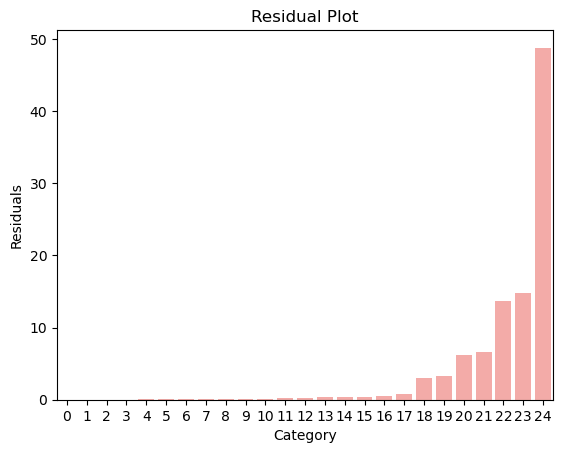

[0.00012296173, 0.0003872938, 0.0033661237, 0.005801316, 0.009786906, 0.010440507, 0.010478262, 0.028962657, 0.043214403, 0.05213527, 0.07621222, 0.07922765, 0.1951004, 0.3170436, 0.47151256, 0.5714778, 1.2323049, 1.4850003, 2.1171298, 2.1590354, 6.6276255, 12.853768, 13.660051, 24.417315, 33.5725]


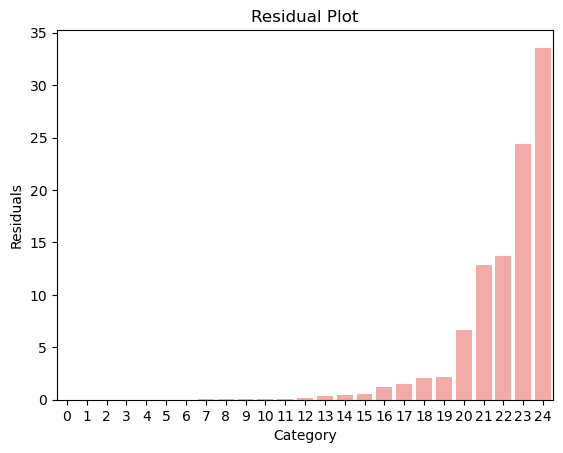

[1.9905187e-16, 1.5761392e-15, 9.154871e-15, 1.3289705e-14, 1.8363237e-13, 2.4478525e-12, 5.0606607e-12, 5.4886347e-12, 6.02604e-12, 9.170689e-11, 9.816931e-11, 3.6622527e-10, 2.152593e-08, 1.4191487e-07, 2.449476e-06, 4.7311705e-06, 5.048105e-06, 5.148446e-06, 5.6348663e-06, 5.9124686e-06, 4.173207e-05, 4.8736165e-05, 0.00073709345, 0.0010243322, 99.99813]


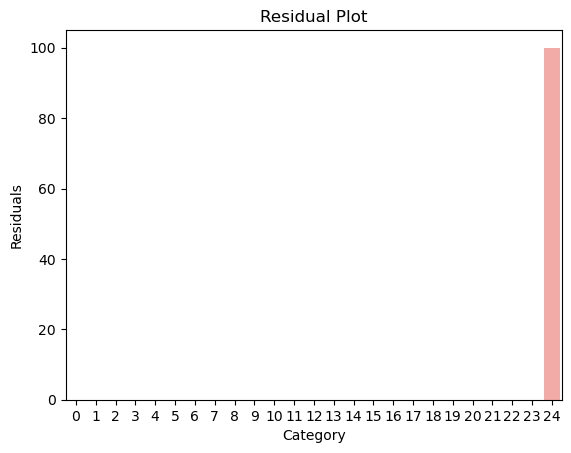

[1.0190015e-06, 3.3754527e-06, 1.3902336e-05, 4.406825e-05, 0.000111453075, 0.00013818986, 0.00062812143, 0.0016757349, 0.0054044244, 0.0067962282, 0.009441201, 0.013496168, 0.013943159, 0.038406897, 0.051313464, 0.07718337, 0.14211419, 0.4721996, 0.4736889, 1.0706645, 1.1114978, 3.0450892, 3.3887322, 9.147611, 80.9298]


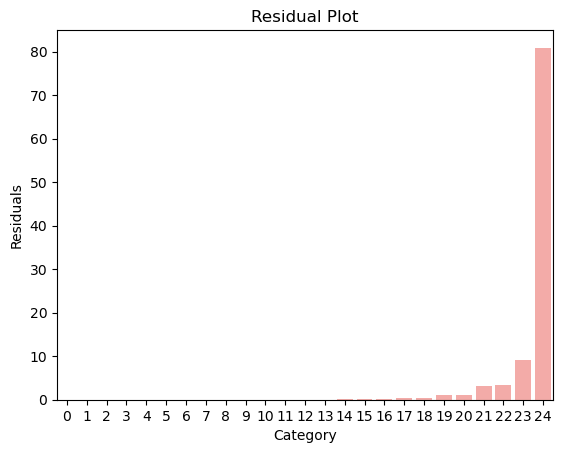

[0.0056236573, 0.007887363, 0.023062501, 0.0294877, 0.034545865, 0.046428237, 0.056163307, 0.06170462, 0.10462375, 0.12071476, 0.1605202, 0.18396325, 0.2845032, 0.33656216, 0.4382086, 0.43958566, 0.4527803, 0.73444664, 2.9763649, 3.2706187, 6.2288237, 6.6036744, 13.720759, 14.86689, 48.812054]


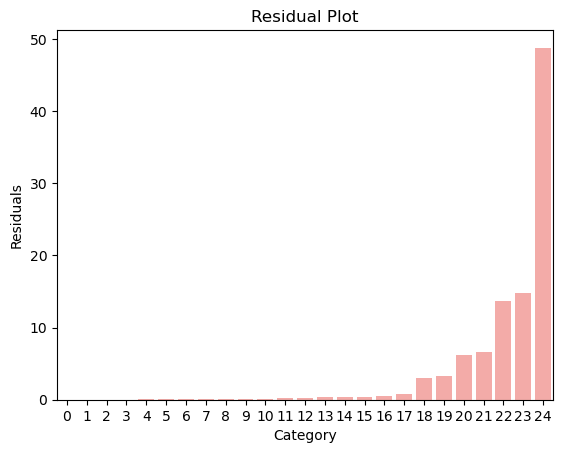

[0.0002648901, 0.0018607166, 0.0036493966, 0.011354429, 0.01335714, 0.017767861, 0.028510004, 0.038903426, 0.05720389, 0.070195764, 0.22622892, 0.24395332, 0.2635833, 0.4998101, 0.5447128, 0.5700006, 0.80625033, 0.89741135, 0.9467016, 1.2983543, 1.5862756, 2.0800114, 2.8459766, 5.187938, 81.759735]


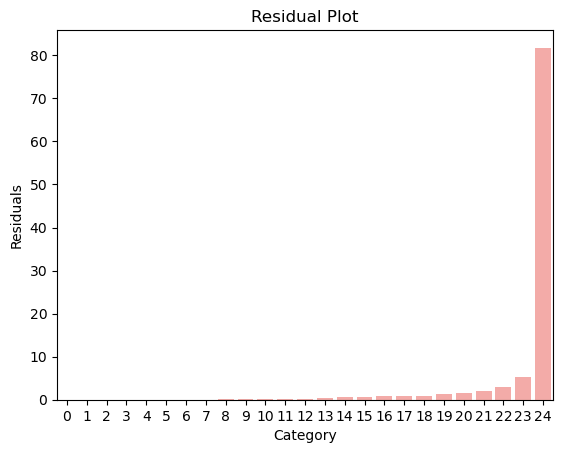

[0.0364556, 0.04934381, 0.05600026, 0.15410751, 0.25305167, 0.5069465, 0.97309315, 0.98152107, 1.1387329, 1.162261, 1.2747493, 1.2983677, 1.83704, 2.2648447, 2.6561582, 2.792238, 4.5767126, 4.8773866, 6.307467, 6.9316006, 7.441964, 7.812402, 8.01198, 15.535142, 21.07043]


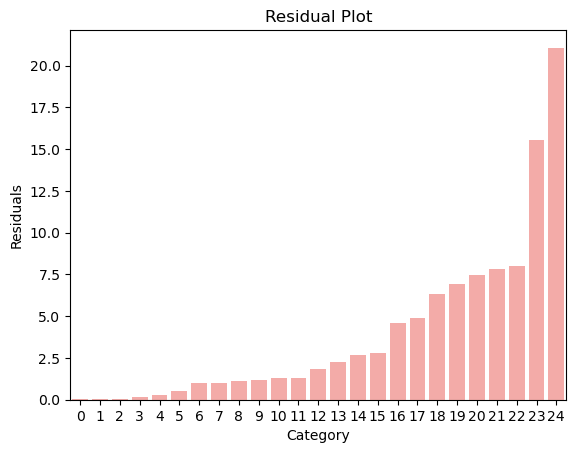

[6.807868e-07, 9.0650934e-07, 2.6114353e-06, 2.0101941e-05, 2.1954753e-05, 0.00010418159, 0.00013340922, 0.00016923732, 0.0002767915, 0.00039455877, 0.00046403744, 0.000916691, 0.0009824628, 0.001030973, 0.0025847051, 0.003011033, 0.005552718, 0.008290175, 0.009320858, 0.012938262, 0.035787128, 0.0588449, 0.06796319, 0.112014905, 99.67917]


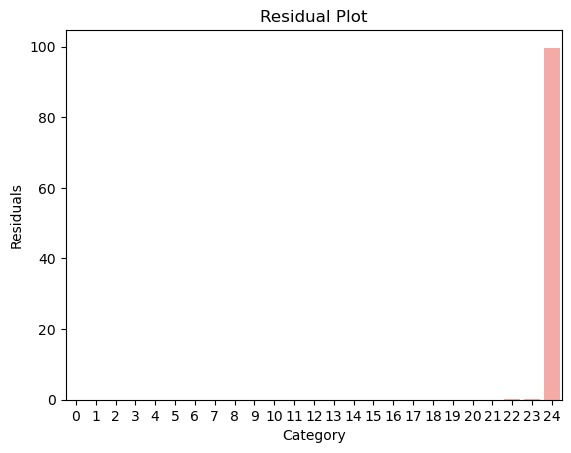

[4.434679e-12, 5.852641e-11, 8.74497e-09, 2.3808639e-08, 1.0847072e-07, 1.5453362e-07, 1.5576734e-07, 3.8524263e-07, 4.793846e-07, 9.841307e-07, 2.773546e-06, 3.23795e-06, 4.31795e-05, 6.273923e-05, 0.00011013756, 0.00021474103, 0.00034806045, 0.0007154608, 0.0014713717, 0.10303963, 0.12137463, 0.21197405, 1.6761867, 2.5428712, 95.34158]


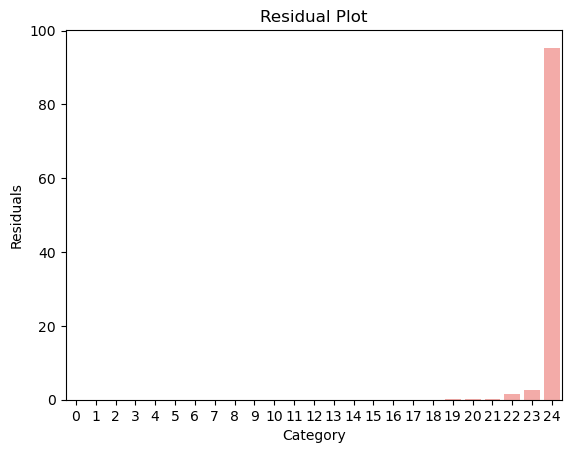

[6.2129926e-05, 0.00027994314, 0.00039200234, 0.0034132234, 0.003413702, 0.014361931, 0.020694852, 0.028264938, 0.0307771, 0.047550317, 0.08094585, 0.09013764, 0.13624538, 0.21649595, 0.2563086, 0.38331828, 0.4509855, 1.1167507, 1.2475458, 1.2758396, 1.5571882, 4.114194, 7.7969804, 10.012745, 71.1151]


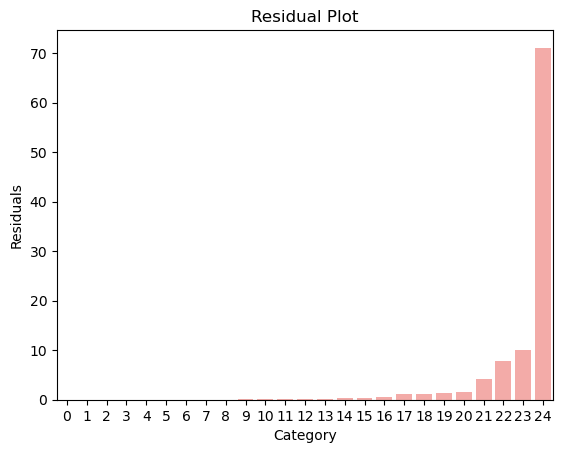

[6.309153e-05, 0.00013959743, 0.0017268942, 0.0030593718, 0.006753968, 0.013633909, 0.01709808, 0.026122205, 0.031037679, 0.06726066, 0.08110959, 0.08990309, 0.16826797, 0.21259594, 0.293607, 0.34029335, 0.45687723, 0.45821047, 0.60336095, 1.7877731, 2.7092562, 3.0045621, 4.526254, 5.62776, 79.47328]


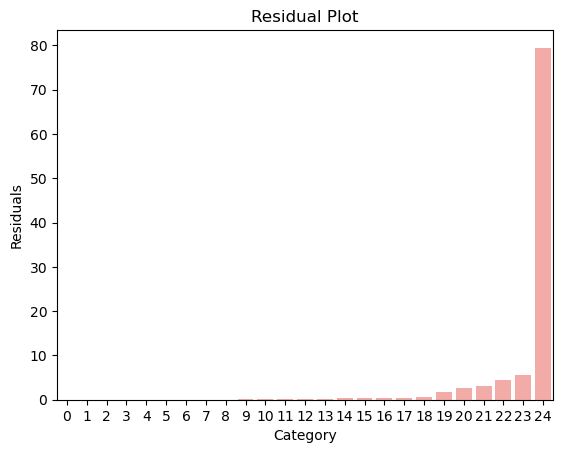

[8.220755e-06, 3.1764353e-05, 0.00015453709, 0.00016588786, 0.00035209142, 0.0005933301, 0.0010761336, 0.0019446199, 0.0057029566, 0.006502467, 0.0070817587, 0.011227469, 0.028408112, 0.034137215, 0.036145307, 0.05489595, 0.07780542, 0.08808017, 0.09068857, 0.15763077, 0.2947414, 0.40449664, 1.1169362, 1.5992751, 95.98191]


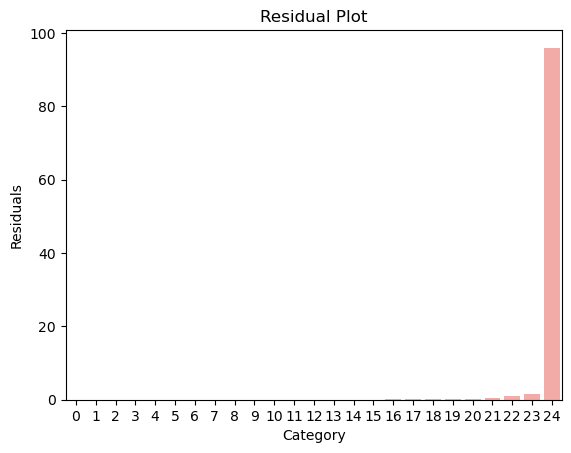

[2.8193866e-05, 0.00020751545, 0.0006718527, 0.0011222503, 0.002006063, 0.004094597, 0.0041393326, 0.0042626886, 0.010325948, 0.014374053, 0.01971978, 0.020459304, 0.028838487, 0.030334169, 0.060774397, 0.13782941, 0.313749, 0.3256396, 0.51420194, 0.6094652, 1.4017919, 1.5476433, 2.25706, 5.187337, 87.50391]


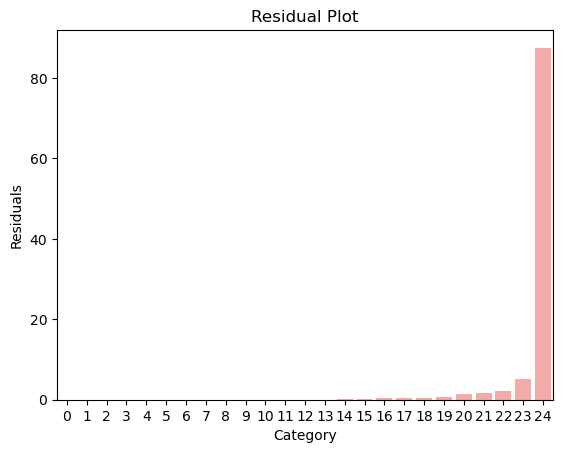

[2.632308e-13, 4.413858e-12, 1.1345465e-11, 4.0918043e-11, 4.4226924e-11, 5.2228274e-11, 9.591566e-11, 9.984652e-11, 3.568624e-10, 2.1535147e-09, 4.184102e-08, 7.0481896e-08, 2.7174306e-06, 1.0199256e-05, 1.6225305e-05, 8.487688e-05, 0.000109986024, 0.0001258197, 0.0031043612, 0.003857266, 0.00454853, 0.01001017, 0.015787605, 0.31040683, 99.65193]


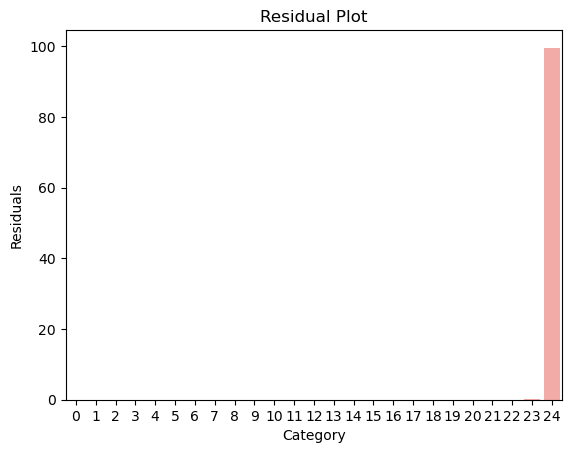

[6.3118114e-20, 1.4861218e-16, 1.4236998e-15, 5.8772384e-14, 5.324716e-13, 5.8382037e-13, 1.2414906e-12, 1.8374202e-12, 5.901328e-12, 1.213873e-11, 2.0338904e-11, 2.1758286e-11, 4.705633e-11, 5.2768484e-11, 6.3644874e-11, 2.3005331e-10, 2.4062935e-10, 5.778335e-10, 1.6681654e-09, 1.07528795e-08, 5.9678754e-08, 5.203161e-07, 2.687278e-06, 7.839546e-06, 99.999985]


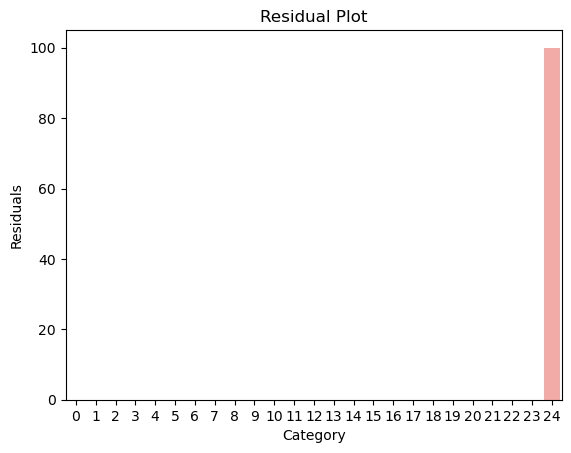

[4.3281803e-13, 2.2696088e-12, 4.168999e-12, 4.0616017e-09, 4.288532e-09, 9.883392e-09, 2.476731e-08, 1.9769257e-07, 3.3166492e-07, 9.478326e-07, 1.919124e-06, 3.775494e-06, 3.854522e-06, 7.5016956e-06, 1.080477e-05, 1.35420505e-05, 6.9460875e-05, 7.4143376e-05, 0.00014345981, 0.0001499747, 0.0002657028, 0.0005326022, 0.00075353746, 0.0023226666, 99.995636]


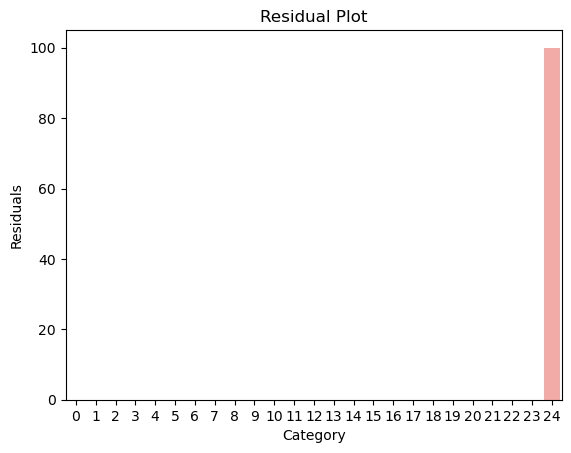

[4.428533e-10, 2.4241853e-09, 4.062551e-09, 6.7431736e-09, 8.614424e-09, 4.1963112e-08, 6.473221e-08, 8.123545e-08, 1.258276e-07, 1.3154666e-07, 1.3669037e-07, 8.3844236e-07, 1.0159134e-06, 1.8726902e-05, 2.1344169e-05, 2.88412e-05, 5.3463806e-05, 6.473922e-05, 7.318864e-05, 0.00019477423, 0.00024239557, 0.000381096, 0.00041186583, 0.0031632397, 99.99535]


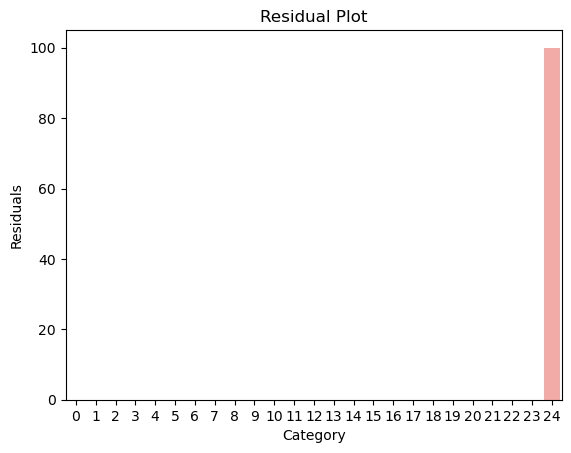

[4.428533e-10, 2.4241853e-09, 4.062551e-09, 6.7431736e-09, 8.614424e-09, 4.1963112e-08, 6.473221e-08, 8.123545e-08, 1.258276e-07, 1.3154666e-07, 1.3669037e-07, 8.3844236e-07, 1.0159134e-06, 1.8726902e-05, 2.1344169e-05, 2.88412e-05, 5.3463806e-05, 6.473922e-05, 7.318864e-05, 0.00019477423, 0.00024239557, 0.000381096, 0.00041186583, 0.0031632397, 99.99535]


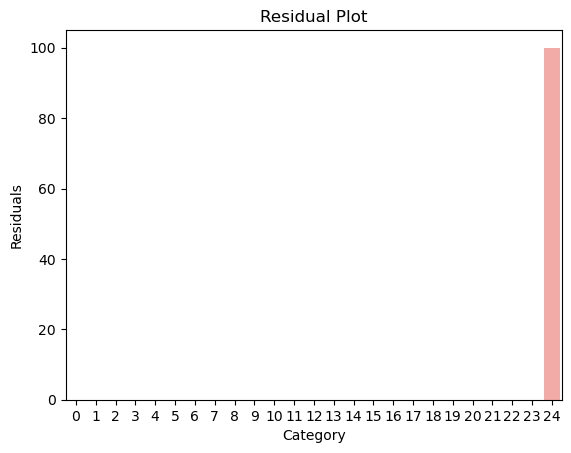

[8.3316953e-10, 4.1332342e-08, 3.3616964e-06, 1.1714823e-05, 2.1664408e-05, 8.667375e-05, 0.0003630004, 0.000491125, 0.0007907507, 0.003184474, 0.0048532523, 0.0050530904, 0.005574176, 0.009792337, 0.0124458615, 0.01391972, 0.01710717, 0.03514568, 0.09511433, 0.64746606, 0.72831917, 0.7546601, 2.042143, 38.706223, 56.917225]


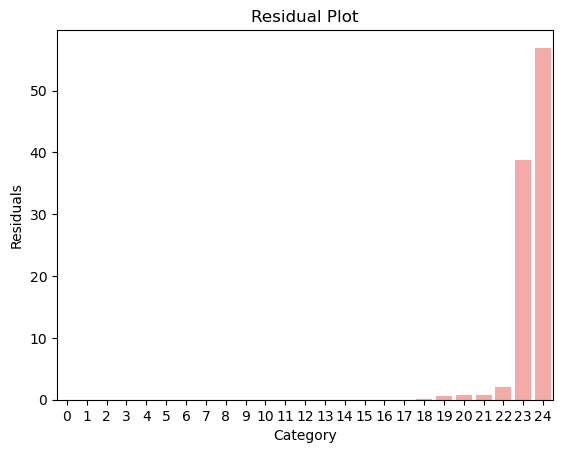

[0.03080983, 0.039450046, 0.053451832, 0.054072, 0.07886443, 0.08478155, 0.09035834, 0.09733174, 0.13536313, 0.1530633, 0.20708139, 0.2331774, 0.25438786, 0.27394247, 0.49343655, 0.54213566, 0.5456128, 0.5709544, 0.7101885, 1.3377311, 1.6401387, 1.8041087, 11.243276, 17.322626, 62.003647]


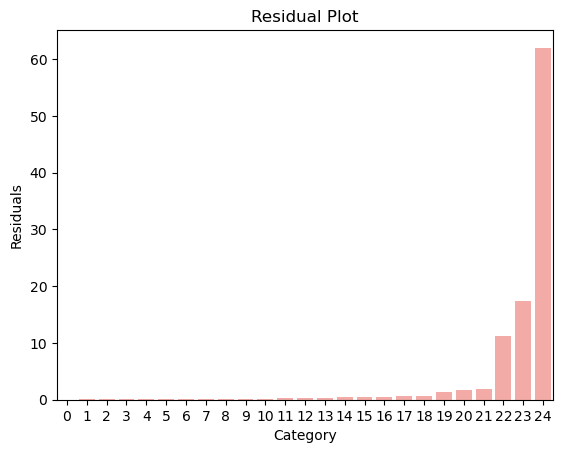

[5.622763e-09, 8.7243876e-08, 2.4083752e-07, 9.191033e-06, 3.8422142e-05, 0.00010274546, 0.00024620994, 0.00027468745, 0.0015413883, 0.0015473459, 0.0021005445, 0.0021109066, 0.0030204197, 0.003281735, 0.0058345846, 0.0062634344, 0.010649951, 0.013175968, 0.020940673, 0.022495968, 0.030080918, 0.0606921, 0.16098578, 0.18409568, 99.47051]


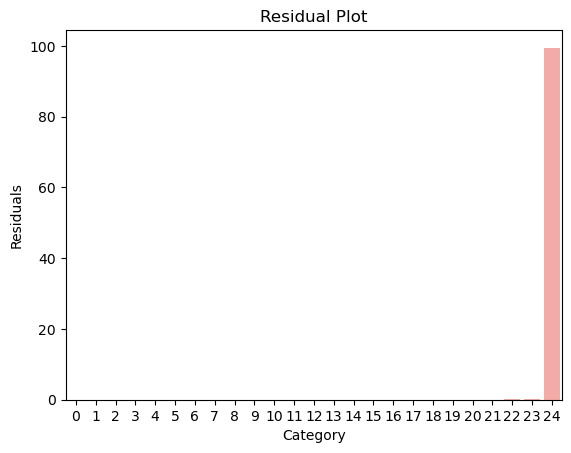

[2.3795332e-09, 2.950587e-08, 5.432172e-07, 1.8737615e-05, 2.516027e-05, 5.208638e-05, 6.4052125e-05, 0.00010067284, 0.00041455636, 0.00042844412, 0.00067019195, 0.00069012155, 0.00073812786, 0.0019301464, 0.0021953532, 0.004078396, 0.0045956513, 0.008228096, 0.016741624, 0.020391786, 0.027698042, 0.048870657, 0.6562585, 7.9951406, 91.21068]


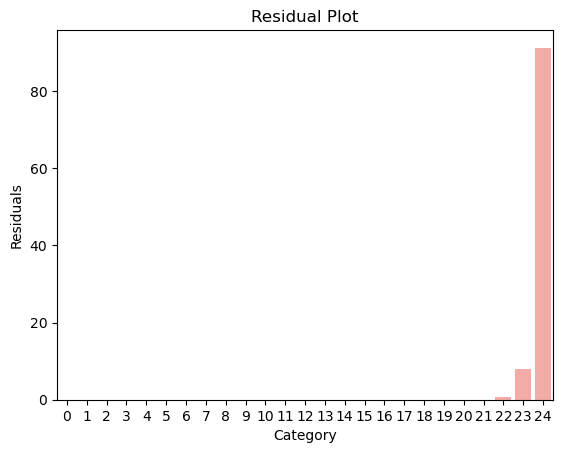

[0.0049609025, 0.045358848, 0.091807835, 0.09479758, 0.10509951, 0.24470243, 0.35835034, 0.38621515, 0.392811, 0.60353947, 0.7094234, 0.71501005, 0.8473837, 0.89212114, 0.94833887, 3.1747355, 3.397454, 4.2611976, 4.420019, 4.764297, 5.2037673, 7.44531, 11.011079, 15.540175, 34.34204]


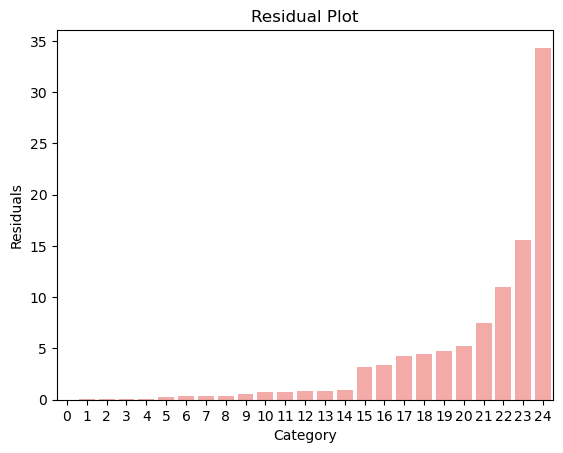

[5.8797184e-10, 5.613188e-09, 6.786044e-08, 7.037699e-08, 9.0525293e-07, 1.3439256e-06, 7.5556727e-06, 7.5579073e-06, 2.1587464e-05, 6.0915885e-05, 9.0000634e-05, 9.6514326e-05, 0.000100852376, 0.00011576396, 0.000685713, 0.00081445504, 0.006105827, 0.007939651, 0.009456475, 0.011693816, 0.028434014, 0.042672623, 0.068425305, 0.31642047, 99.50684]


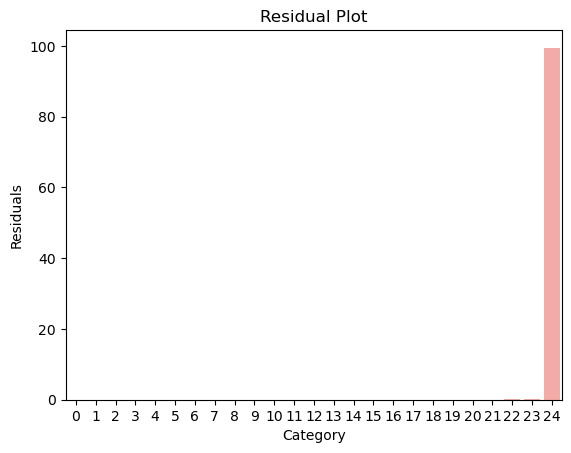

[0.0008994909, 0.0009258567, 0.006533656, 0.00657358, 0.018528616, 0.019844173, 0.049561396, 0.057330843, 0.12447364, 0.1358613, 0.14307371, 0.15214103, 0.16937448, 0.17646389, 0.23048937, 0.23407987, 0.30424494, 0.71843386, 0.83199704, 1.0316098, 1.0621133, 1.0627621, 1.3915083, 17.63046, 74.44071]


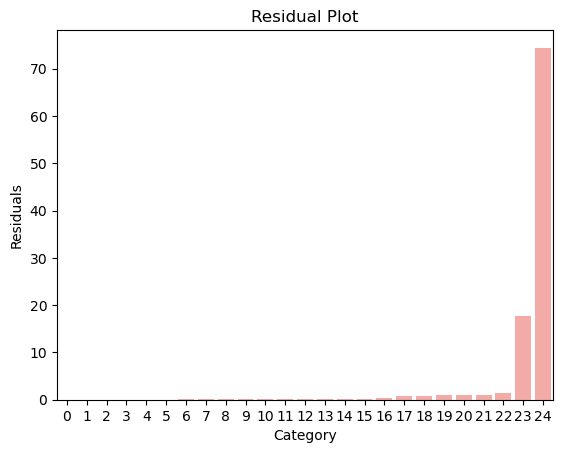

[2.0477477e-15, 7.188116e-13, 5.4267064e-12, 5.8537957e-12, 8.184332e-11, 1.8330617e-09, 5.45594e-09, 1.6868809e-08, 1.7716301e-08, 9.944629e-07, 1.8446283e-06, 3.548832e-06, 3.777971e-06, 5.2761984e-06, 9.355082e-06, 9.4540255e-06, 1.2533654e-05, 3.5774352e-05, 4.1671647e-05, 6.596239e-05, 0.00011844188, 0.00013660858, 0.00044161337, 0.24620531, 99.75292]


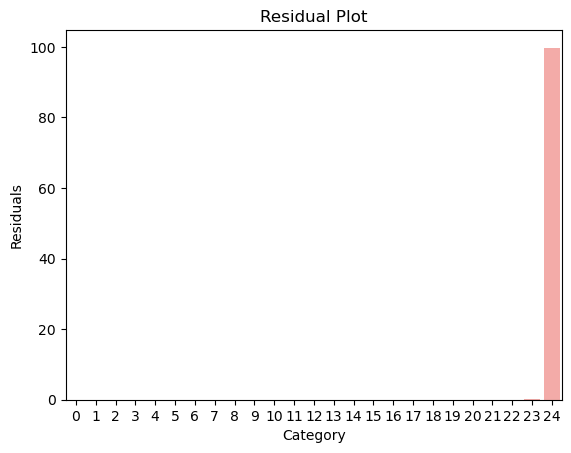

[4.428533e-10, 2.4241853e-09, 4.062551e-09, 6.7431736e-09, 8.614424e-09, 4.1963112e-08, 6.473221e-08, 8.123545e-08, 1.258276e-07, 1.3154666e-07, 1.3669037e-07, 8.3844236e-07, 1.0159134e-06, 1.8726902e-05, 2.1344169e-05, 2.88412e-05, 5.3463806e-05, 6.473922e-05, 7.318864e-05, 0.00019477423, 0.00024239557, 0.000381096, 0.00041186583, 0.0031632397, 99.99535]


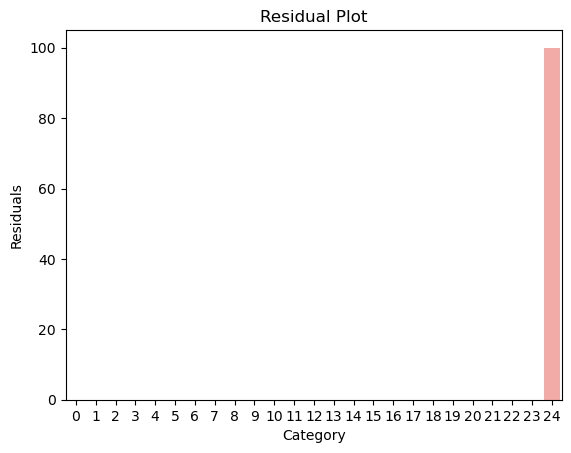

[3.3313572e-05, 5.2848776e-05, 0.00029559218, 0.00030924781, 0.0003234726, 0.00049306045, 0.00073710154, 0.0017659919, 0.014267904, 0.022527413, 0.025805376, 0.027933257, 0.05764656, 0.060363892, 0.07493511, 0.13400632, 0.13924019, 0.195538, 0.19777869, 0.27280915, 0.42219433, 0.44860625, 0.58684534, 1.0000646, 96.315445]


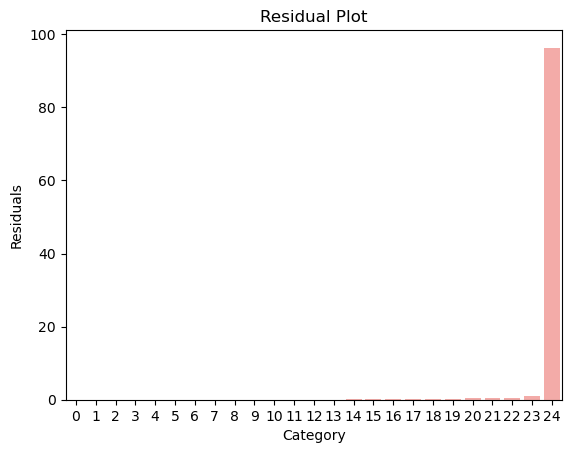

[1.2703894e-14, 9.215155e-13, 6.63532e-11, 1.7062386e-10, 4.502497e-10, 5.717729e-09, 7.4392976e-09, 1.580678e-07, 3.6834538e-07, 3.9427567e-07, 7.034451e-07, 1.68891e-06, 1.8948801e-06, 2.2929144e-06, 5.3147583e-06, 8.602125e-06, 4.8897386e-05, 5.6030985e-05, 0.0004944049, 0.00067509897, 0.0077865473, 0.009206848, 2.2106376, 3.2216992, 94.54938]


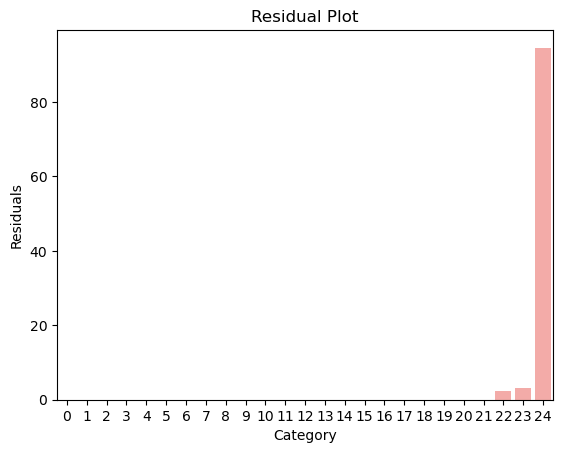

[0.08692332, 0.13064773, 0.1748666, 0.24356055, 0.36108035, 0.3972797, 0.43279278, 0.5846928, 0.80355173, 0.8521692, 0.988477, 1.091787, 1.4329258, 2.2504315, 2.5451481, 2.9609964, 3.0739849, 5.493189, 7.182338, 8.387207, 10.045381, 10.871003, 12.44329, 13.272935, 13.893348]


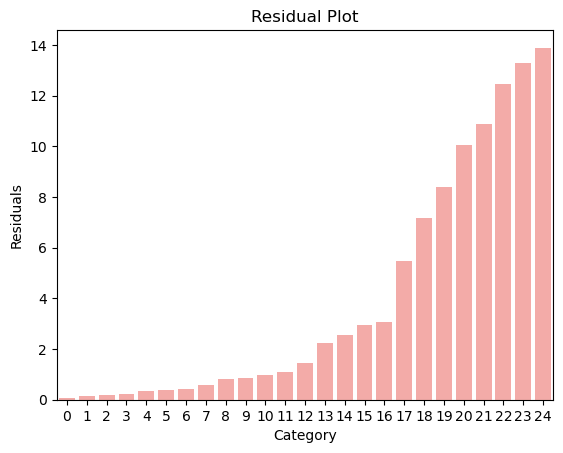

[0.0, 2.6902324e-36, 1.1502119e-35, 3.7096486e-33, 4.1878838e-32, 4.3952983e-32, 7.847731e-32, 9.945318e-32, 1.2855868e-31, 3.630886e-31, 1.5913457e-29, 2.7785527e-29, 6.421459e-29, 2.8477135e-28, 1.9563775e-25, 1.7913548e-23, 2.785077e-23, 5.790489e-23, 7.2372346e-23, 4.1030986e-22, 6.378197e-22, 1.2390485e-21, 8.839291e-21, 5.4208736e-15, 100.0]


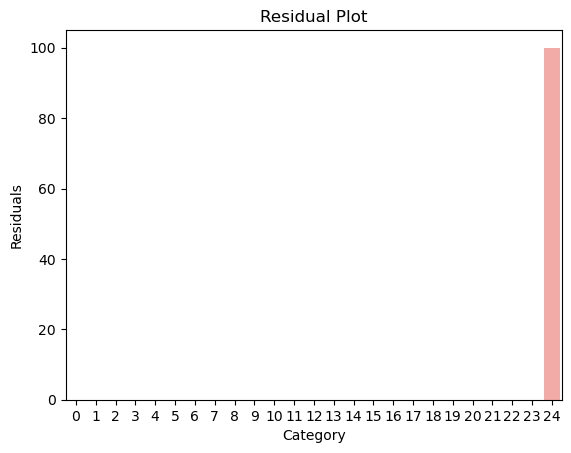

[5.1388815e-06, 2.2444472e-05, 4.726863e-05, 0.00012991481, 0.00028926236, 0.00031916169, 0.0007984809, 0.0017536727, 0.0021385052, 0.0058353553, 0.010059212, 0.018663416, 0.025322692, 0.030670485, 0.070318714, 0.071355306, 0.07825838, 0.14454012, 0.2928174, 1.1262245, 1.2572932, 1.6199787, 1.8711053, 2.6098263, 90.76223]


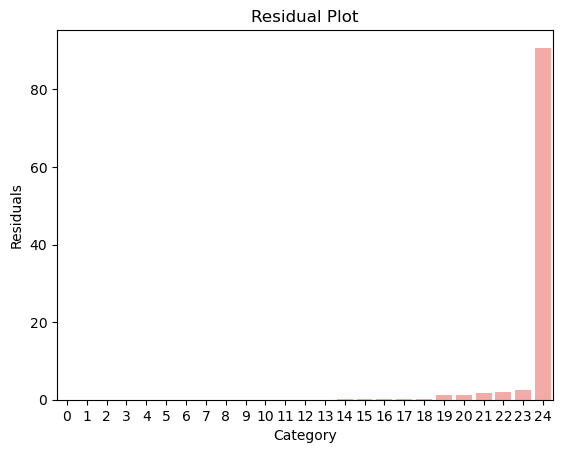

[3.083393e-08, 3.1713167e-08, 5.029847e-08, 7.9368526e-08, 1.2300109e-07, 2.3129311e-07, 3.864266e-07, 1.7215287e-06, 2.6048729e-06, 2.0080246e-05, 2.05313e-05, 4.3442094e-05, 0.00045655476, 0.00061673665, 0.0007212184, 0.0010976845, 0.001738709, 0.002258411, 0.0053032567, 0.0053339587, 0.0062606274, 0.02411309, 0.061674375, 0.42410195, 99.46623]


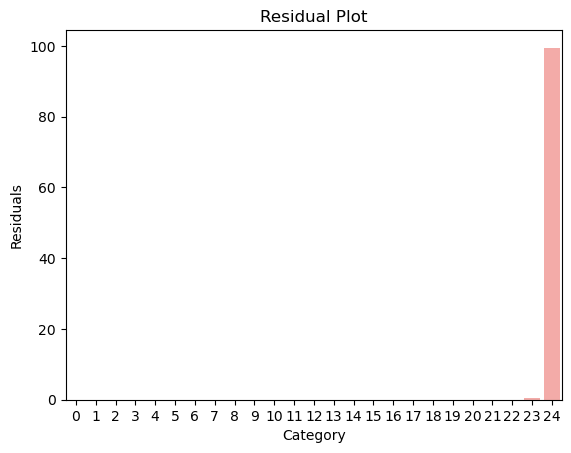

[3.9681294e-05, 5.5819946e-05, 0.00028210704, 0.00049963174, 0.00058784155, 0.0017304455, 0.0035301861, 0.0051995637, 0.0062006703, 0.011678285, 0.013081954, 0.01780405, 0.020618342, 0.03224392, 0.03344799, 0.044655982, 0.12341541, 0.18043174, 0.29153064, 0.3445609, 0.40409067, 0.43643144, 0.60457003, 1.4028451, 96.02047]


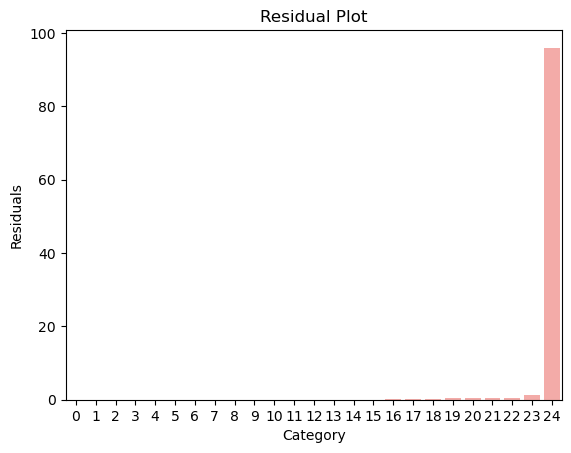

[6.2265156e-07, 1.7699276e-05, 2.9741628e-05, 0.00018388133, 0.00034162658, 0.0005045198, 0.00053890917, 0.00088723074, 0.0015125212, 0.0016880428, 0.0017693033, 0.0021232653, 0.0022936591, 0.0027504019, 0.0040820125, 0.008682851, 0.010324129, 0.013691043, 0.024856519, 0.036155403, 0.058035024, 0.13139735, 0.14285195, 0.22023399, 99.33506]


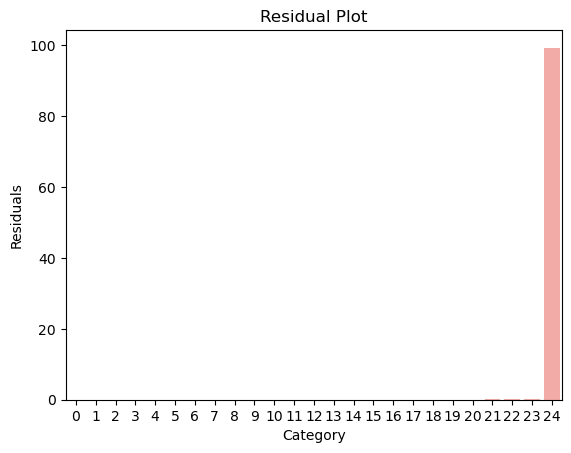

[4.3736528e-10, 7.183713e-10, 1.086108e-07, 1.1945843e-07, 1.7401798e-07, 3.5912782e-07, 4.119377e-07, 5.6623554e-07, 1.2794361e-06, 2.3626744e-06, 2.4774833e-06, 1.3741573e-05, 3.466099e-05, 8.679873e-05, 0.00013933654, 0.0004962479, 0.0010043315, 0.0013596071, 0.0014420768, 0.0014842082, 0.017002327, 0.019036077, 0.1598658, 0.16700664, 99.63102]


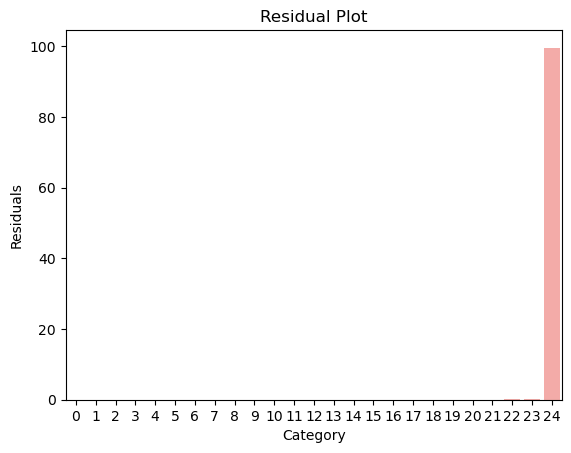

[1.4947979e-24, 2.9398552e-23, 1.0953764e-22, 1.1702777e-22, 3.5790183e-22, 1.2421768e-21, 3.1764654e-21, 2.3982354e-20, 3.2088507e-20, 1.4524528e-19, 1.7045273e-19, 2.689599e-19, 4.118535e-19, 2.9495677e-18, 5.362229e-18, 7.666052e-18, 1.9851332e-17, 3.311878e-17, 4.7876308e-14, 4.9763362e-14, 1.2203697e-13, 2.0420436e-13, 2.0625316e-13, 1.9823553e-10, 100.0]


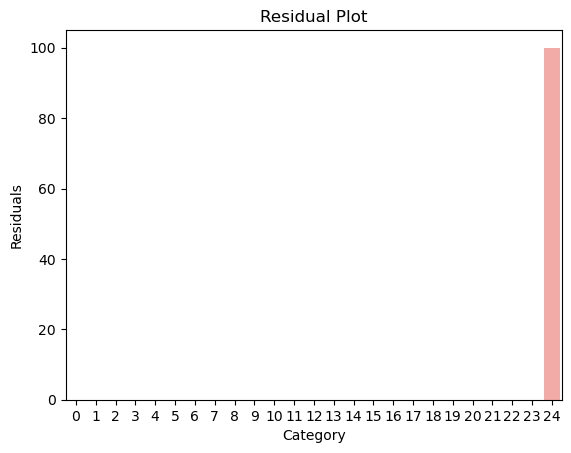

[1.1733046e-05, 6.985117e-05, 0.00034615415, 0.0010200199, 0.0017901636, 0.0025201426, 0.0027510142, 0.004763741, 0.0048893252, 0.0068466235, 0.034811314, 0.044264466, 0.044810224, 0.10316624, 0.13113238, 0.45019126, 0.53120065, 0.76050323, 2.1308787, 2.1939538, 2.227902, 2.9112926, 2.9790304, 25.602283, 59.829563]


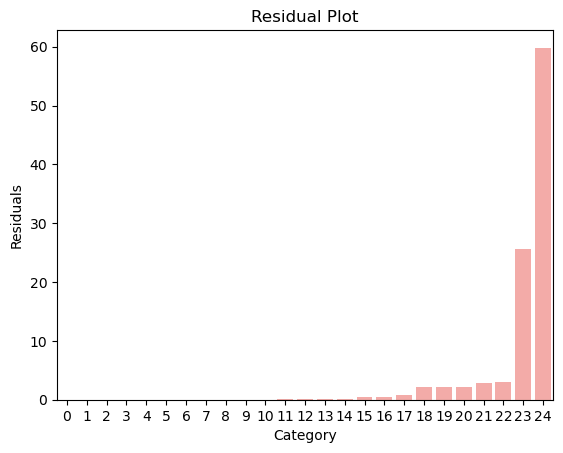

[5.4439874e-06, 4.181347e-05, 6.5490385e-05, 0.0005136883, 0.0016102031, 0.0020932504, 0.006129787, 0.018243078, 0.041403122, 0.048062872, 0.08854737, 0.14623643, 0.3092062, 0.41968986, 0.43609655, 0.45278612, 0.8552793, 2.1322815, 2.536701, 3.1590827, 4.3018823, 4.323372, 4.8863773, 26.641188, 49.193104]


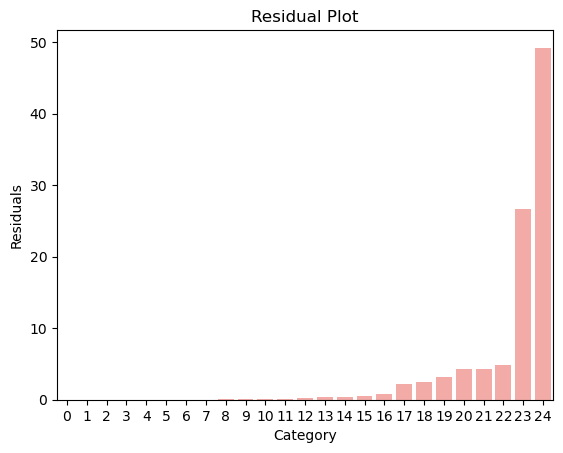

[6.42159e-05, 0.00028823546, 0.0012657685, 0.00334121, 0.0039044116, 0.013643731, 0.01958903, 0.035853695, 0.043972373, 0.0600993, 0.06763673, 0.0894896, 0.096732445, 0.13452485, 0.14616363, 0.1593781, 0.17864376, 0.5352341, 0.87319964, 0.8800985, 1.108306, 1.3490119, 4.039774, 24.238718, 65.92106]


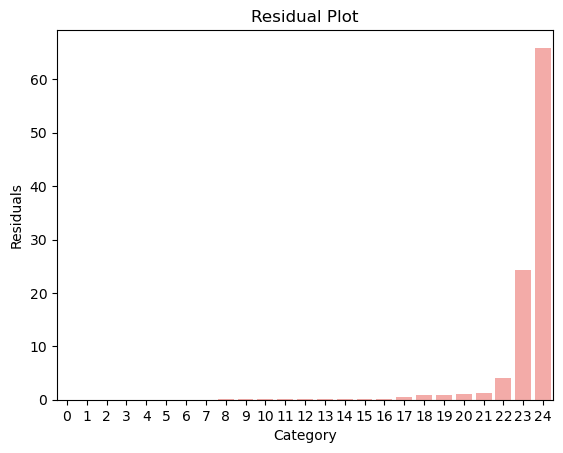

[2.511181e-12, 1.6844942e-11, 8.032267e-09, 3.6724508e-08, 1.357638e-07, 2.4448243e-06, 5.5887917e-06, 7.728636e-06, 2.1219712e-05, 2.5553107e-05, 7.999953e-05, 9.0175905e-05, 0.00012819881, 0.00014193998, 0.0002622764, 0.00029042785, 0.0004397571, 0.0009039871, 0.0057825525, 0.007680439, 0.024532562, 0.033931732, 0.05632607, 0.93713814, 98.932205]


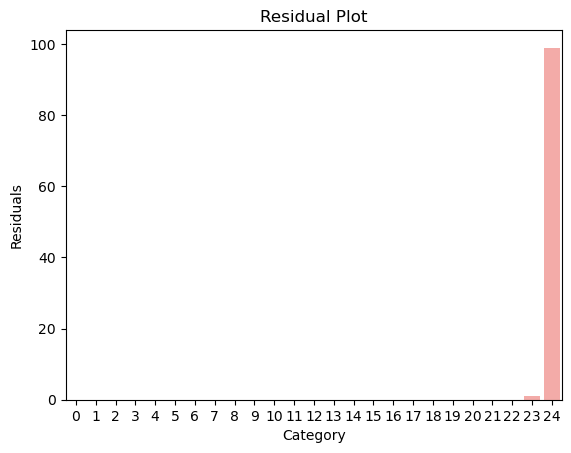

[0.0364556, 0.04934381, 0.05600026, 0.15410751, 0.25305167, 0.5069465, 0.97309315, 0.98152107, 1.1387329, 1.162261, 1.2747493, 1.2983677, 1.83704, 2.2648447, 2.6561582, 2.792238, 4.5767126, 4.8773866, 6.307467, 6.9316006, 7.441964, 7.812402, 8.01198, 15.535142, 21.07043]


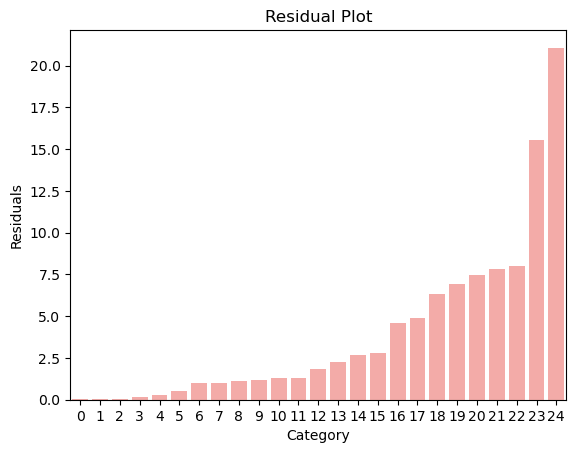

[4.428533e-10, 2.4241853e-09, 4.062551e-09, 6.7431736e-09, 8.614424e-09, 4.1963112e-08, 6.473221e-08, 8.123545e-08, 1.258276e-07, 1.3154666e-07, 1.3669037e-07, 8.3844236e-07, 1.0159134e-06, 1.8726902e-05, 2.1344169e-05, 2.88412e-05, 5.3463806e-05, 6.473922e-05, 7.318864e-05, 0.00019477423, 0.00024239557, 0.000381096, 0.00041186583, 0.0031632397, 99.99535]


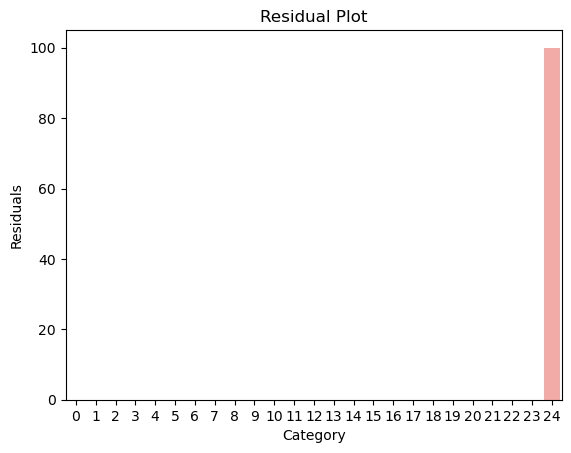

[1.6996886e-06, 2.920694e-06, 0.00010032373, 0.00042087722, 0.00063918054, 0.0009386999, 0.0011101759, 0.0014465345, 0.0017478782, 0.0022604323, 0.0076853344, 0.008009412, 0.013961219, 0.03151146, 0.0321282, 0.07562646, 0.09703353, 0.09749254, 0.10470885, 0.13076031, 0.26765332, 0.61114615, 0.92890096, 1.9499341, 95.63477]


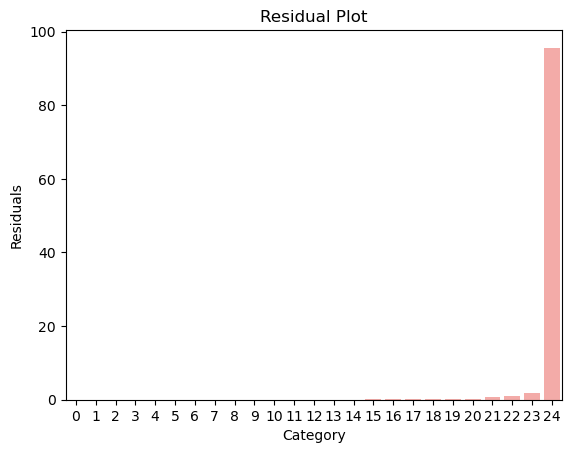

[2.8948332e-08, 4.6412733e-08, 2.0246009e-07, 1.3230491e-06, 3.062757e-06, 3.4653528e-06, 1.1954447e-05, 1.2029412e-05, 1.7118959e-05, 2.1888338e-05, 9.5844065e-05, 0.0009304398, 0.0012817937, 0.0064963875, 0.0073957113, 0.0109992605, 0.064888865, 0.075591445, 0.09332539, 0.09351725, 0.11636646, 0.17443779, 0.49491295, 1.0186677, 97.841034]


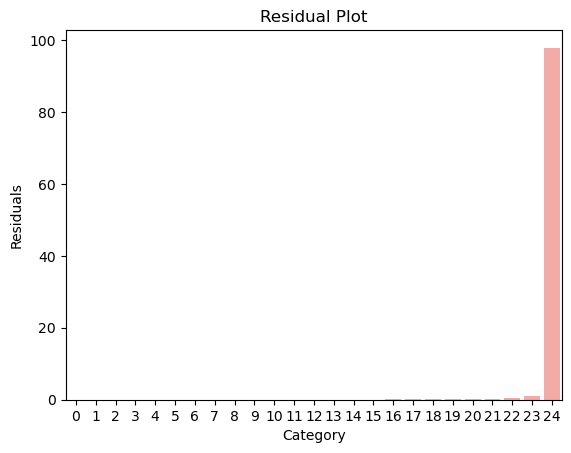

[1.2142156e-09, 1.6231396e-09, 4.155099e-09, 1.0291347e-08, 1.0305372e-08, 2.7220832e-08, 3.638564e-08, 2.0257e-07, 3.027804e-07, 7.690029e-07, 5.5800756e-06, 5.9367776e-06, 1.480055e-05, 3.4893677e-05, 4.8147165e-05, 0.00019482743, 0.00023334986, 0.00026041394, 0.00032921636, 0.00046409285, 0.00089352304, 0.007400495, 0.013170407, 0.58708286, 99.38986]


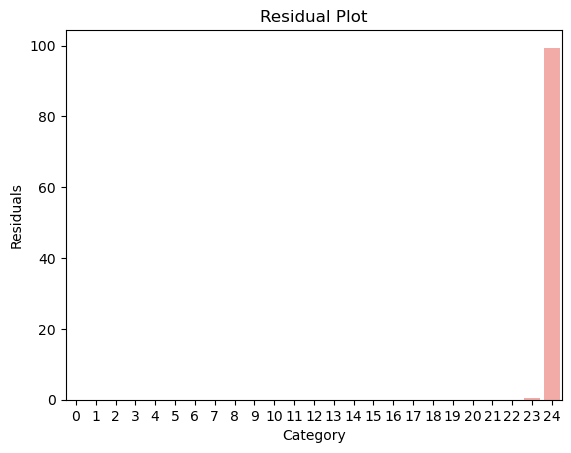

[3.7422637e-13, 5.747409e-12, 2.7650542e-11, 1.1740497e-10, 1.1775123e-10, 2.5079497e-10, 9.793051e-10, 8.1470235e-09, 8.179923e-09, 1.25733095e-08, 2.3332452e-08, 2.5241922e-08, 4.3380172e-08, 3.2999458e-07, 7.7064544e-07, 2.34066e-06, 5.734812e-06, 1.03025695e-05, 4.8340833e-05, 0.00032201092, 0.0007020813, 0.0011988714, 0.0014361343, 0.14151129, 99.85476]


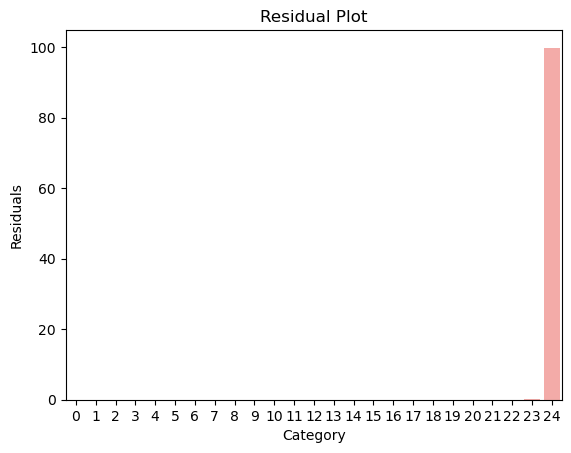

[8.2449425e-15, 3.0575772e-14, 6.8162186e-13, 4.933628e-12, 8.115028e-11, 4.4311768e-10, 5.263016e-10, 8.4639273e-10, 4.202292e-09, 7.1664e-09, 1.2995177e-08, 1.6278166e-08, 1.9895157e-07, 1.5719322e-06, 2.9071625e-06, 3.0706694e-06, 6.404404e-06, 7.756589e-06, 1.1146674e-05, 1.808794e-05, 1.8542312e-05, 8.712925e-05, 0.00010503021, 0.0240495, 99.975685]


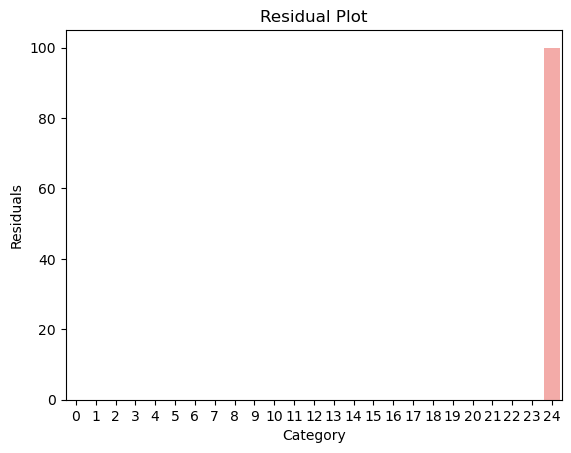

[0.0049609025, 0.045358848, 0.091807835, 0.09479758, 0.10509951, 0.24470243, 0.35835034, 0.38621515, 0.392811, 0.60353947, 0.7094234, 0.71501005, 0.8473837, 0.89212114, 0.94833887, 3.1747355, 3.397454, 4.2611976, 4.420019, 4.764297, 5.2037673, 7.44531, 11.011079, 15.540175, 34.34204]


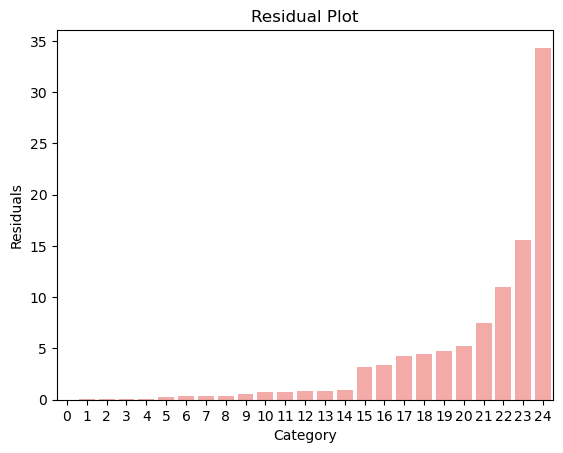

[0.005837958, 0.006235858, 0.009108752, 0.07511998, 0.083053, 0.19281988, 0.28130788, 0.35792312, 0.4851806, 0.53905594, 0.55683213, 0.97133917, 0.99200237, 1.0557892, 1.74069, 1.9980695, 2.0535848, 2.986774, 3.540231, 3.5774848, 5.4123125, 5.7093086, 12.026303, 12.067055, 43.27658]


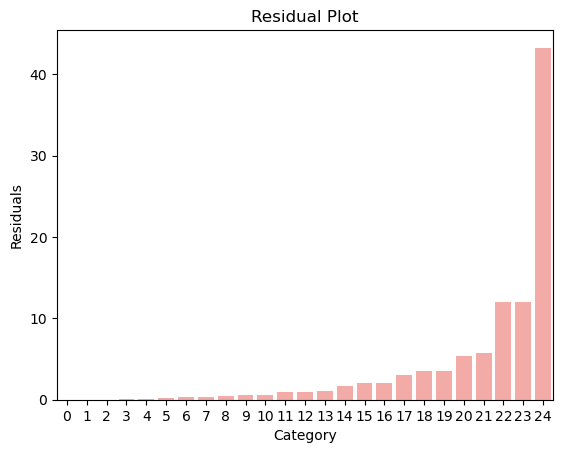

[4.7330136e-13, 2.0321997e-12, 7.9137347e-10, 4.3647086e-09, 5.7833587e-09, 6.964071e-09, 6.456462e-07, 1.3542524e-06, 4.8119223e-06, 2.9727738e-05, 3.3161603e-05, 4.291434e-05, 0.00014494604, 0.00019324987, 0.0002177816, 0.00040491365, 0.00046217546, 0.00067092973, 0.00079453393, 0.00082431606, 0.0010548705, 0.0018291776, 0.014865727, 0.034048796, 99.944374]


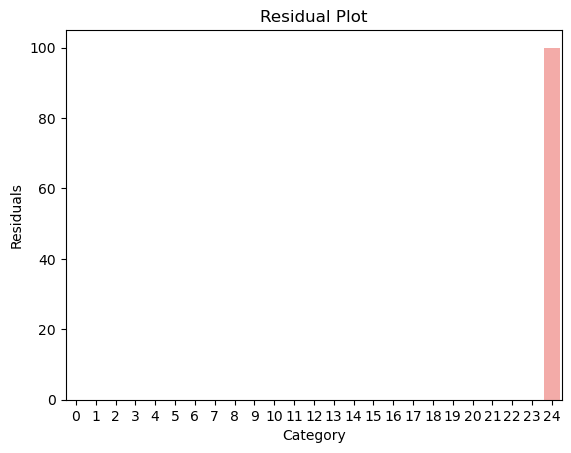

[7.373463e-05, 0.00022235968, 0.00035885442, 0.00048085468, 0.0023720425, 0.0041224654, 0.009678879, 0.017927678, 0.02522618, 0.02591151, 0.046275508, 0.06445565, 0.06590918, 0.10379135, 0.10937493, 0.13323526, 0.14696729, 0.37659377, 0.41550958, 0.5095464, 0.6017326, 0.88743323, 1.5329357, 1.80544, 93.11443]


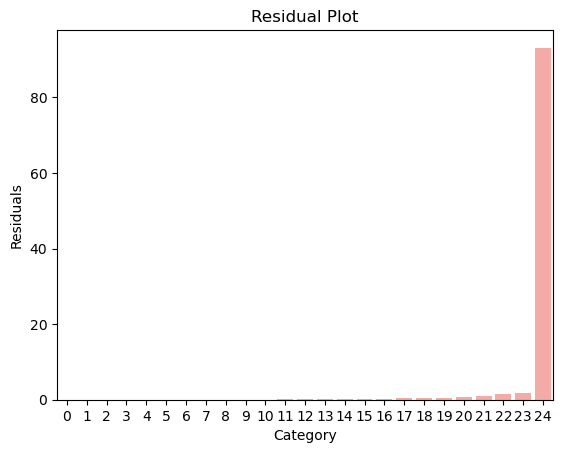

[1.0190015e-06, 3.3754527e-06, 1.3902336e-05, 4.406825e-05, 0.000111453075, 0.00013818986, 0.00062812143, 0.0016757349, 0.0054044244, 0.0067962282, 0.009441201, 0.013496168, 0.013943159, 0.038406897, 0.051313464, 0.07718337, 0.14211419, 0.4721996, 0.4736889, 1.0706645, 1.1114978, 3.0450892, 3.3887322, 9.147611, 80.9298]


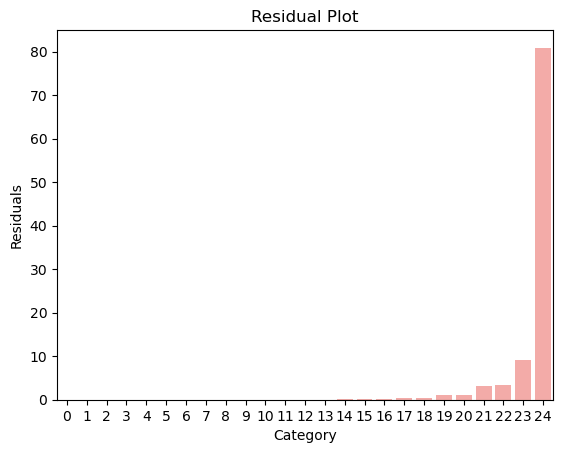

[6.360236e-08, 1.037172e-07, 1.5296115e-06, 2.4720037e-05, 7.0745555e-05, 0.00011328118, 0.00027424833, 0.0002972546, 0.0007276931, 0.00095559715, 0.0020299992, 0.004618585, 0.0050908374, 0.0073111304, 0.013547126, 0.0143369995, 0.014951148, 0.030508094, 0.034181017, 0.12696387, 0.16050562, 0.37726, 1.2900001, 41.485233, 56.430996]


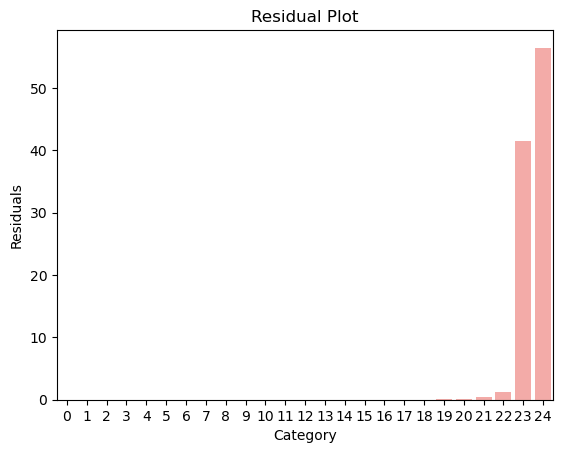

[0.0021559154, 0.0023290562, 0.020286284, 0.025696732, 0.029300796, 0.09020853, 0.11323817, 0.11625356, 0.13934831, 0.15321766, 0.15401654, 0.2540849, 0.4303803, 0.60088146, 0.7255939, 1.0138773, 1.1798704, 1.5735364, 1.6067643, 1.8797013, 3.387373, 3.5350013, 4.0559072, 6.0256286, 72.88536]


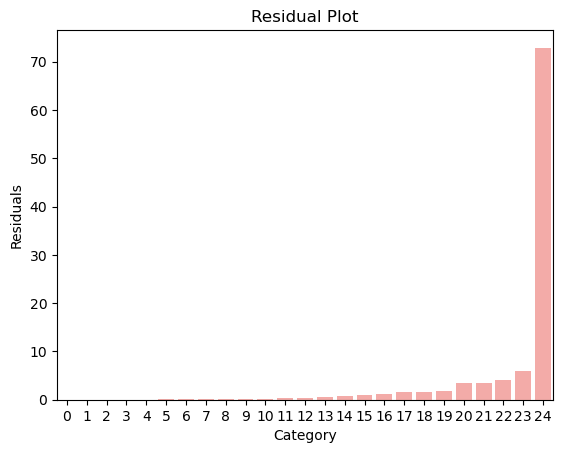

[1.2142156e-09, 1.6231396e-09, 4.155099e-09, 1.0291347e-08, 1.0305372e-08, 2.7220832e-08, 3.638564e-08, 2.0257e-07, 3.027804e-07, 7.690029e-07, 5.5800756e-06, 5.9367776e-06, 1.480055e-05, 3.4893677e-05, 4.8147165e-05, 0.00019482743, 0.00023334986, 0.00026041394, 0.00032921636, 0.00046409285, 0.00089352304, 0.007400495, 0.013170407, 0.58708286, 99.38986]


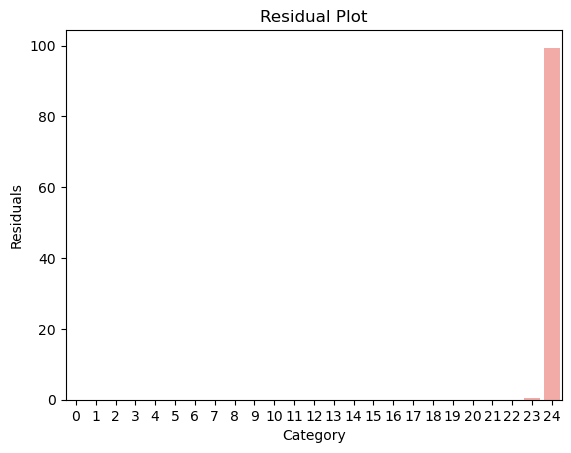

[1.5466838e-17, 6.961864e-16, 3.2737352e-14, 2.2683003e-13, 3.4054417e-12, 4.9259503e-12, 1.3917477e-10, 4.708141e-10, 5.5468263e-10, 7.488241e-10, 5.2216382e-09, 8.540564e-09, 2.4772312e-08, 4.7094844e-08, 1.0430487e-07, 1.2679958e-07, 2.6371657e-07, 5.2508694e-06, 5.4862735e-06, 5.721505e-06, 1.2505178e-05, 1.258001e-05, 2.8182441e-05, 0.00336612, 99.99657]


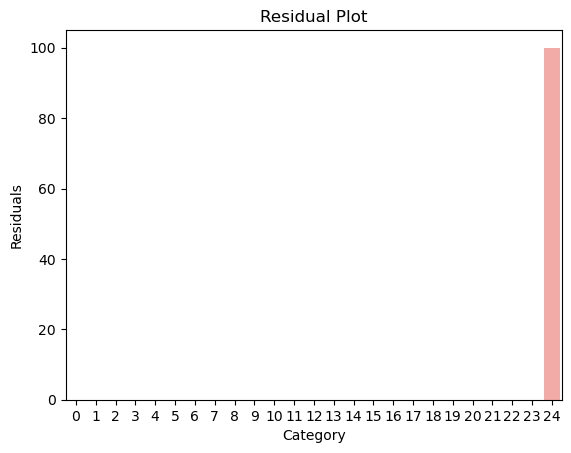

[3.3313572e-05, 5.2848776e-05, 0.00029559218, 0.00030924781, 0.0003234726, 0.00049306045, 0.00073710154, 0.0017659919, 0.014267904, 0.022527413, 0.025805376, 0.027933257, 0.05764656, 0.060363892, 0.07493511, 0.13400632, 0.13924019, 0.195538, 0.19777869, 0.27280915, 0.42219433, 0.44860625, 0.58684534, 1.0000646, 96.315445]


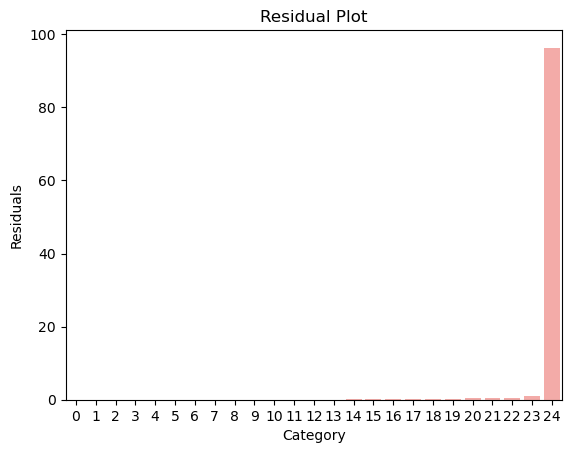

[0.0002678616, 0.0015260117, 0.0021100678, 0.002612433, 0.0034174281, 0.0051335045, 0.006036017, 0.007040545, 0.025351388, 0.033343513, 0.04815243, 0.10449622, 0.10978439, 0.12054618, 0.25412425, 0.6939511, 0.8878584, 1.1971798, 1.5691559, 1.8882562, 2.0949378, 2.1711695, 3.1710513, 4.2851295, 81.31736]


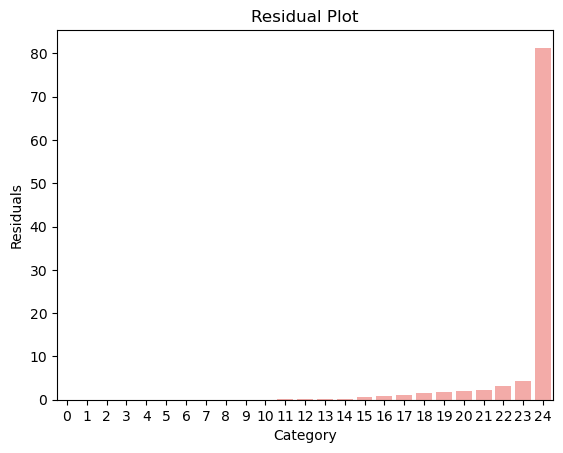

[2.055818e-13, 9.126784e-13, 7.672769e-12, 5.927894e-11, 1.2846608e-10, 2.327676e-10, 2.6072516e-10, 3.4575406e-10, 2.224689e-09, 1.3992247e-08, 3.4080067e-08, 2.2443263e-07, 3.1431514e-07, 1.4806706e-06, 4.9238106e-06, 1.025281e-05, 1.2034767e-05, 4.022994e-05, 9.773113e-05, 0.00030761777, 0.00039359325, 0.0005769066, 0.0022441125, 0.0041941497, 99.99211]


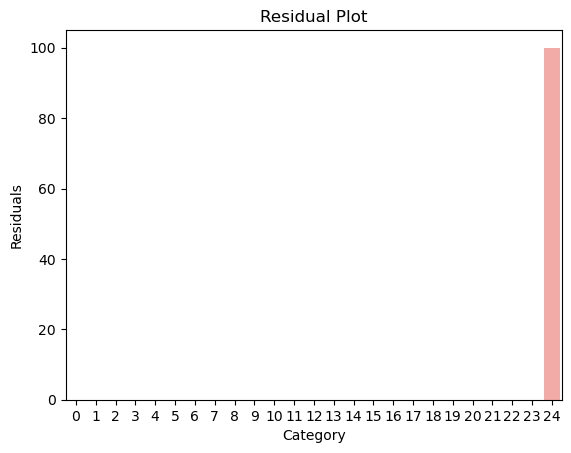

[3.3313572e-05, 5.2848776e-05, 0.00029559218, 0.00030924781, 0.0003234726, 0.00049306045, 0.00073710154, 0.0017659919, 0.014267904, 0.022527413, 0.025805376, 0.027933257, 0.05764656, 0.060363892, 0.07493511, 0.13400632, 0.13924019, 0.195538, 0.19777869, 0.27280915, 0.42219433, 0.44860625, 0.58684534, 1.0000646, 96.315445]


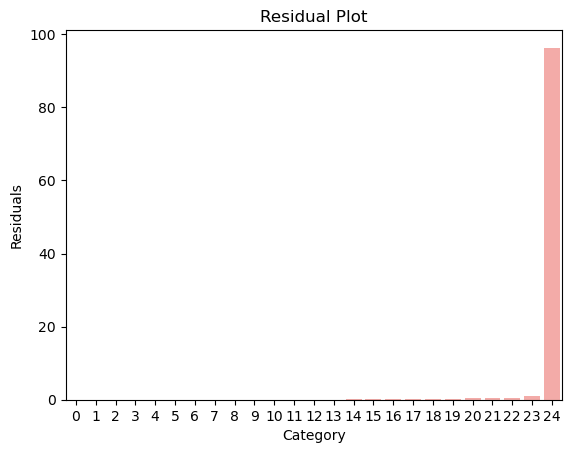

[6.467229e-05, 0.00056481035, 0.0010288212, 0.005496272, 0.021383042, 0.02407829, 0.024183922, 0.02671532, 0.120864786, 0.1433337, 0.2252151, 0.41094553, 0.5632675, 0.591604, 1.001913, 1.2541136, 1.5267844, 1.5755866, 3.4011827, 8.046636, 9.403653, 14.490068, 14.949596, 18.390062, 23.801664]


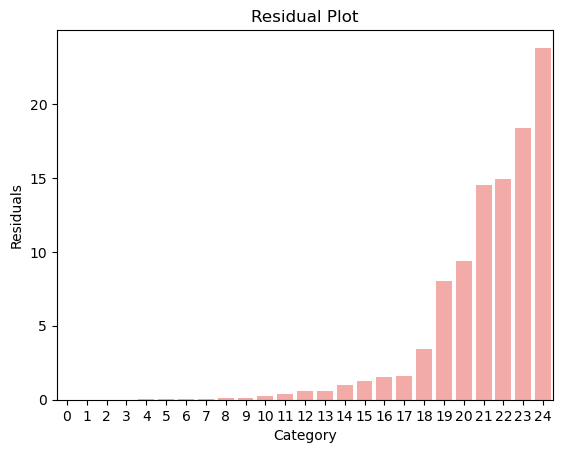

[0.00047670765, 0.0011261464, 0.0015384055, 0.0038652578, 0.005290921, 0.007252171, 0.008504594, 0.01424417, 0.017250758, 0.017741127, 0.024218254, 0.030252095, 0.043642666, 0.058668934, 0.064334795, 0.1582497, 0.17589162, 0.22627261, 0.24260706, 0.55502576, 0.57889116, 1.5823189, 19.101027, 19.413954, 57.667362]


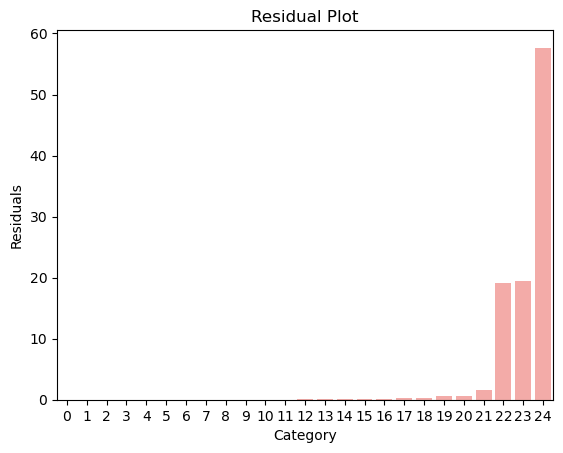

[1.6493794e-05, 5.836092e-05, 0.00037936235, 0.000823516, 0.0022895087, 0.004187623, 0.016427089, 0.023081953, 0.025881667, 0.028381081, 0.14627418, 0.22307807, 0.2593929, 0.2650041, 0.40673274, 0.47674835, 0.5592149, 0.8064783, 1.4577489, 1.6017787, 2.0321128, 2.5494723, 3.741404, 6.272544, 79.10049]


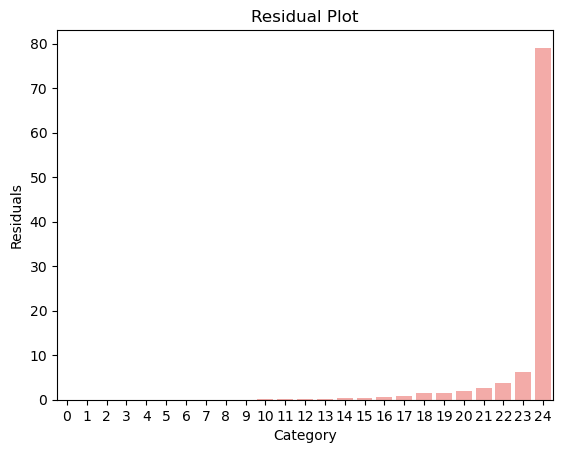

[8.385693e-07, 3.0378822e-05, 0.00021448568, 0.00025250498, 0.00030157604, 0.0003647985, 0.0005008633, 0.0010339374, 0.0012674241, 0.0013231967, 0.0016252534, 0.017853672, 0.030581996, 0.041526847, 0.048471205, 0.058912735, 0.09628244, 0.09811395, 0.121409774, 0.186713, 0.29449517, 0.35263988, 4.3228765, 9.401363, 84.92185]


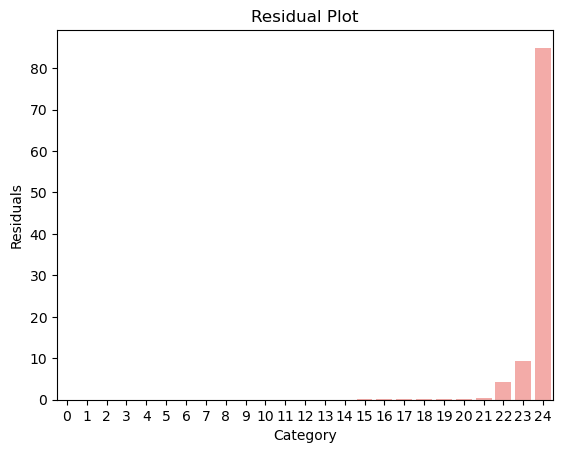

[0.0008994909, 0.0009258567, 0.006533656, 0.00657358, 0.018528616, 0.019844173, 0.049561396, 0.057330843, 0.12447364, 0.1358613, 0.14307371, 0.15214103, 0.16937448, 0.17646389, 0.23048937, 0.23407987, 0.30424494, 0.71843386, 0.83199704, 1.0316098, 1.0621133, 1.0627621, 1.3915083, 17.63046, 74.44071]


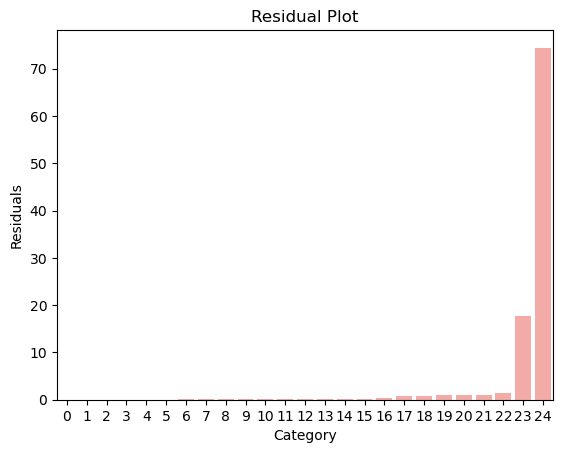

[0.005048762, 0.008983541, 0.016796835, 0.026131045, 0.037276354, 0.076494865, 0.09403315, 0.11326192, 0.12922299, 0.18072754, 0.30882162, 0.33831665, 0.4105304, 0.44650644, 0.6282888, 1.1138183, 1.6765928, 1.9161, 4.0865836, 4.964174, 6.2464023, 6.4383464, 9.835602, 14.379339, 46.522606]


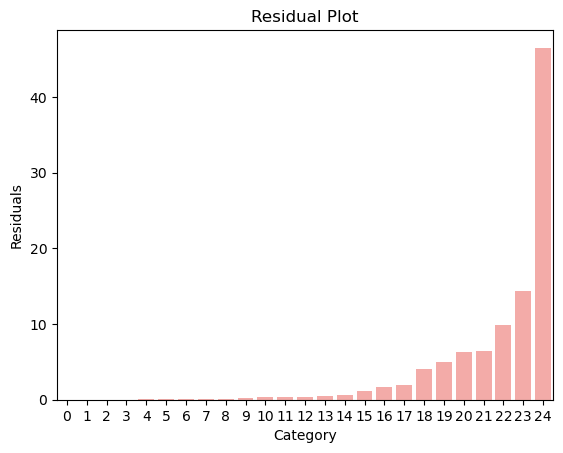

[7.4538602e-06, 8.371906e-05, 0.0005770162, 0.00066685036, 0.0014551467, 0.0017420927, 0.0055429684, 0.0058504664, 0.014852734, 0.015483259, 0.017450517, 0.03585963, 0.04944259, 0.09568256, 0.13320076, 0.49178982, 0.49460623, 0.6225533, 0.717585, 0.85719246, 1.4396691, 3.1040897, 6.3560524, 10.449736, 75.08882]


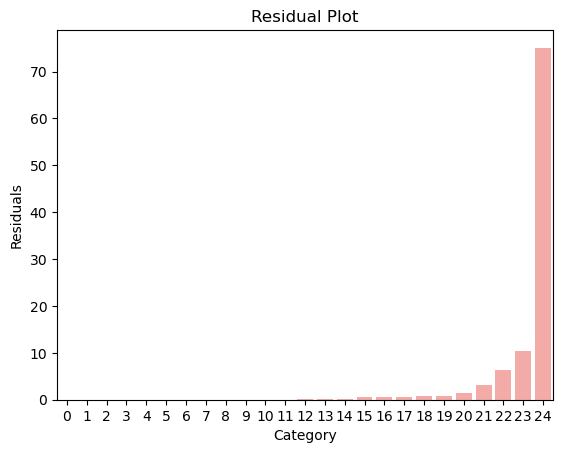

[1.8533877e-22, 3.326814e-20, 1.2460127e-19, 2.691888e-19, 3.333576e-18, 4.615837e-17, 5.570843e-17, 9.7485684e-17, 1.96534e-16, 4.4779567e-16, 7.3078927e-16, 1.6749898e-15, 2.5649509e-15, 4.1535383e-15, 5.2183963e-15, 1.556007e-14, 1.009694e-13, 1.3097852e-13, 2.1577766e-11, 4.063208e-11, 4.845099e-11, 1.2349666e-10, 2.5701974e-10, 5.6461524e-09, 100.0]


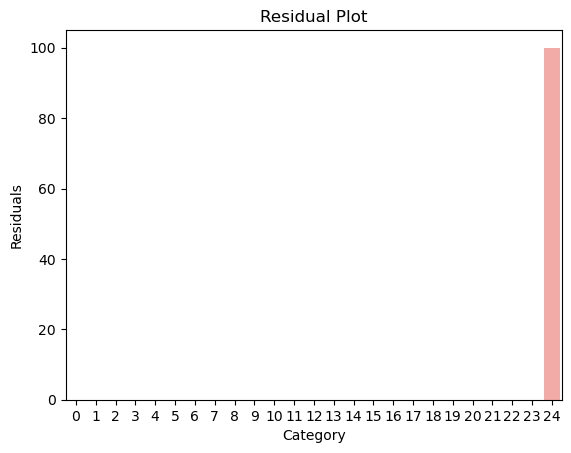

[0.03080983, 0.039450046, 0.053451832, 0.054072, 0.07886443, 0.08478155, 0.09035834, 0.09733174, 0.13536313, 0.1530633, 0.20708139, 0.2331774, 0.25438786, 0.27394247, 0.49343655, 0.54213566, 0.5456128, 0.5709544, 0.7101885, 1.3377311, 1.6401387, 1.8041087, 11.243276, 17.322626, 62.003647]


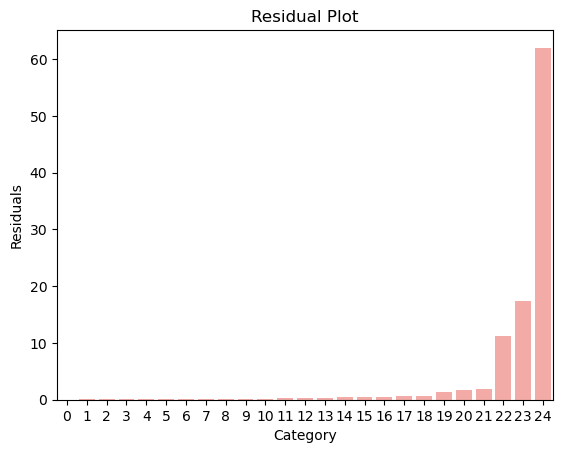

[3.9681294e-05, 5.5819946e-05, 0.00028210704, 0.00049963174, 0.00058784155, 0.0017304455, 0.0035301861, 0.0051995637, 0.0062006703, 0.011678285, 0.013081954, 0.01780405, 0.020618342, 0.03224392, 0.03344799, 0.044655982, 0.12341541, 0.18043174, 0.29153064, 0.3445609, 0.40409067, 0.43643144, 0.60457003, 1.4028451, 96.02047]


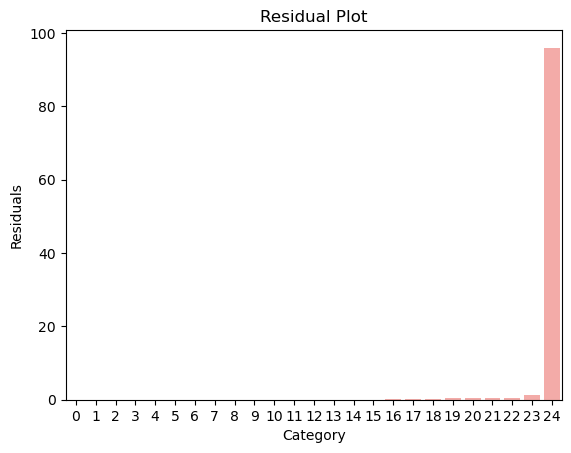

[0.0049609025, 0.045358848, 0.091807835, 0.09479758, 0.10509951, 0.24470243, 0.35835034, 0.38621515, 0.392811, 0.60353947, 0.7094234, 0.71501005, 0.8473837, 0.89212114, 0.94833887, 3.1747355, 3.397454, 4.2611976, 4.420019, 4.764297, 5.2037673, 7.44531, 11.011079, 15.540175, 34.34204]


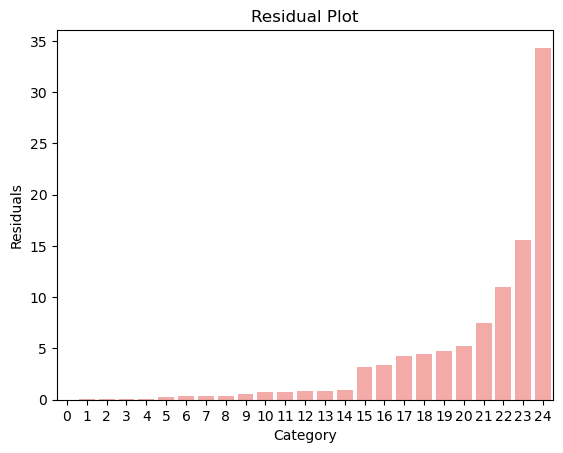

[0.03080983, 0.039450046, 0.053451832, 0.054072, 0.07886443, 0.08478155, 0.09035834, 0.09733174, 0.13536313, 0.1530633, 0.20708139, 0.2331774, 0.25438786, 0.27394247, 0.49343655, 0.54213566, 0.5456128, 0.5709544, 0.7101885, 1.3377311, 1.6401387, 1.8041087, 11.243276, 17.322626, 62.003647]


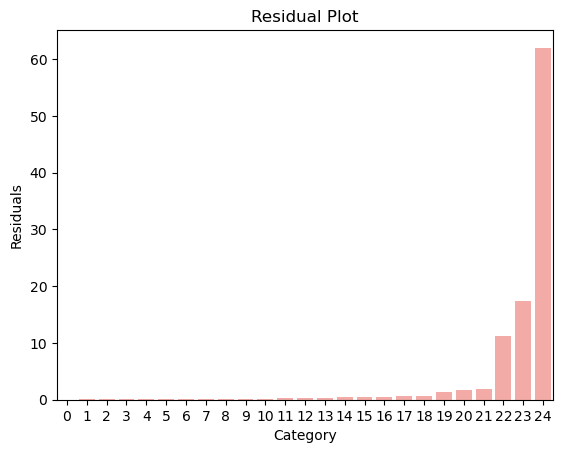

[1.3659468e-06, 9.161058e-05, 0.00031247968, 0.0012605883, 0.0037867548, 0.0040485817, 0.024723059, 0.029553143, 0.03181301, 0.035912022, 0.045917656, 0.049833734, 0.0760123, 0.10482311, 0.144017, 0.1670464, 0.40260983, 0.7887181, 0.955157, 1.222313, 1.6853817, 3.6732635, 9.837917, 11.176517, 69.53897]


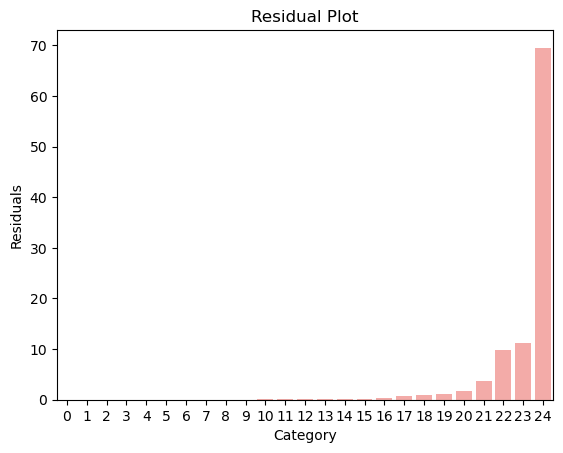

[4.3736528e-10, 7.183713e-10, 1.086108e-07, 1.1945843e-07, 1.7401798e-07, 3.5912782e-07, 4.119377e-07, 5.6623554e-07, 1.2794361e-06, 2.3626744e-06, 2.4774833e-06, 1.3741573e-05, 3.466099e-05, 8.679873e-05, 0.00013933654, 0.0004962479, 0.0010043315, 0.0013596071, 0.0014420768, 0.0014842082, 0.017002327, 0.019036077, 0.1598658, 0.16700664, 99.63102]


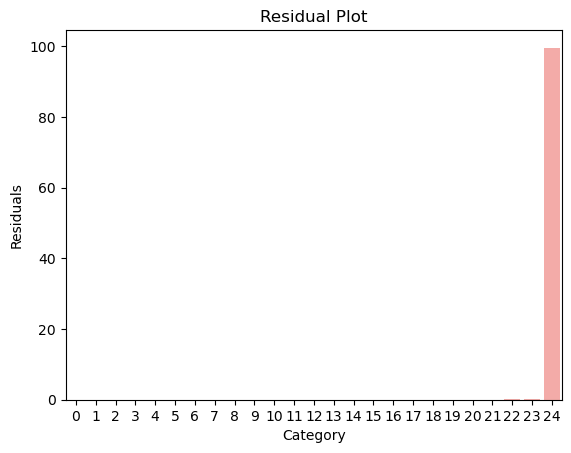

[1.2142156e-09, 1.6231396e-09, 4.155099e-09, 1.0291347e-08, 1.0305372e-08, 2.7220832e-08, 3.638564e-08, 2.0257e-07, 3.027804e-07, 7.690029e-07, 5.5800756e-06, 5.9367776e-06, 1.480055e-05, 3.4893677e-05, 4.8147165e-05, 0.00019482743, 0.00023334986, 0.00026041394, 0.00032921636, 0.00046409285, 0.00089352304, 0.007400495, 0.013170407, 0.58708286, 99.38986]


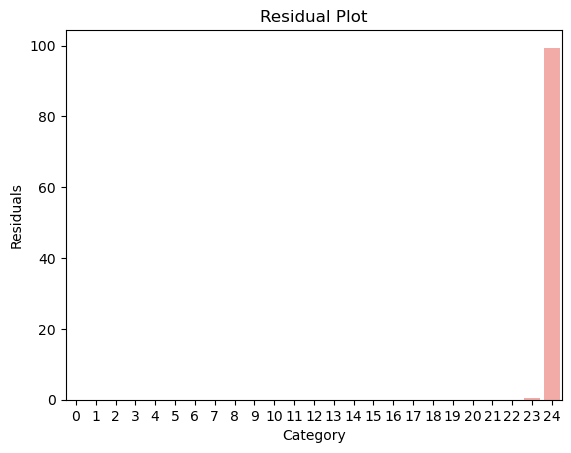

[1.1733046e-05, 6.985117e-05, 0.00034615415, 0.0010200199, 0.0017901636, 0.0025201426, 0.0027510142, 0.004763741, 0.0048893252, 0.0068466235, 0.034811314, 0.044264466, 0.044810224, 0.10316624, 0.13113238, 0.45019126, 0.53120065, 0.76050323, 2.1308787, 2.1939538, 2.227902, 2.9112926, 2.9790304, 25.602283, 59.829563]


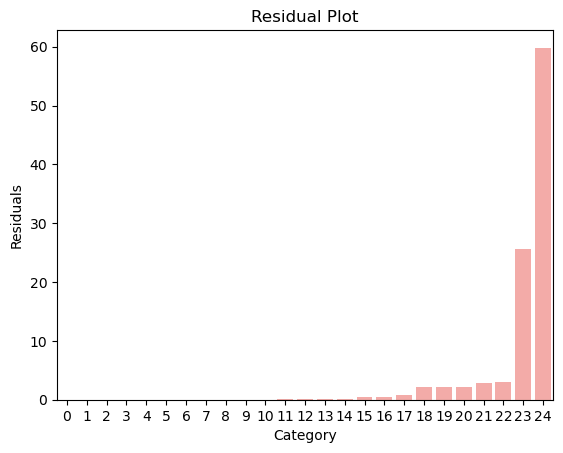

[5.8797184e-10, 5.613188e-09, 6.786044e-08, 7.037699e-08, 9.0525293e-07, 1.3439256e-06, 7.5556727e-06, 7.5579073e-06, 2.1587464e-05, 6.0915885e-05, 9.0000634e-05, 9.6514326e-05, 0.000100852376, 0.00011576396, 0.000685713, 0.00081445504, 0.006105827, 0.007939651, 0.009456475, 0.011693816, 0.028434014, 0.042672623, 0.068425305, 0.31642047, 99.50684]


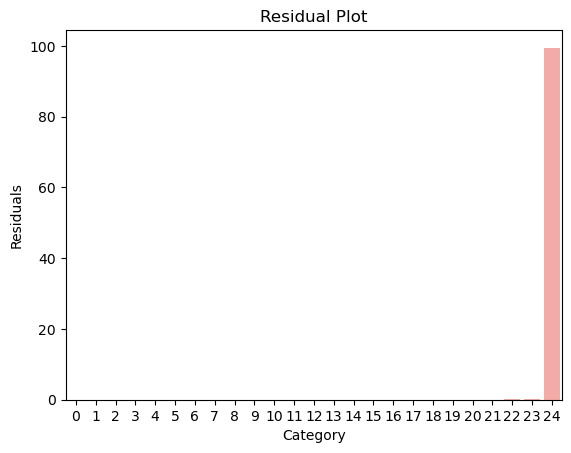

[0.00017182647, 0.0059736525, 0.007455787, 0.008177717, 0.05492098, 0.05727025, 0.07002291, 0.16133338, 0.41661298, 0.4521364, 0.5317502, 0.6143928, 0.7224051, 0.73338467, 1.0189893, 1.3071752, 2.1986203, 2.2225726, 3.5621867, 5.02971, 8.184241, 8.252027, 10.270791, 23.39701, 30.720654]


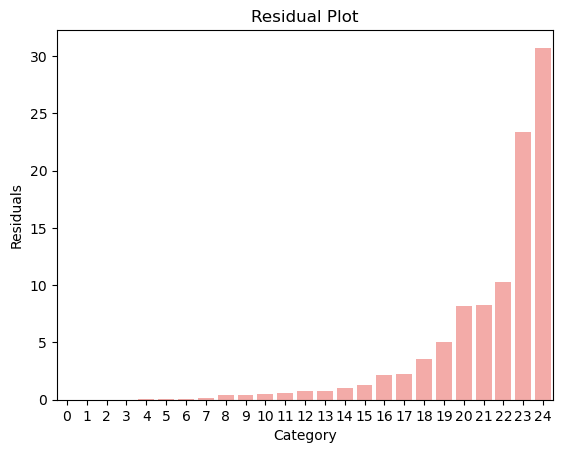

[5.1373822e-18, 9.2671837e-17, 3.4517673e-14, 1.904046e-13, 3.166555e-13, 9.77562e-12, 4.912468e-10, 8.088412e-09, 1.3926084e-08, 2.4379485e-08, 4.0406285e-08, 4.943982e-08, 9.41918e-08, 3.5657487e-07, 6.278732e-07, 1.009872e-06, 1.0264603e-06, 1.1009979e-06, 1.1275524e-06, 1.3610714e-06, 0.00010220131, 0.00010291127, 0.000302411, 0.041139863, 99.95834]


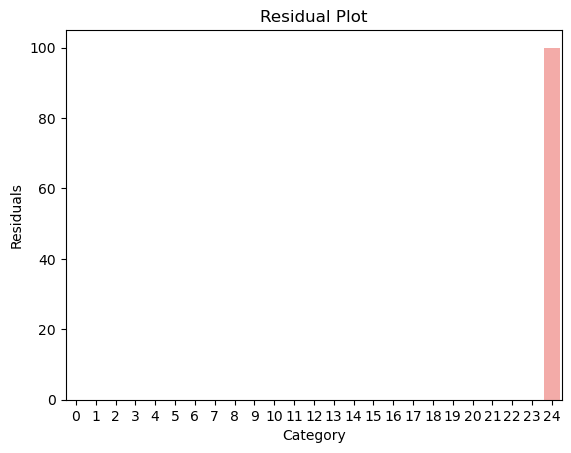

[0.0056236573, 0.007887363, 0.023062501, 0.0294877, 0.034545865, 0.046428237, 0.056163307, 0.06170462, 0.10462375, 0.12071476, 0.1605202, 0.18396325, 0.2845032, 0.33656216, 0.4382086, 0.43958566, 0.4527803, 0.73444664, 2.9763649, 3.2706187, 6.2288237, 6.6036744, 13.720759, 14.86689, 48.812054]


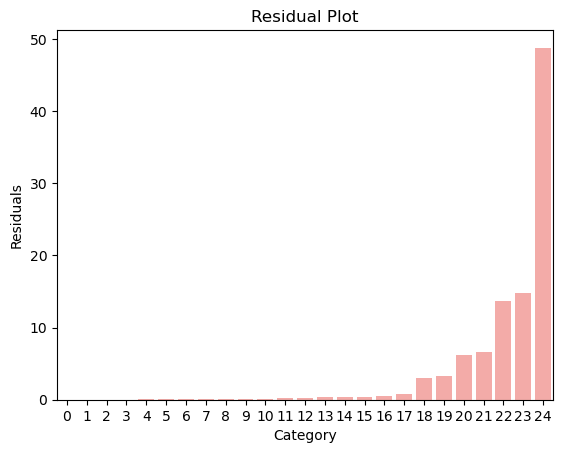

[1.1495111e-06, 5.290788e-06, 2.456053e-05, 2.5938169e-05, 0.00038872485, 0.000432023, 0.0010582663, 0.0010747685, 0.0013853085, 0.0024043901, 0.0029382748, 0.0036850916, 0.011785288, 0.01327517, 0.013753612, 0.0138983345, 0.01455858, 0.017998684, 0.01871326, 0.034989797, 0.16980635, 0.24064709, 2.3132534, 3.8263588, 93.29754]


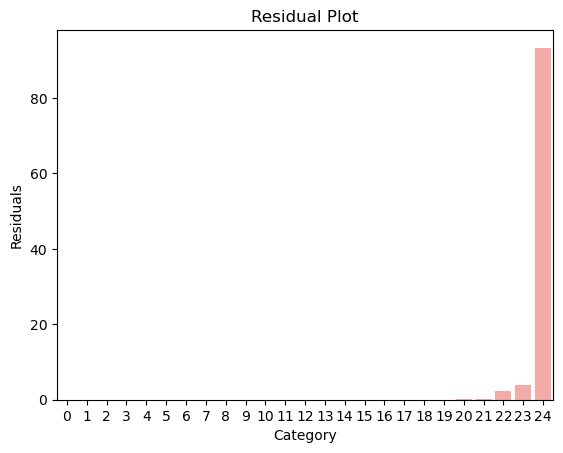

[1.02986e-07, 2.3641813e-07, 1.0164945e-06, 2.4411752e-06, 5.36511e-06, 2.0606838e-05, 3.0053514e-05, 5.0513416e-05, 0.00020542608, 0.00033264188, 0.000528219, 0.0012254058, 0.0041488763, 0.0063212086, 0.0076578087, 0.008544214, 0.008745158, 0.018101374, 0.020305062, 0.022524621, 0.02333377, 0.14054996, 0.7903546, 6.044455, 92.90256]


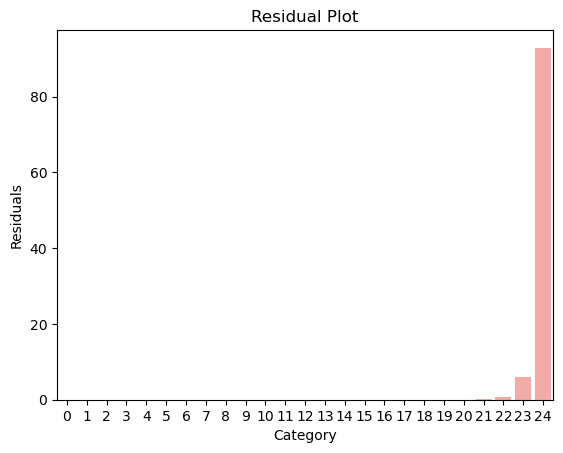

[5.1373822e-18, 9.2671837e-17, 3.4517673e-14, 1.904046e-13, 3.166555e-13, 9.77562e-12, 4.912468e-10, 8.088412e-09, 1.3926084e-08, 2.4379485e-08, 4.0406285e-08, 4.943982e-08, 9.41918e-08, 3.5657487e-07, 6.278732e-07, 1.009872e-06, 1.0264603e-06, 1.1009979e-06, 1.1275524e-06, 1.3610714e-06, 0.00010220131, 0.00010291127, 0.000302411, 0.041139863, 99.95834]


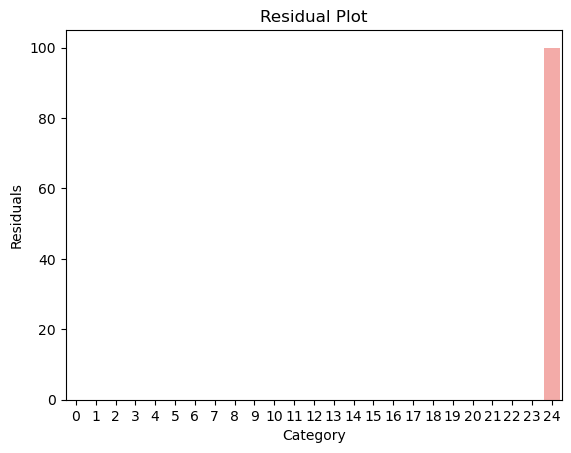

[0.00015886276, 0.00040200618, 0.00041661857, 0.0014893414, 0.0017989145, 0.0021537147, 0.004344454, 0.006699036, 0.015134957, 0.030081404, 0.039158262, 0.044577923, 0.1361145, 0.16046315, 0.20670074, 0.43211803, 0.9381221, 1.3313057, 1.7114079, 3.4750357, 5.2506304, 7.1943545, 8.214564, 10.447098, 60.355675]


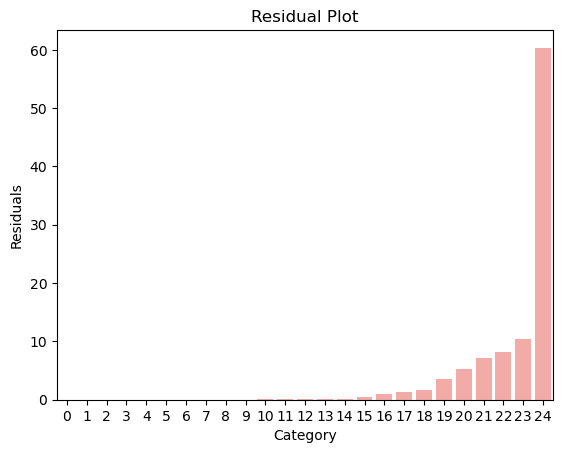

[0.0005018455, 0.0006450999, 0.0026788905, 0.007815314, 0.019349106, 0.037116937, 0.037334524, 0.039750487, 0.040518746, 0.06487405, 0.11319245, 0.16831063, 0.18351057, 0.3135494, 0.42057618, 0.9389243, 1.1617348, 1.2962459, 1.5108571, 2.4840317, 7.71755, 11.7512865, 15.4098625, 25.908194, 30.371592]


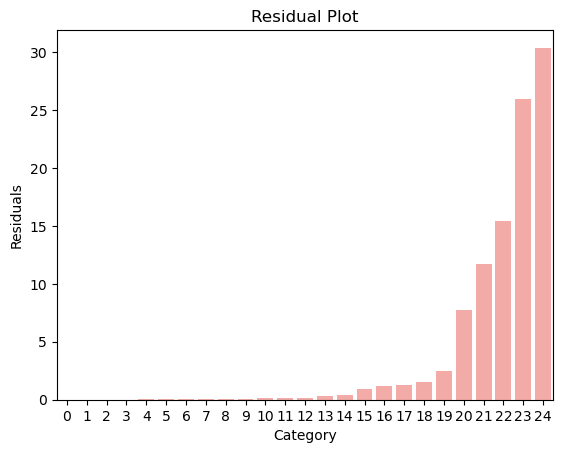

[4.2565235e-10, 1.7514129e-08, 7.787966e-08, 9.645733e-08, 6.020867e-07, 2.2996455e-06, 2.7686694e-06, 3.3850185e-06, 4.8994816e-06, 1.05489735e-05, 4.0159102e-05, 4.3423668e-05, 0.00012622743, 0.00021521762, 0.0004541148, 0.0005145952, 0.0013032756, 0.0013562329, 0.0016062777, 0.008092713, 0.022896715, 0.03856162, 0.058825366, 0.1288785, 99.73706]


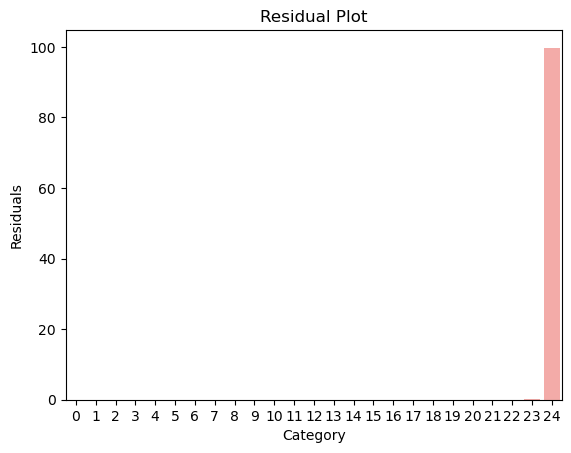

[1.4884056e-17, 9.342434e-16, 1.3017477e-15, 4.076476e-15, 9.289593e-15, 1.16970075e-14, 1.8671594e-14, 2.5924822e-14, 3.6766292e-14, 4.0045024e-13, 1.6342957e-12, 2.4889112e-12, 8.475628e-12, 1.1700237e-11, 1.3271523e-10, 2.6379685e-10, 4.651136e-10, 2.2773763e-08, 2.5139405e-08, 8.778967e-08, 3.4204873e-05, 4.3757747e-05, 7.821818e-05, 0.0018730304, 99.99796]


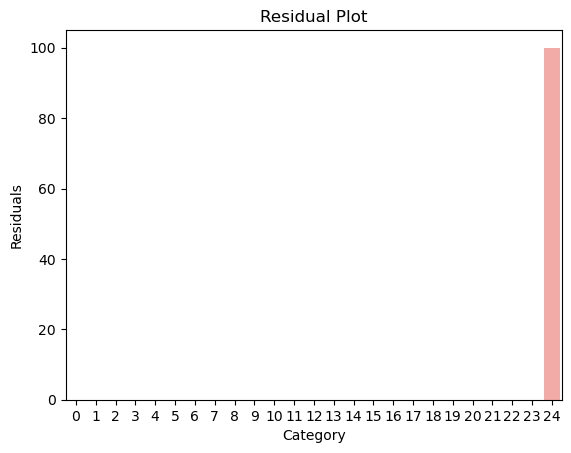

[5.1195912e-15, 1.6788093e-14, 2.0642305e-14, 6.543041e-14, 9.1217886e-14, 1.2005659e-12, 3.381074e-12, 4.686304e-11, 2.3486024e-10, 2.8025574e-10, 3.8750197e-10, 4.4213785e-10, 1.0327239e-09, 1.5688968e-09, 4.762796e-09, 7.574663e-09, 7.460676e-08, 9.155494e-08, 1.6108437e-07, 1.9188002e-07, 8.112188e-07, 1.091404e-06, 1.2817126e-06, 0.0038190265, 99.99617]


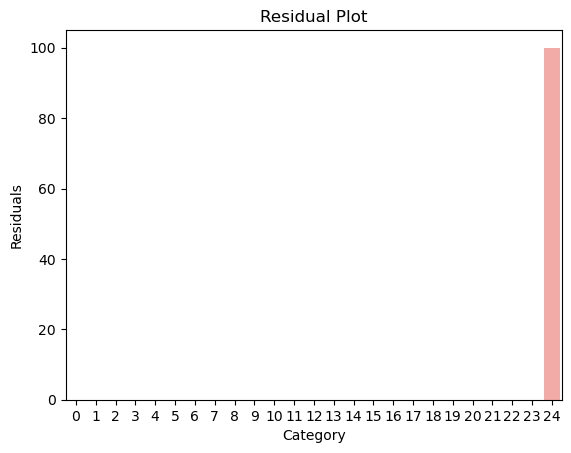

[5.1388815e-06, 2.2444472e-05, 4.726863e-05, 0.00012991481, 0.00028926236, 0.00031916169, 0.0007984809, 0.0017536727, 0.0021385052, 0.0058353553, 0.010059212, 0.018663416, 0.025322692, 0.030670485, 0.070318714, 0.071355306, 0.07825838, 0.14454012, 0.2928174, 1.1262245, 1.2572932, 1.6199787, 1.8711053, 2.6098263, 90.76223]


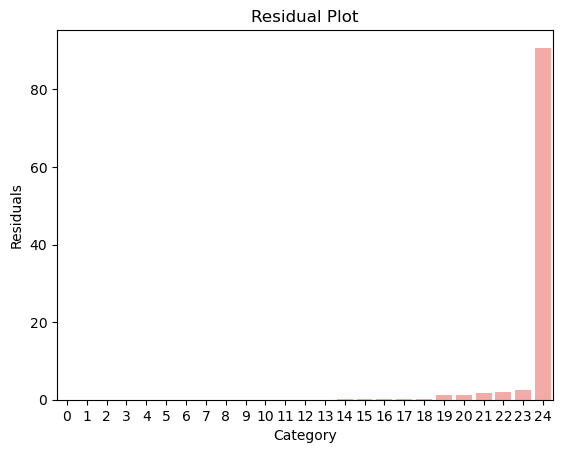

[0.09033495, 0.122375146, 0.1908905, 0.23498482, 0.30194265, 0.5137339, 0.5934782, 0.70503056, 1.0386047, 1.0731621, 1.6801814, 1.7353336, 2.1233206, 2.2035985, 4.0227346, 4.1641603, 5.77206, 6.447122, 6.611783, 7.1444297, 8.045302, 8.422169, 8.524815, 11.105992, 17.132462]


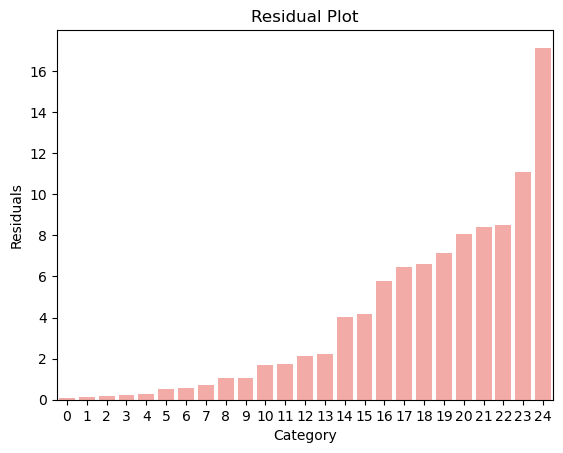

[6.309153e-05, 0.00013959743, 0.0017268942, 0.0030593718, 0.006753968, 0.013633909, 0.01709808, 0.026122205, 0.031037679, 0.06726066, 0.08110959, 0.08990309, 0.16826797, 0.21259594, 0.293607, 0.34029335, 0.45687723, 0.45821047, 0.60336095, 1.7877731, 2.7092562, 3.0045621, 4.526254, 5.62776, 79.47328]


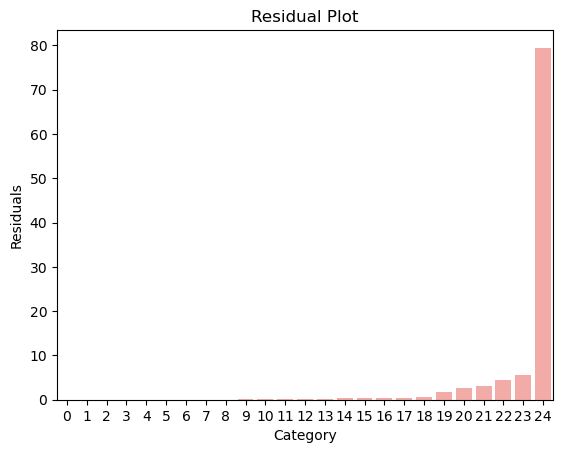

[3.7422637e-13, 5.747409e-12, 2.7650542e-11, 1.1740497e-10, 1.1775123e-10, 2.5079497e-10, 9.793051e-10, 8.1470235e-09, 8.179923e-09, 1.25733095e-08, 2.3332452e-08, 2.5241922e-08, 4.3380172e-08, 3.2999458e-07, 7.7064544e-07, 2.34066e-06, 5.734812e-06, 1.03025695e-05, 4.8340833e-05, 0.00032201092, 0.0007020813, 0.0011988714, 0.0014361343, 0.14151129, 99.85476]


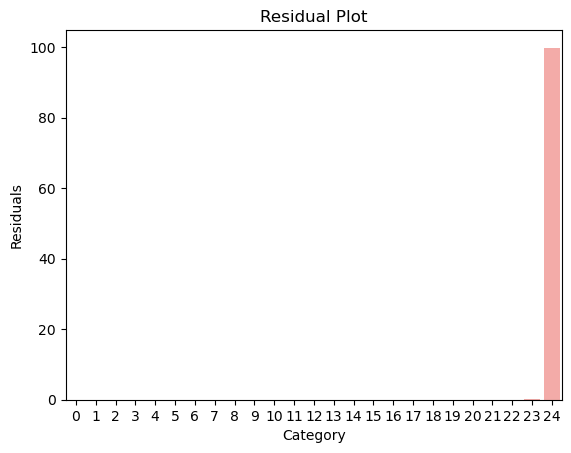

[6.5403134e-07, 1.2497928e-05, 1.6052294e-05, 9.392229e-05, 0.0003577682, 0.0007282598, 0.0008092551, 0.0025508031, 0.0027858806, 0.007500524, 0.008970542, 0.011073328, 0.012214373, 0.02137742, 0.021720361, 0.16850096, 0.2681088, 0.31337377, 1.1654803, 1.5166816, 1.5631069, 1.6469676, 2.4054859, 7.2548494, 83.60724]


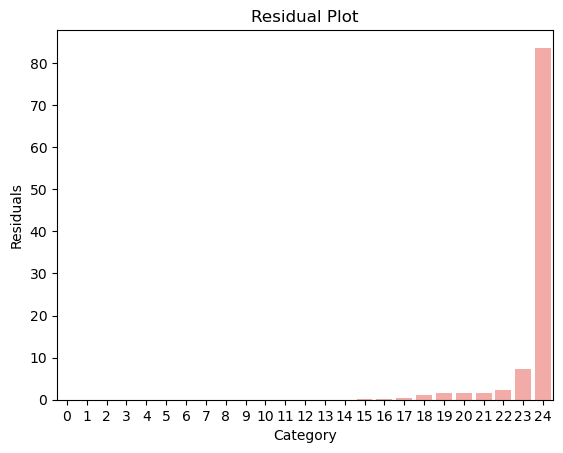

[9.007399e-09, 2.3481444e-08, 2.5928236e-06, 3.2758242e-06, 5.5938003e-06, 1.1550491e-05, 3.438557e-05, 8.708585e-05, 0.00014459163, 0.0001505992, 0.00019305885, 0.00030735717, 0.0006342919, 0.0026180279, 0.009149107, 0.013262957, 0.016586544, 0.016974488, 0.024906855, 0.02546992, 0.030417787, 0.07227762, 0.083798744, 1.2716768, 98.43129]


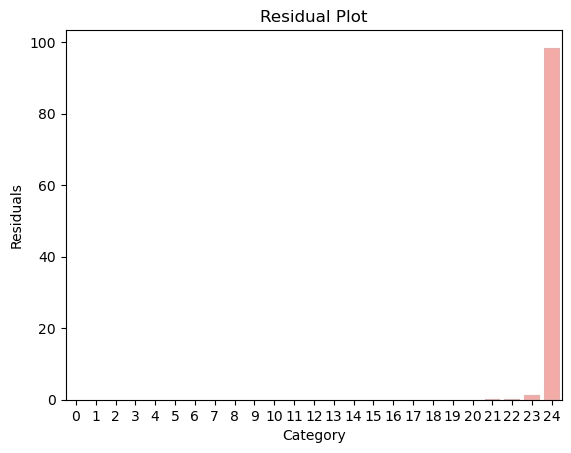

[3.7422637e-13, 5.747409e-12, 2.7650542e-11, 1.1740497e-10, 1.1775123e-10, 2.5079497e-10, 9.793051e-10, 8.1470235e-09, 8.179923e-09, 1.25733095e-08, 2.3332452e-08, 2.5241922e-08, 4.3380172e-08, 3.2999458e-07, 7.7064544e-07, 2.34066e-06, 5.734812e-06, 1.03025695e-05, 4.8340833e-05, 0.00032201092, 0.0007020813, 0.0011988714, 0.0014361343, 0.14151129, 99.85476]


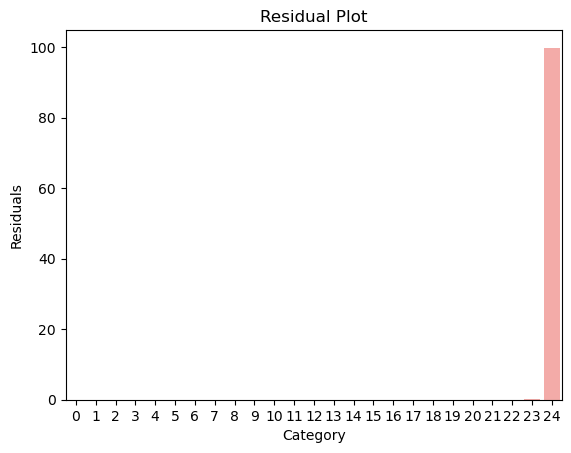

[6.807868e-07, 9.0650934e-07, 2.6114353e-06, 2.0101941e-05, 2.1954753e-05, 0.00010418159, 0.00013340922, 0.00016923732, 0.0002767915, 0.00039455877, 0.00046403744, 0.000916691, 0.0009824628, 0.001030973, 0.0025847051, 0.003011033, 0.005552718, 0.008290175, 0.009320858, 0.012938262, 0.035787128, 0.0588449, 0.06796319, 0.112014905, 99.67917]


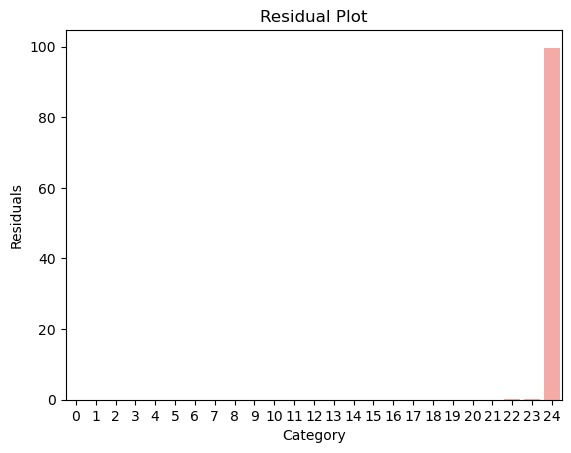

[6.309153e-05, 0.00013959743, 0.0017268942, 0.0030593718, 0.006753968, 0.013633909, 0.01709808, 0.026122205, 0.031037679, 0.06726066, 0.08110959, 0.08990309, 0.16826797, 0.21259594, 0.293607, 0.34029335, 0.45687723, 0.45821047, 0.60336095, 1.7877731, 2.7092562, 3.0045621, 4.526254, 5.62776, 79.47328]


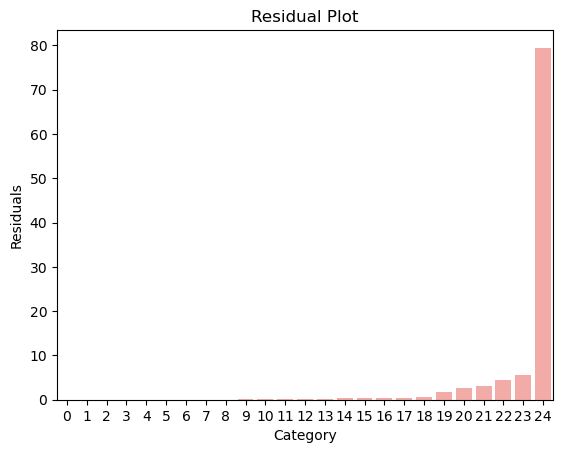

[2.632308e-13, 4.413858e-12, 1.1345465e-11, 4.0918043e-11, 4.4226924e-11, 5.2228274e-11, 9.591566e-11, 9.984652e-11, 3.568624e-10, 2.1535147e-09, 4.184102e-08, 7.0481896e-08, 2.7174306e-06, 1.0199256e-05, 1.6225305e-05, 8.487688e-05, 0.000109986024, 0.0001258197, 0.0031043612, 0.003857266, 0.00454853, 0.01001017, 0.015787605, 0.31040683, 99.65193]


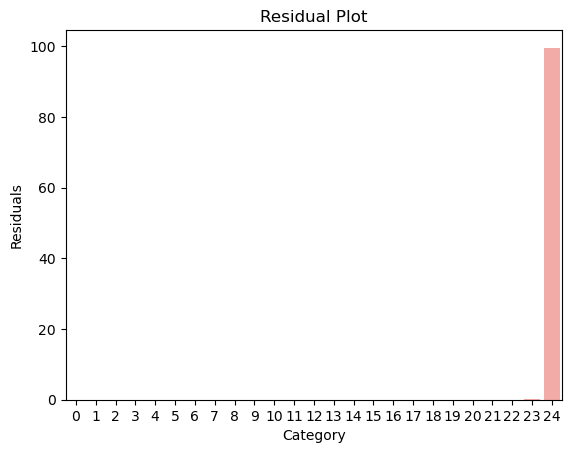

[8.2449425e-15, 3.0575772e-14, 6.8162186e-13, 4.933628e-12, 8.115028e-11, 4.4311768e-10, 5.263016e-10, 8.4639273e-10, 4.202292e-09, 7.1664e-09, 1.2995177e-08, 1.6278166e-08, 1.9895157e-07, 1.5719322e-06, 2.9071625e-06, 3.0706694e-06, 6.404404e-06, 7.756589e-06, 1.1146674e-05, 1.808794e-05, 1.8542312e-05, 8.712925e-05, 0.00010503021, 0.0240495, 99.975685]


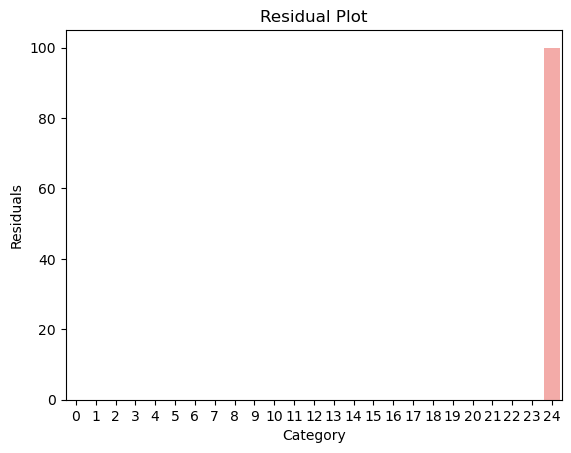

[7.714685e-16, 1.0235397e-15, 4.1028955e-11, 7.5153536e-11, 7.590668e-11, 5.169009e-10, 5.954488e-10, 9.600456e-09, 2.4207097e-08, 3.3001083e-08, 3.4136566e-08, 9.443678e-07, 3.5148073e-06, 5.794307e-06, 6.278095e-06, 9.104726e-06, 1.5814558e-05, 2.0145791e-05, 4.1685762e-05, 8.6688575e-05, 9.077956e-05, 0.0013870755, 0.17425524, 0.8326876, 98.99138]


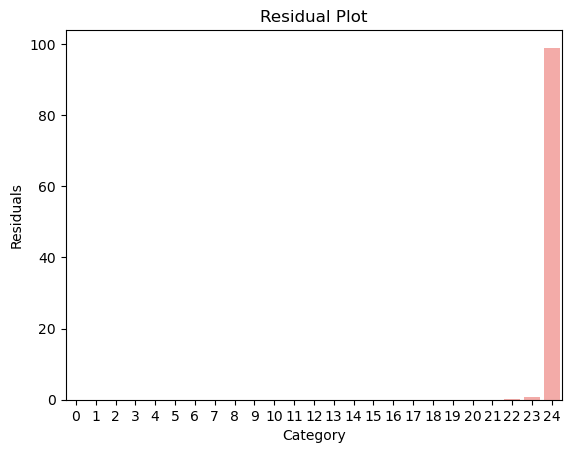

[1.8055953e-16, 8.1388685e-15, 1.6134305e-12, 3.6269176e-12, 7.861617e-12, 2.4661181e-11, 1.5309241e-10, 2.0388459e-10, 3.2681757e-09, 6.6378196e-09, 9.623767e-09, 1.112737e-08, 4.4723546e-08, 6.351314e-07, 1.1195463e-06, 1.3434351e-06, 8.544905e-06, 1.2318939e-05, 1.6303517e-05, 2.3932984e-05, 3.1724925e-05, 3.308505e-05, 0.00013808004, 0.00020406146, 99.999535]


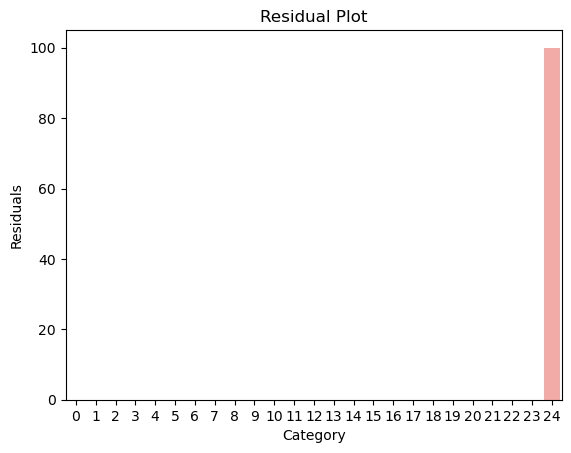

[0.0863293, 0.14102775, 0.1559094, 0.22333695, 0.34230614, 0.37178794, 0.4621111, 0.52848876, 0.80666226, 0.8154204, 0.87712175, 0.89249325, 0.9848277, 2.3374581, 2.5695553, 2.8144612, 3.0891547, 3.7886899, 7.5182633, 7.5972342, 7.925044, 9.242645, 13.846723, 16.230259, 16.352697]


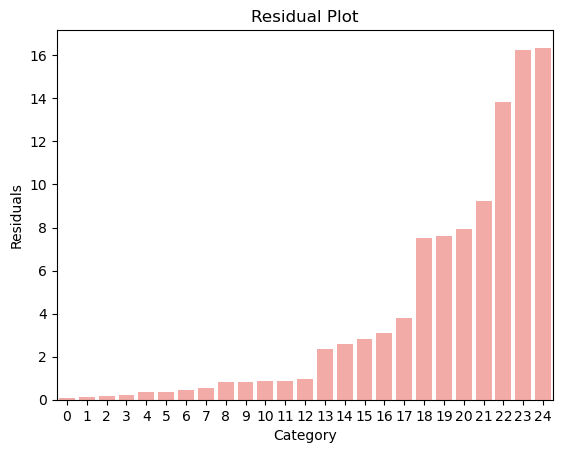

[0.00019497795, 0.0018386374, 0.0050807, 0.006459154, 0.0119909085, 0.018470267, 0.1382763, 0.14093325, 0.15719053, 0.21510595, 0.30117786, 0.32457548, 0.3702912, 0.3805871, 0.41393912, 1.0960321, 1.3726356, 1.8911444, 2.307427, 2.6087463, 3.5973706, 8.396183, 16.084497, 18.578892, 41.58096]


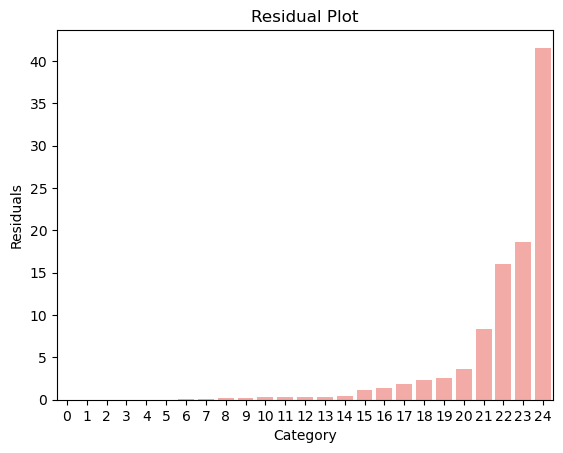

[1.6658719e-08, 1.335664e-07, 2.8231348e-06, 3.3282681e-06, 5.158325e-06, 1.0787806e-05, 1.4380773e-05, 2.0060601e-05, 7.1548035e-05, 0.00010558967, 0.00030682856, 0.00038577782, 0.00047915045, 0.0005659195, 0.0018962229, 0.0033644177, 0.0034641586, 0.005308558, 0.006154072, 0.012082861, 0.07442121, 0.088368565, 0.113771155, 0.5659036, 99.12331]


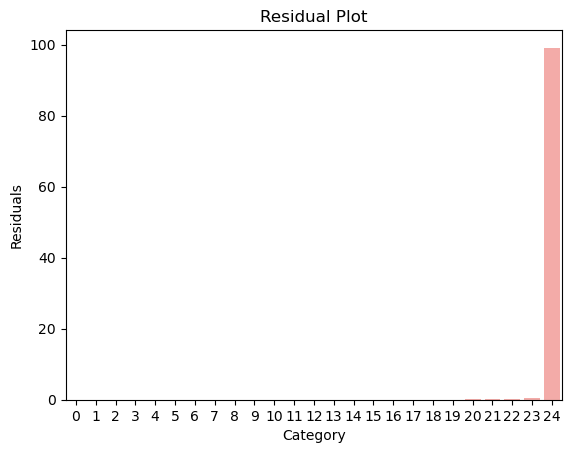

[0.0018147872, 0.0029103365, 0.006325054, 0.016623253, 0.053493842, 0.06552396, 0.16009822, 0.1830869, 0.18541007, 0.2603694, 0.29095098, 0.2920627, 0.5762252, 1.0682558, 1.1297323, 1.4065405, 2.268242, 2.3758404, 3.327599, 3.9148223, 6.4085884, 8.089243, 8.2638235, 21.118046, 38.534378]


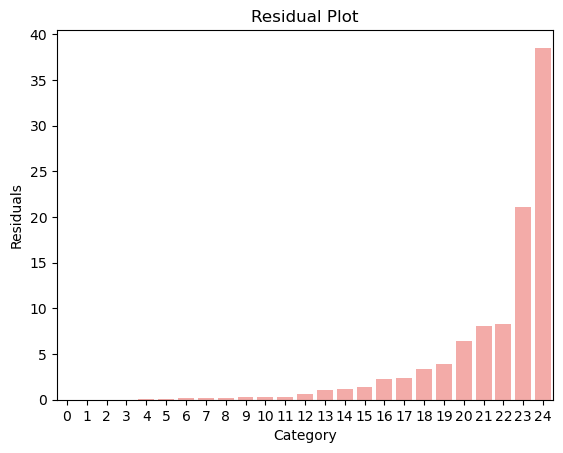

[4.3281803e-13, 2.2696088e-12, 4.168999e-12, 4.0616017e-09, 4.288532e-09, 9.883392e-09, 2.476731e-08, 1.9769257e-07, 3.3166492e-07, 9.478326e-07, 1.919124e-06, 3.775494e-06, 3.854522e-06, 7.5016956e-06, 1.080477e-05, 1.35420505e-05, 6.9460875e-05, 7.4143376e-05, 0.00014345981, 0.0001499747, 0.0002657028, 0.0005326022, 0.00075353746, 0.0023226666, 99.995636]


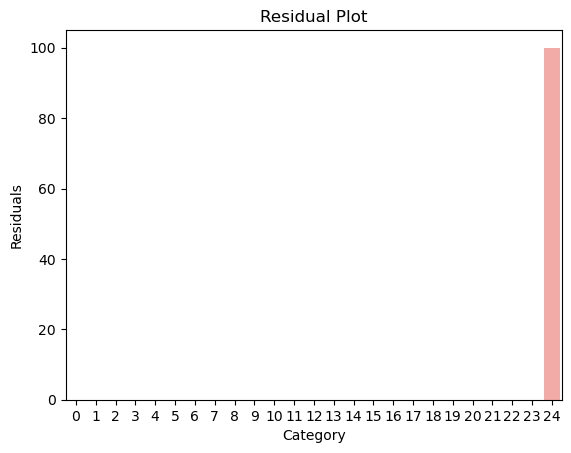

[0.08692332, 0.13064773, 0.1748666, 0.24356055, 0.36108035, 0.3972797, 0.43279278, 0.5846928, 0.80355173, 0.8521692, 0.988477, 1.091787, 1.4329258, 2.2504315, 2.5451481, 2.9609964, 3.0739849, 5.493189, 7.182338, 8.387207, 10.045381, 10.871003, 12.44329, 13.272935, 13.893348]


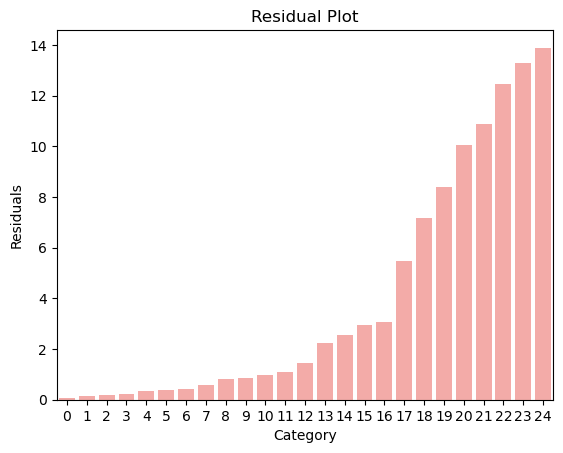

[6.42159e-05, 0.00028823546, 0.0012657685, 0.00334121, 0.0039044116, 0.013643731, 0.01958903, 0.035853695, 0.043972373, 0.0600993, 0.06763673, 0.0894896, 0.096732445, 0.13452485, 0.14616363, 0.1593781, 0.17864376, 0.5352341, 0.87319964, 0.8800985, 1.108306, 1.3490119, 4.039774, 24.238718, 65.92106]


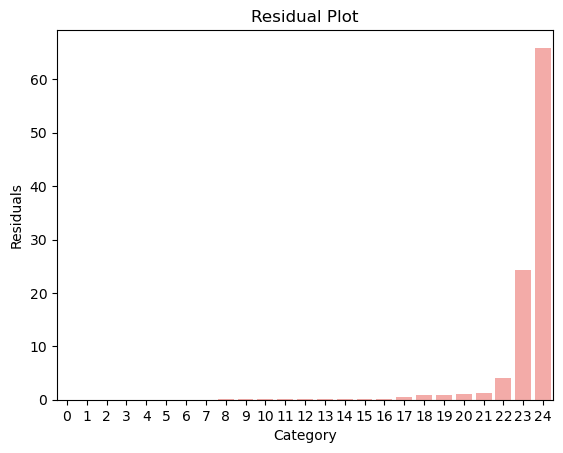

[5.1388815e-06, 2.2444472e-05, 4.726863e-05, 0.00012991481, 0.00028926236, 0.00031916169, 0.0007984809, 0.0017536727, 0.0021385052, 0.0058353553, 0.010059212, 0.018663416, 0.025322692, 0.030670485, 0.070318714, 0.071355306, 0.07825838, 0.14454012, 0.2928174, 1.1262245, 1.2572932, 1.6199787, 1.8711053, 2.6098263, 90.76223]


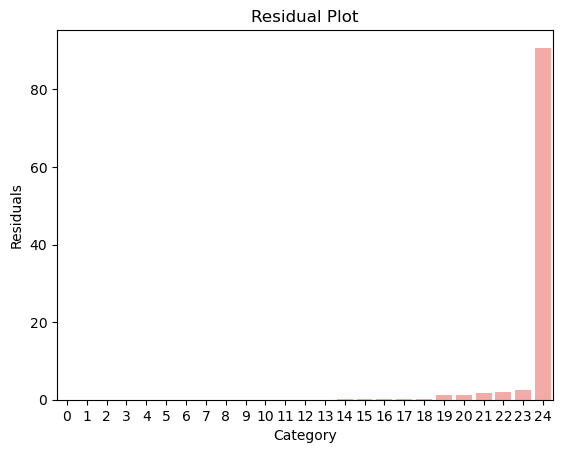

[0.0002648901, 0.0018607166, 0.0036493966, 0.011354429, 0.01335714, 0.017767861, 0.028510004, 0.038903426, 0.05720389, 0.070195764, 0.22622892, 0.24395332, 0.2635833, 0.4998101, 0.5447128, 0.5700006, 0.80625033, 0.89741135, 0.9467016, 1.2983543, 1.5862756, 2.0800114, 2.8459766, 5.187938, 81.759735]


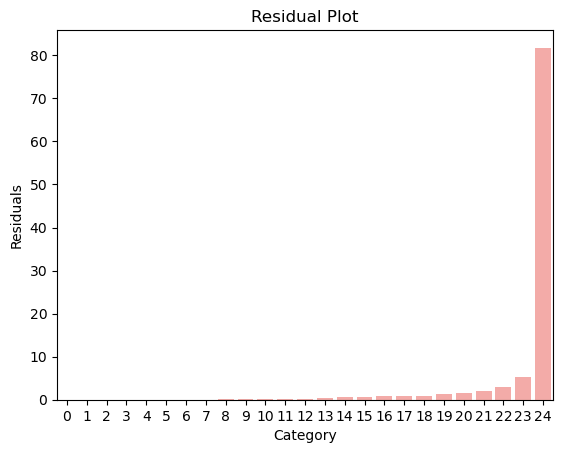

[1.789561e-06, 2.5298352e-06, 4.2790525e-06, 3.5421504e-05, 0.00015791843, 0.00026592924, 0.00044834256, 0.0006653683, 0.0007726721, 0.00082740665, 0.0019416475, 0.002255603, 0.0027849842, 0.0028667953, 0.004173833, 0.0150100505, 0.021309428, 0.022838645, 0.04743926, 0.052444212, 0.23575881, 0.34499484, 0.4875149, 3.2601292, 95.49535]


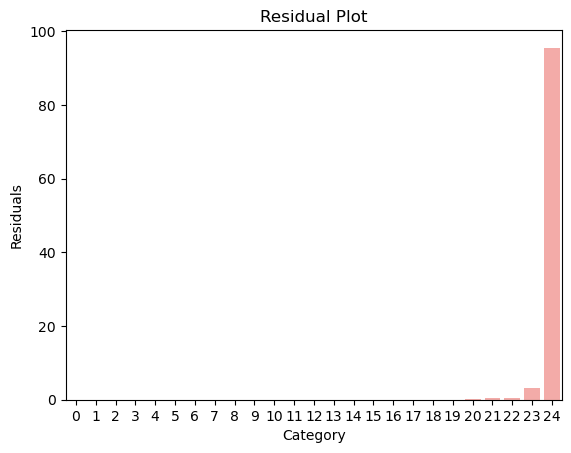

[5.988175e-06, 1.0462932e-05, 6.0556915e-05, 0.00014224858, 0.00037507116, 0.00037870352, 0.00046320938, 0.00046661266, 0.0011717437, 0.0013695284, 0.0029497102, 0.0035743986, 0.004423637, 0.006592105, 0.0102702975, 0.012339893, 0.07233262, 0.1024352, 0.106201775, 0.1810142, 0.22124442, 0.27195704, 0.40955678, 2.3504457, 96.24022]


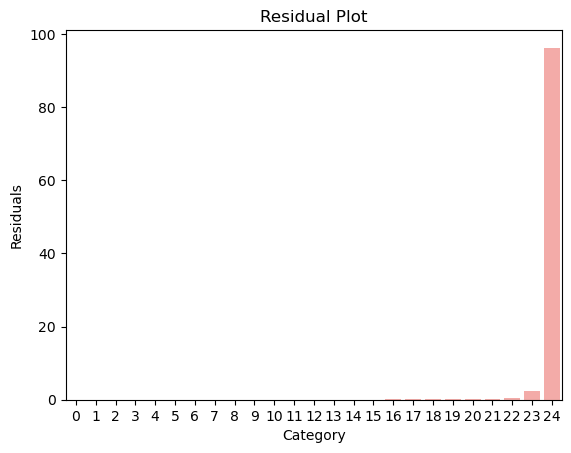

[1.789561e-06, 2.5298352e-06, 4.2790525e-06, 3.5421504e-05, 0.00015791843, 0.00026592924, 0.00044834256, 0.0006653683, 0.0007726721, 0.00082740665, 0.0019416475, 0.002255603, 0.0027849842, 0.0028667953, 0.004173833, 0.0150100505, 0.021309428, 0.022838645, 0.04743926, 0.052444212, 0.23575881, 0.34499484, 0.4875149, 3.2601292, 95.49535]


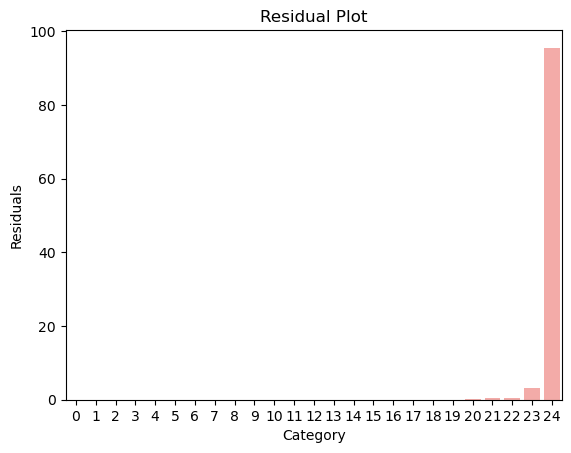

[2.567131e-06, 3.319575e-06, 1.48875215e-05, 1.655235e-05, 1.7010274e-05, 2.0226724e-05, 5.2794992e-05, 0.00019705512, 0.00022854586, 0.0002895291, 0.00032191398, 0.000642292, 0.00089464727, 0.00093822635, 0.00133573, 0.0037609024, 0.003779466, 0.013414113, 0.028160084, 0.0491003, 0.06340449, 0.105530895, 0.14875914, 0.28119844, 99.29792]


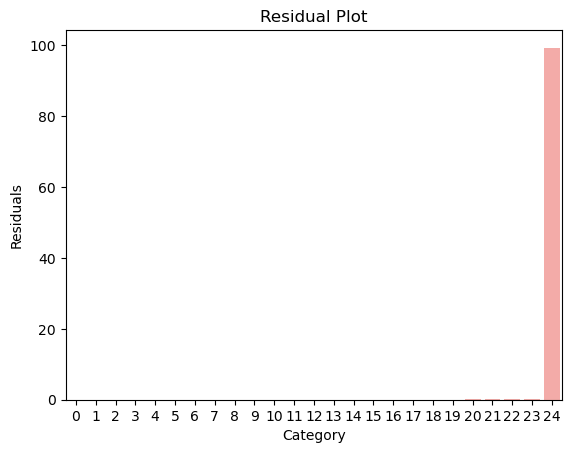

[5.263348e-07, 4.172e-06, 5.7798006e-06, 6.032356e-06, 6.365186e-05, 0.0001702538, 0.00047167012, 0.00049817347, 0.00052536174, 0.0011041093, 0.0024234261, 0.0032426491, 0.004531621, 0.0121773705, 0.03345092, 0.048180055, 0.04944556, 0.05370193, 0.077227116, 0.108681604, 0.25284913, 0.78008634, 0.9991368, 3.8399816, 93.73204]


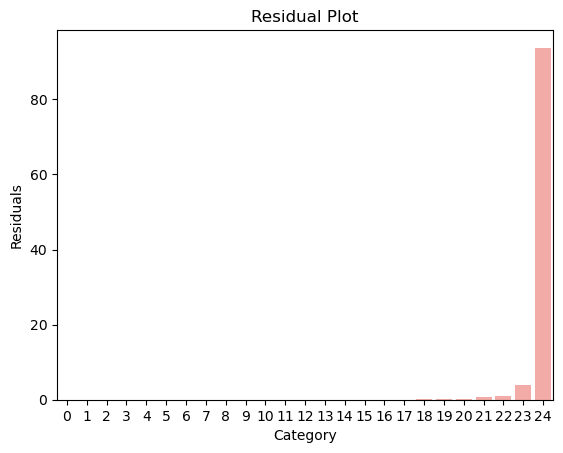

[0.00012296173, 0.0003872938, 0.0033661237, 0.005801316, 0.009786906, 0.010440507, 0.010478262, 0.028962657, 0.043214403, 0.05213527, 0.07621222, 0.07922765, 0.1951004, 0.3170436, 0.47151256, 0.5714778, 1.2323049, 1.4850003, 2.1171298, 2.1590354, 6.6276255, 12.853768, 13.660051, 24.417315, 33.5725]


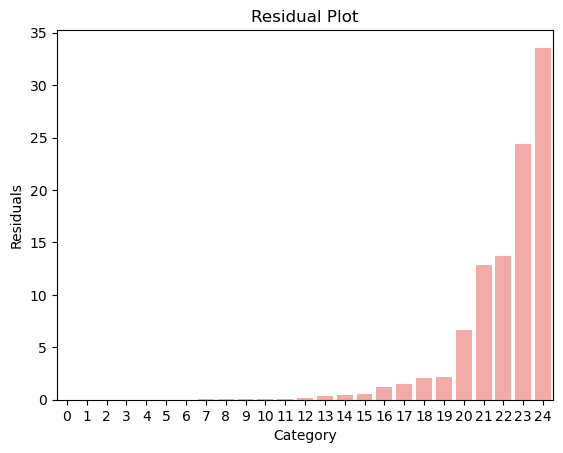

[7.373463e-05, 0.00022235968, 0.00035885442, 0.00048085468, 0.0023720425, 0.0041224654, 0.009678879, 0.017927678, 0.02522618, 0.02591151, 0.046275508, 0.06445565, 0.06590918, 0.10379135, 0.10937493, 0.13323526, 0.14696729, 0.37659377, 0.41550958, 0.5095464, 0.6017326, 0.88743323, 1.5329357, 1.80544, 93.11443]


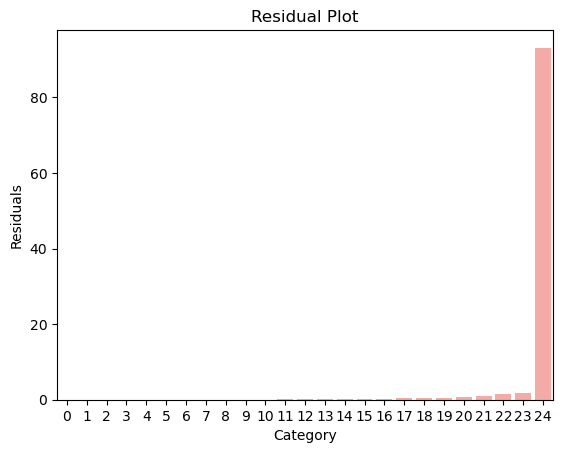

[1.3942704e-09, 7.441933e-08, 8.743238e-08, 2.3496152e-07, 3.8619166e-07, 3.7296165e-06, 5.4624898e-06, 7.31245e-06, 9.055439e-06, 1.2282507e-05, 1.7205142e-05, 4.109358e-05, 7.532749e-05, 9.735328e-05, 0.00014461947, 0.0001694888, 0.00020758796, 0.00027419624, 0.00032143638, 0.00050410815, 0.0005455743, 0.0008271352, 0.076339684, 0.6031363, 99.31726]


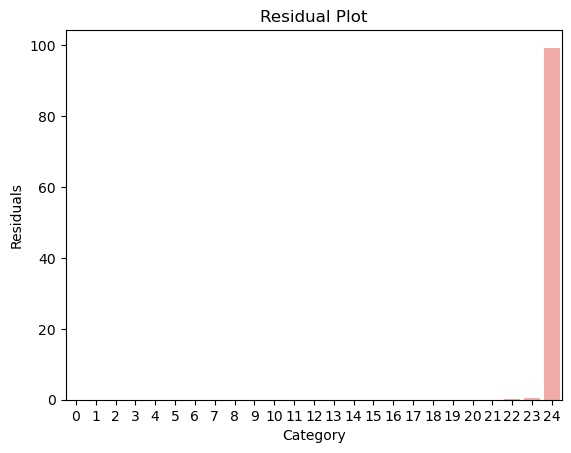

[0.052841153, 0.06677, 0.118255116, 0.15100364, 0.16720669, 0.17614701, 0.2381624, 0.29853803, 0.33171114, 0.33463544, 0.47151074, 0.5668907, 0.6080141, 0.83674973, 1.2853662, 1.2882707, 1.589475, 2.0914378, 4.20638, 4.8193717, 5.2921185, 6.583485, 20.734123, 21.76429, 25.927246]


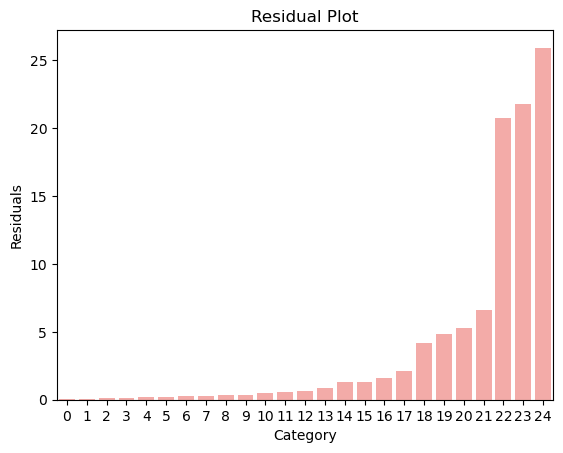

[8.2449425e-15, 3.0575772e-14, 6.8162186e-13, 4.933628e-12, 8.115028e-11, 4.4311768e-10, 5.263016e-10, 8.4639273e-10, 4.202292e-09, 7.1664e-09, 1.2995177e-08, 1.6278166e-08, 1.9895157e-07, 1.5719322e-06, 2.9071625e-06, 3.0706694e-06, 6.404404e-06, 7.756589e-06, 1.1146674e-05, 1.808794e-05, 1.8542312e-05, 8.712925e-05, 0.00010503021, 0.0240495, 99.975685]


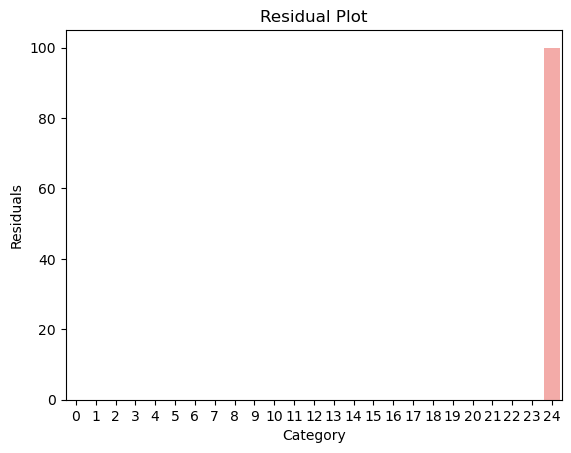

[2.0477477e-15, 7.188116e-13, 5.4267064e-12, 5.8537957e-12, 8.184332e-11, 1.8330617e-09, 5.45594e-09, 1.6868809e-08, 1.7716301e-08, 9.944629e-07, 1.8446283e-06, 3.548832e-06, 3.777971e-06, 5.2761984e-06, 9.355082e-06, 9.4540255e-06, 1.2533654e-05, 3.5774352e-05, 4.1671647e-05, 6.596239e-05, 0.00011844188, 0.00013660858, 0.00044161337, 0.24620531, 99.75292]


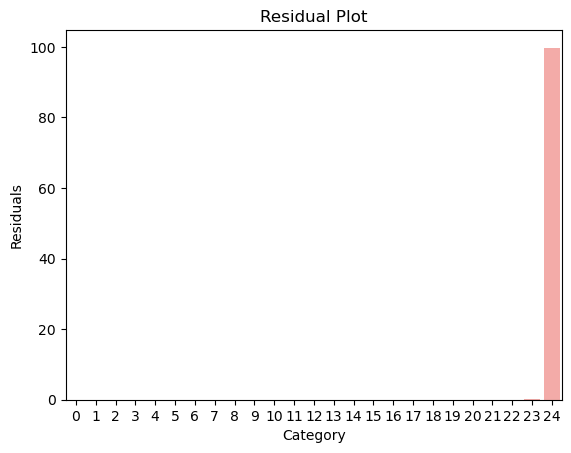

[2.0254678e-05, 3.1189567e-05, 4.4561337e-05, 0.0007084632, 0.00083443936, 0.0009648533, 0.0010962737, 0.0016829203, 0.0038359838, 0.008340261, 0.019276926, 0.02440013, 0.02561317, 0.03042904, 0.045668446, 0.049115345, 0.06988045, 0.0850933, 0.10134789, 0.31778398, 0.4848088, 1.084289, 1.2921901, 3.403671, 92.94887]


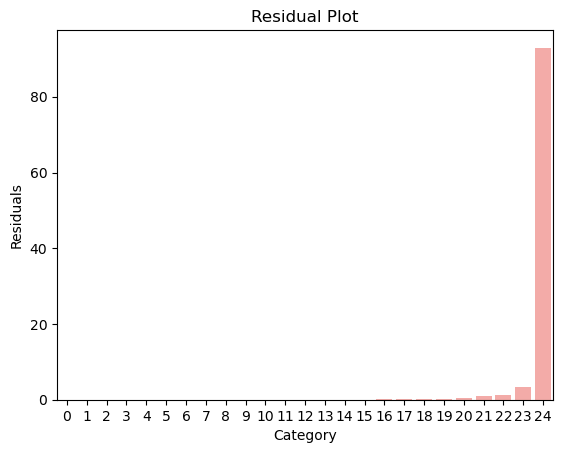

[3.5234482e-08, 1.4009916e-07, 5.6303816e-07, 5.363543e-05, 0.00022274541, 0.0005248762, 0.0006227117, 0.0007995335, 0.0008064685, 0.0027742921, 0.0042281286, 0.008771653, 0.010659328, 0.023096304, 0.03161844, 0.044643015, 0.09132919, 0.10034926, 0.31818506, 0.4125738, 0.65580726, 0.958581, 2.0250401, 5.046066, 90.263245]


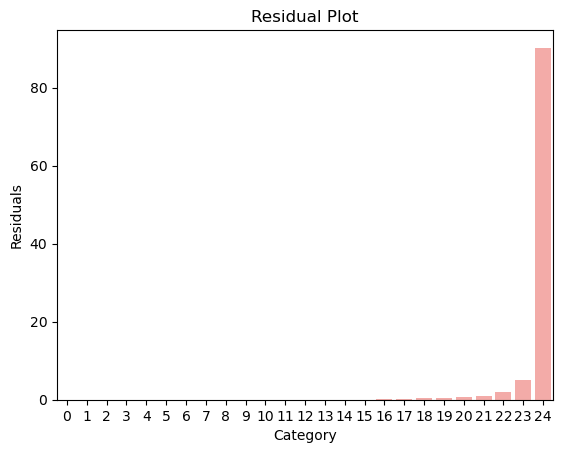

[1.3659468e-06, 9.161058e-05, 0.00031247968, 0.0012605883, 0.0037867548, 0.0040485817, 0.024723059, 0.029553143, 0.03181301, 0.035912022, 0.045917656, 0.049833734, 0.0760123, 0.10482311, 0.144017, 0.1670464, 0.40260983, 0.7887181, 0.955157, 1.222313, 1.6853817, 3.6732635, 9.837917, 11.176517, 69.53897]


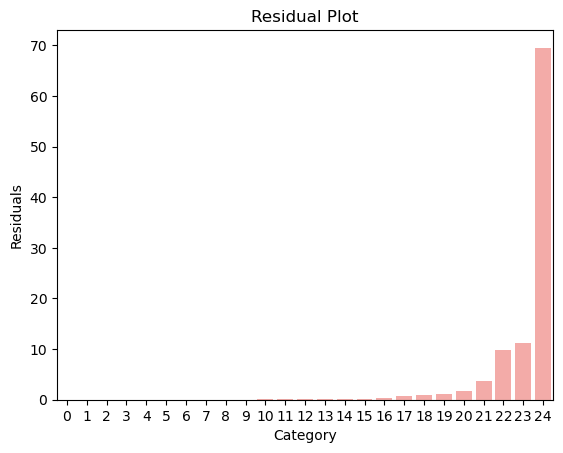

[1.4211595e-09, 6.6697696e-09, 3.7682258e-07, 6.781881e-07, 7.980713e-07, 1.9593094e-06, 3.8645185e-06, 4.4638073e-06, 4.771106e-06, 5.3041995e-06, 1.0713817e-05, 1.0946634e-05, 3.456161e-05, 0.00010667964, 0.00015649802, 0.00016782919, 0.00018276641, 0.00043893006, 0.0013475753, 0.003075921, 0.0077564917, 0.015505802, 0.03426377, 0.101186976, 99.83574]


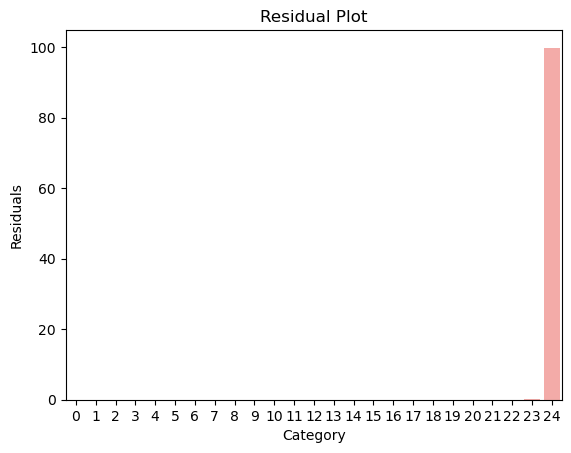

[1.0412644e-13, 1.0518723e-12, 1.1288518e-12, 6.2580366e-12, 6.5495935e-11, 1.15464895e-10, 3.2080835e-10, 5.50535e-10, 1.7984539e-09, 4.4663654e-08, 7.7660026e-08, 1.7504063e-07, 2.5578672e-07, 4.5657572e-07, 1.0669455e-06, 1.1228875e-06, 2.6103087e-06, 3.474275e-06, 1.0891046e-05, 5.9151313e-05, 0.00034396784, 0.0003642339, 0.002013292, 0.0025621962, 99.994644]


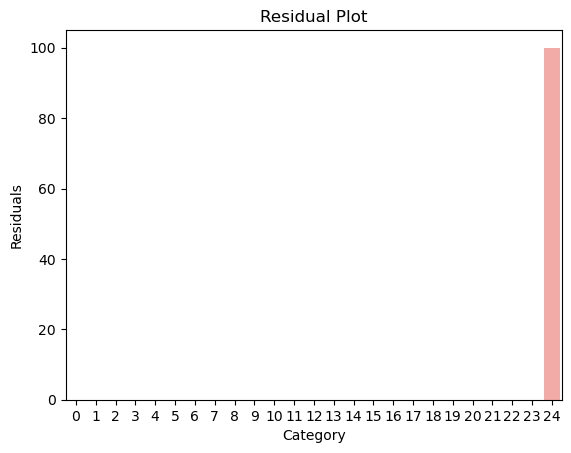

[0.09033495, 0.122375146, 0.1908905, 0.23498482, 0.30194265, 0.5137339, 0.5934782, 0.70503056, 1.0386047, 1.0731621, 1.6801814, 1.7353336, 2.1233206, 2.2035985, 4.0227346, 4.1641603, 5.77206, 6.447122, 6.611783, 7.1444297, 8.045302, 8.422169, 8.524815, 11.105992, 17.132462]


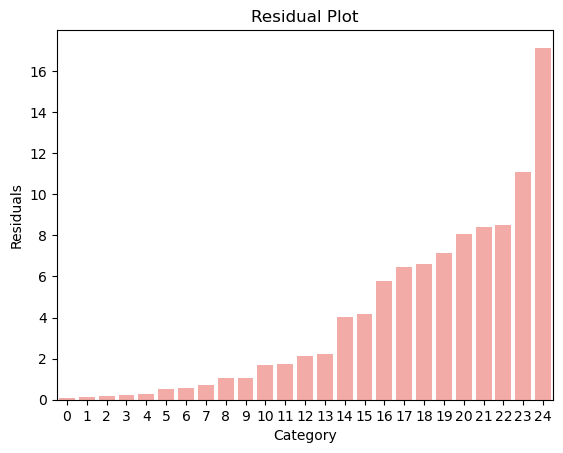

[7.890131e-11, 3.8410364e-09, 5.215461e-09, 4.705098e-08, 1.936956e-07, 2.6557638e-07, 5.0073965e-07, 5.2152285e-07, 9.0520007e-07, 1.937803e-06, 6.9948214e-06, 2.3432609e-05, 2.9377037e-05, 4.5345096e-05, 6.0126662e-05, 9.81442e-05, 0.0001713947, 0.00018476369, 0.00025180422, 0.0009123323, 0.01004425, 0.019591708, 0.05053438, 0.42309576, 99.49496]


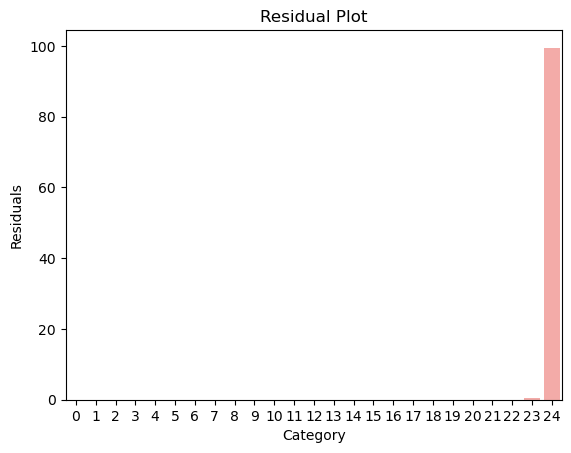

[3.203795e-08, 4.8167188e-08, 1.0439346e-07, 1.7258512e-07, 4.5354756e-07, 8.6728835e-07, 1.8217163e-06, 1.8894282e-06, 5.367901e-06, 7.1931636e-06, 3.211628e-05, 4.052173e-05, 7.9617e-05, 0.00013961604, 0.00014434304, 0.00016262544, 0.00030063826, 0.0008446192, 0.0010486464, 0.015868774, 0.035897307, 0.045761533, 0.05559242, 0.42165244, 99.422424]


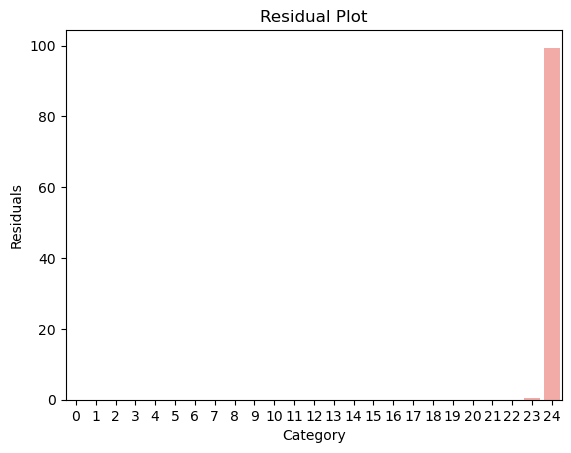

[0.0001611944, 0.0002427095, 0.012926286, 0.015641566, 0.02266156, 0.028441899, 0.056953933, 0.057335332, 0.08002974, 0.08891951, 0.08923796, 0.29614466, 0.34625196, 0.3543769, 0.56527936, 0.628116, 0.74888706, 1.2607765, 1.4979982, 1.7311417, 2.3664436, 2.4214885, 2.80113, 3.1953022, 81.334114]


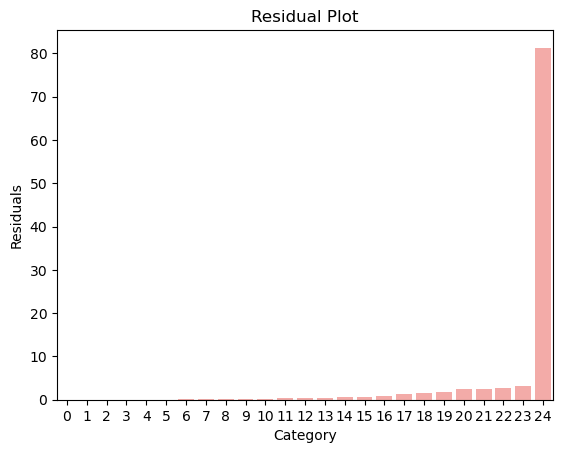

[0.0057232436, 0.029112466, 0.111676894, 0.2954286, 0.297911, 0.362139, 0.4611219, 0.53544545, 0.57890403, 0.8913866, 0.97979766, 1.1578673, 1.338528, 2.2502089, 2.883815, 3.415345, 4.023425, 4.5036426, 4.895821, 4.9777837, 4.9801345, 6.678303, 9.332755, 11.721076, 33.29265]


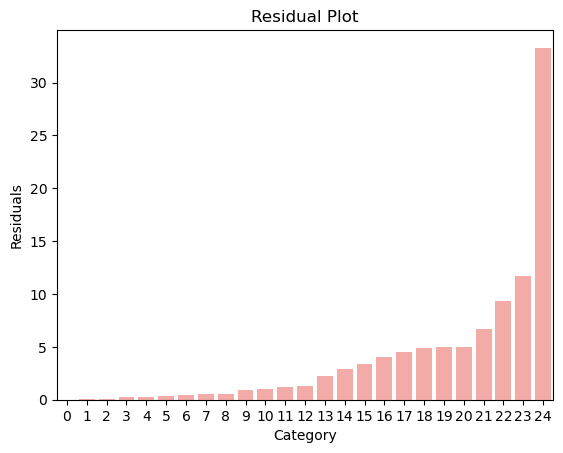

[1.1613307e-06, 2.215775e-05, 4.5170433e-05, 9.713448e-05, 0.00027947407, 0.0004703179, 0.0005078065, 0.000979609, 0.0011952423, 0.0013738524, 0.001443873, 0.0019590058, 0.005221042, 0.0054567955, 0.011217277, 0.014300303, 0.014604158, 0.03197096, 0.07343684, 0.07454907, 0.40652174, 1.1334598, 1.1649197, 15.535273, 81.5207]


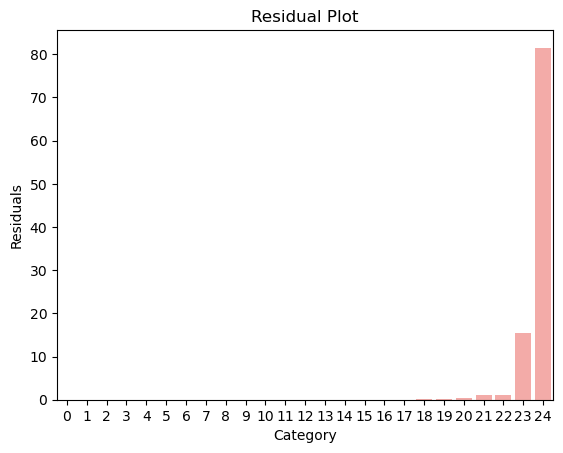

[0.00021277179, 0.00057971285, 0.03663259, 0.047906633, 0.05458232, 0.07934534, 0.09483587, 0.110782415, 0.11631186, 0.13978644, 0.14851077, 0.21807572, 0.2318951, 0.24576688, 0.38232312, 0.82336247, 1.6194096, 2.1966112, 2.473388, 2.7199764, 3.6992948, 4.1067657, 13.060493, 21.169611, 46.223526]


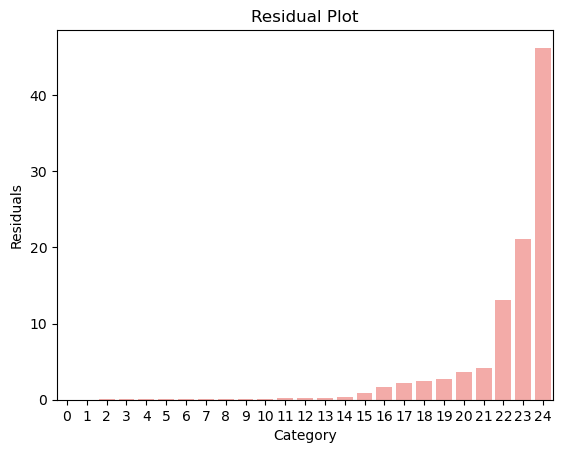

[5.1373822e-18, 9.2671837e-17, 3.4517673e-14, 1.904046e-13, 3.166555e-13, 9.77562e-12, 4.912468e-10, 8.088412e-09, 1.3926084e-08, 2.4379485e-08, 4.0406285e-08, 4.943982e-08, 9.41918e-08, 3.5657487e-07, 6.278732e-07, 1.009872e-06, 1.0264603e-06, 1.1009979e-06, 1.1275524e-06, 1.3610714e-06, 0.00010220131, 0.00010291127, 0.000302411, 0.041139863, 99.95834]


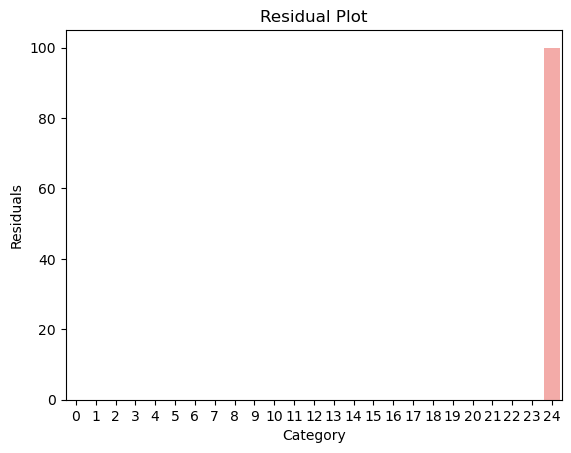

[5.8797184e-10, 5.613188e-09, 6.786044e-08, 7.037699e-08, 9.0525293e-07, 1.3439256e-06, 7.5556727e-06, 7.5579073e-06, 2.1587464e-05, 6.0915885e-05, 9.0000634e-05, 9.6514326e-05, 0.000100852376, 0.00011576396, 0.000685713, 0.00081445504, 0.006105827, 0.007939651, 0.009456475, 0.011693816, 0.028434014, 0.042672623, 0.068425305, 0.31642047, 99.50684]


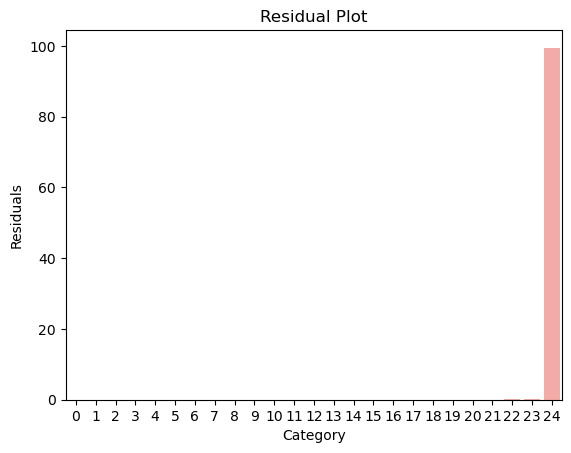

[7.4538602e-06, 8.371906e-05, 0.0005770162, 0.00066685036, 0.0014551467, 0.0017420927, 0.0055429684, 0.0058504664, 0.014852734, 0.015483259, 0.017450517, 0.03585963, 0.04944259, 0.09568256, 0.13320076, 0.49178982, 0.49460623, 0.6225533, 0.717585, 0.85719246, 1.4396691, 3.1040897, 6.3560524, 10.449736, 75.08882]


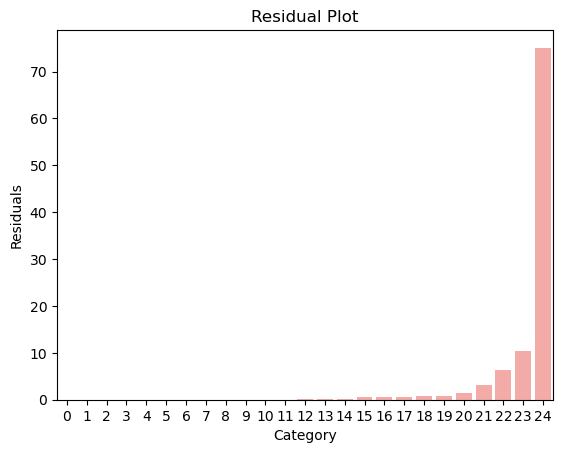

[5.1195912e-15, 1.6788093e-14, 2.0642305e-14, 6.543041e-14, 9.1217886e-14, 1.2005659e-12, 3.381074e-12, 4.686304e-11, 2.3486024e-10, 2.8025574e-10, 3.8750197e-10, 4.4213785e-10, 1.0327239e-09, 1.5688968e-09, 4.762796e-09, 7.574663e-09, 7.460676e-08, 9.155494e-08, 1.6108437e-07, 1.9188002e-07, 8.112188e-07, 1.091404e-06, 1.2817126e-06, 0.0038190265, 99.99617]


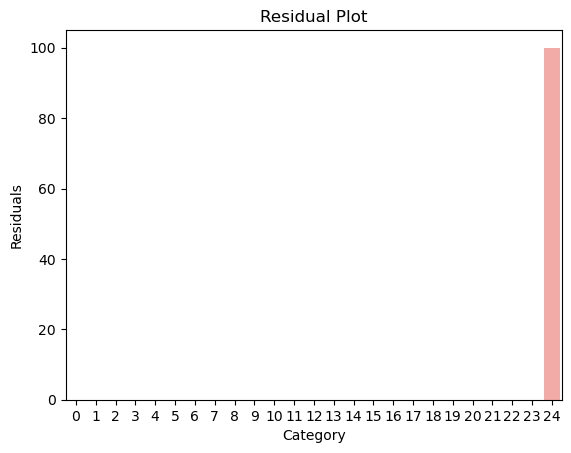

[1.1613307e-06, 2.215775e-05, 4.5170433e-05, 9.713448e-05, 0.00027947407, 0.0004703179, 0.0005078065, 0.000979609, 0.0011952423, 0.0013738524, 0.001443873, 0.0019590058, 0.005221042, 0.0054567955, 0.011217277, 0.014300303, 0.014604158, 0.03197096, 0.07343684, 0.07454907, 0.40652174, 1.1334598, 1.1649197, 15.535273, 81.5207]


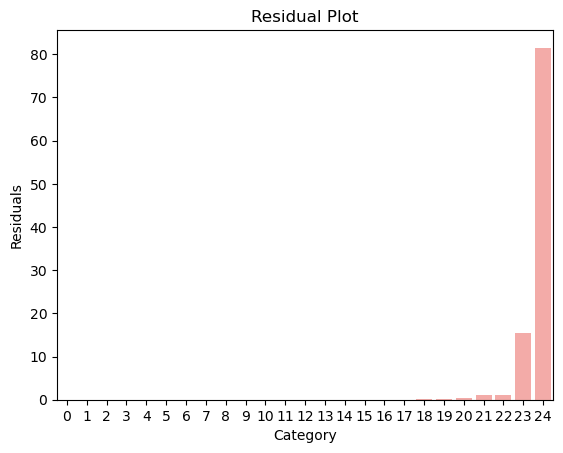

[0.00015886276, 0.00040200618, 0.00041661857, 0.0014893414, 0.0017989145, 0.0021537147, 0.004344454, 0.006699036, 0.015134957, 0.030081404, 0.039158262, 0.044577923, 0.1361145, 0.16046315, 0.20670074, 0.43211803, 0.9381221, 1.3313057, 1.7114079, 3.4750357, 5.2506304, 7.1943545, 8.214564, 10.447098, 60.355675]


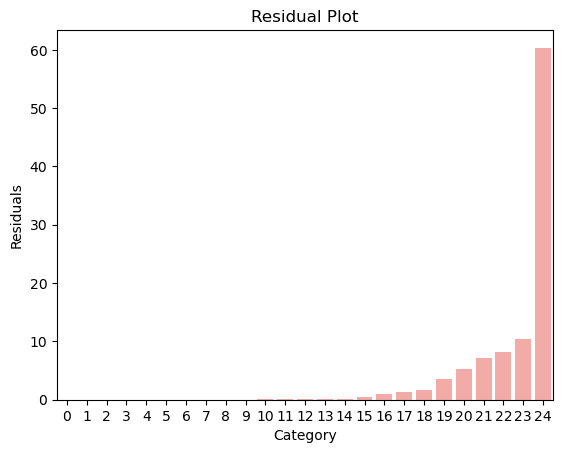

[1.3659468e-06, 9.161058e-05, 0.00031247968, 0.0012605883, 0.0037867548, 0.0040485817, 0.024723059, 0.029553143, 0.03181301, 0.035912022, 0.045917656, 0.049833734, 0.0760123, 0.10482311, 0.144017, 0.1670464, 0.40260983, 0.7887181, 0.955157, 1.222313, 1.6853817, 3.6732635, 9.837917, 11.176517, 69.53897]


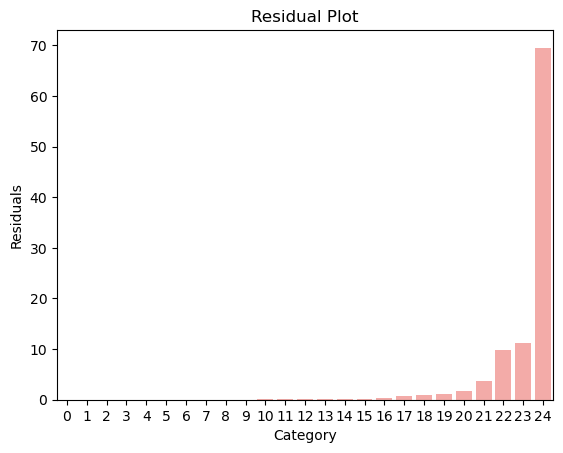

[3.7422637e-13, 5.747409e-12, 2.7650542e-11, 1.1740497e-10, 1.1775123e-10, 2.5079497e-10, 9.793051e-10, 8.1470235e-09, 8.179923e-09, 1.25733095e-08, 2.3332452e-08, 2.5241922e-08, 4.3380172e-08, 3.2999458e-07, 7.7064544e-07, 2.34066e-06, 5.734812e-06, 1.03025695e-05, 4.8340833e-05, 0.00032201092, 0.0007020813, 0.0011988714, 0.0014361343, 0.14151129, 99.85476]


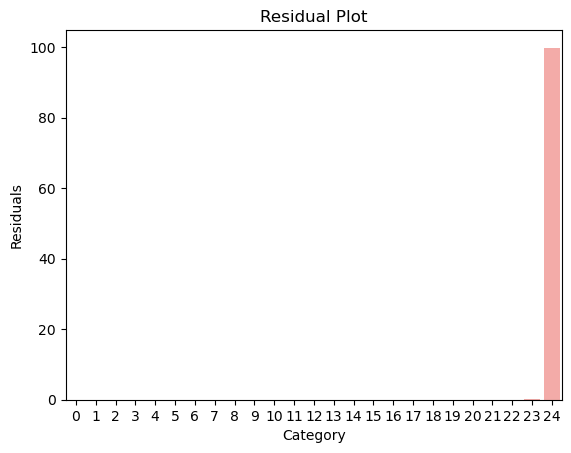

[5.4439874e-06, 4.181347e-05, 6.5490385e-05, 0.0005136883, 0.0016102031, 0.0020932504, 0.006129787, 0.018243078, 0.041403122, 0.048062872, 0.08854737, 0.14623643, 0.3092062, 0.41968986, 0.43609655, 0.45278612, 0.8552793, 2.1322815, 2.536701, 3.1590827, 4.3018823, 4.323372, 4.8863773, 26.641188, 49.193104]


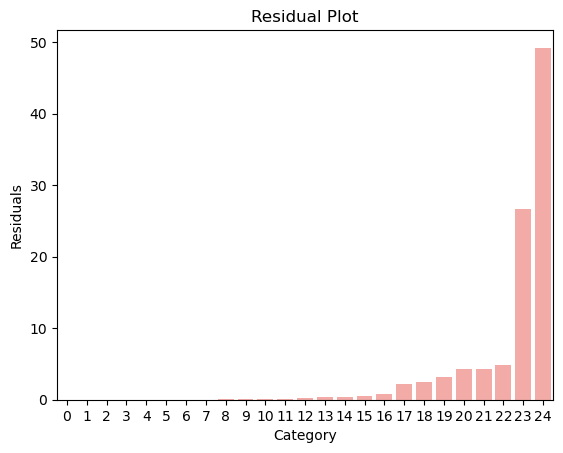

[0.035327353, 0.0840186, 0.14023648, 0.2001893, 0.22570395, 0.4181309, 0.44722787, 0.61054814, 0.9860436, 1.1073272, 1.672759, 1.8004351, 2.358669, 3.4836595, 4.0295167, 4.707284, 4.7666607, 4.8654, 5.0539265, 5.423043, 5.9712796, 6.4951124, 6.495379, 6.864117, 31.758]


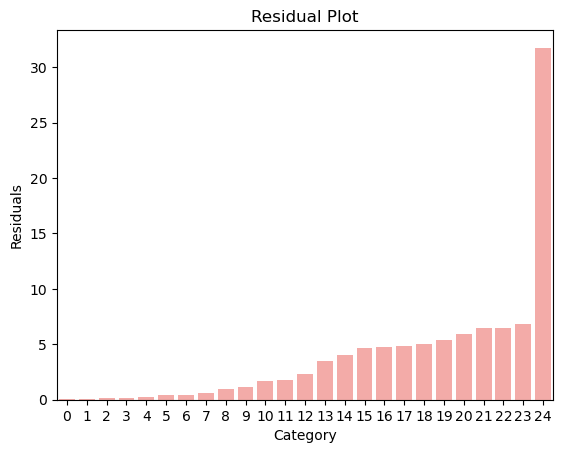

[1.8536635e-07, 7.113167e-07, 4.414428e-06, 9.502094e-06, 1.5859261e-05, 2.5036166e-05, 2.725587e-05, 0.00013967794, 0.00068684656, 0.0008331135, 0.0010033217, 0.0010238885, 0.0011606403, 0.0014079729, 0.0016688932, 0.002012693, 0.004218764, 0.0136979595, 0.027333302, 0.043822728, 0.04392811, 0.13868783, 0.65950483, 0.6707167, 98.38807]


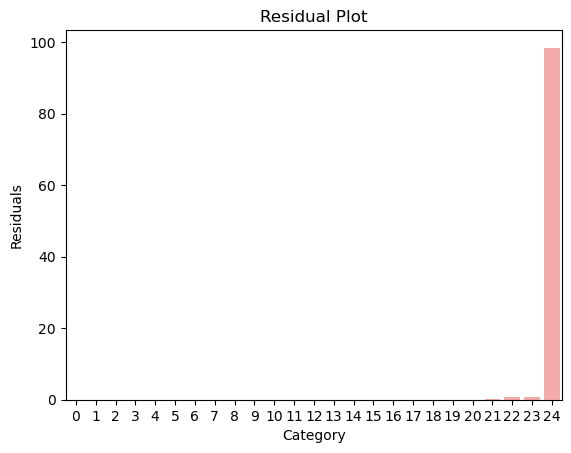

[4.496702e-15, 4.86703e-15, 2.068258e-14, 1.7282147e-12, 2.186502e-12, 1.1035524e-11, 1.480165e-11, 3.5202914e-11, 1.1339563e-10, 7.5951284e-10, 2.3555926e-09, 1.4614196e-08, 1.5877909e-08, 2.4062452e-08, 3.7746748e-08, 6.013304e-08, 9.885108e-08, 1.2973497e-07, 1.3915503e-07, 1.6021453e-06, 1.974062e-06, 2.7599568e-05, 3.7064474e-05, 0.0007245811, 99.999214]


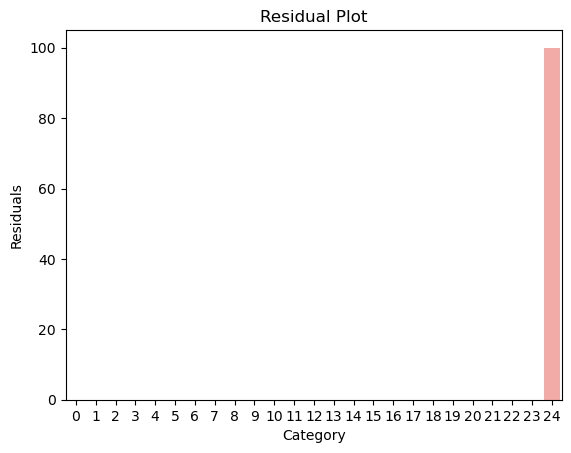

[3.1860372e-11, 6.222925e-11, 1.4079009e-09, 8.509715e-09, 8.438504e-08, 1.2274954e-07, 1.9044668e-07, 3.2810783e-07, 2.578121e-06, 3.3690003e-06, 4.059553e-06, 4.3470292e-05, 8.213072e-05, 8.88221e-05, 0.00016836725, 0.00017374309, 0.0004009867, 0.00062374864, 0.00071489264, 0.0020912706, 0.003548189, 0.006276581, 0.011019859, 0.01179758, 99.96296]


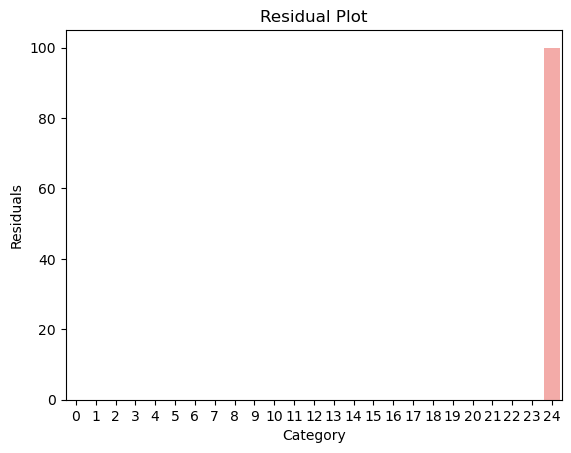

[1.5056972e-07, 2.5534922e-07, 1.5141246e-06, 5.898234e-06, 4.5917823e-05, 6.0030805e-05, 0.000105916966, 0.00012360743, 0.0001551818, 0.00019645365, 0.00034554303, 0.00048240318, 0.0015806623, 0.0016685206, 0.0028385604, 0.0037000626, 0.004785735, 0.015970139, 0.017030613, 0.020624956, 0.045466457, 0.06543711, 0.13402586, 0.19476414, 99.49059]


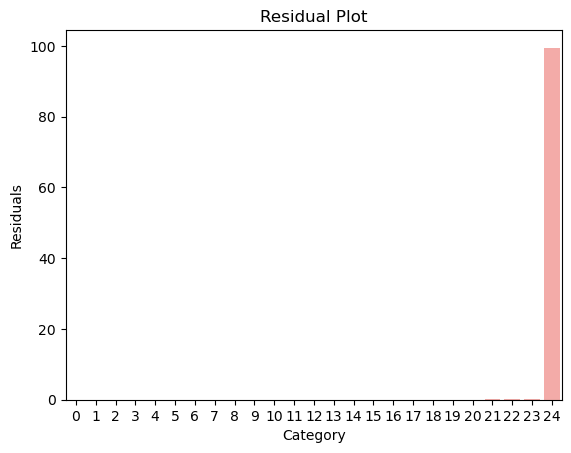

[1.6883841e-06, 2.4267604e-06, 4.890536e-06, 3.5316418e-05, 4.111348e-05, 0.00047285212, 0.00065071817, 0.00090934435, 0.0010569707, 0.0015127877, 0.0020717802, 0.003926358, 0.010181227, 0.017954292, 0.02033673, 0.023774572, 0.04129753, 0.07050847, 0.07325326, 0.07444459, 0.17822191, 0.30547237, 1.7677622, 1.9949975, 95.41111]


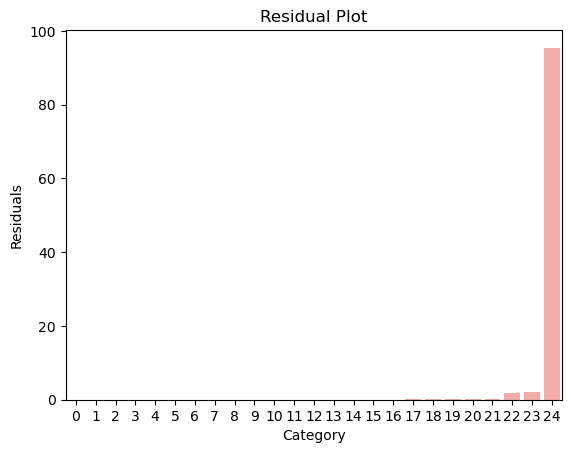

[5.236118e-07, 1.2651586e-06, 0.00014561442, 0.00055922393, 0.0010128941, 0.0028887102, 0.005413574, 0.014133625, 0.029488891, 0.033197537, 0.034084473, 0.045623377, 0.06481638, 0.07217714, 0.08430145, 0.097023904, 0.098753385, 0.10436386, 0.26930943, 0.28578714, 0.4007557, 0.7355495, 2.5475895, 33.188126, 61.8849]


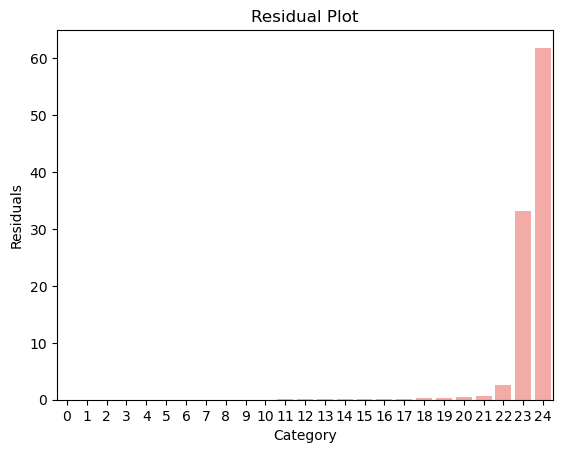

[2.8948332e-08, 4.6412733e-08, 2.0246009e-07, 1.3230491e-06, 3.062757e-06, 3.4653528e-06, 1.1954447e-05, 1.2029412e-05, 1.7118959e-05, 2.1888338e-05, 9.5844065e-05, 0.0009304398, 0.0012817937, 0.0064963875, 0.0073957113, 0.0109992605, 0.064888865, 0.075591445, 0.09332539, 0.09351725, 0.11636646, 0.17443779, 0.49491295, 1.0186677, 97.841034]


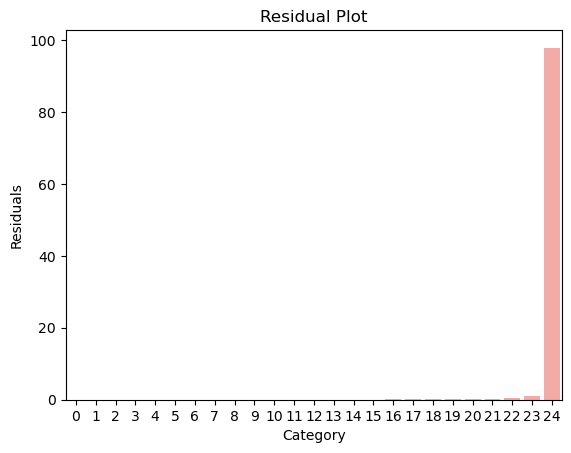

[4.3736528e-10, 7.183713e-10, 1.086108e-07, 1.1945843e-07, 1.7401798e-07, 3.5912782e-07, 4.119377e-07, 5.6623554e-07, 1.2794361e-06, 2.3626744e-06, 2.4774833e-06, 1.3741573e-05, 3.466099e-05, 8.679873e-05, 0.00013933654, 0.0004962479, 0.0010043315, 0.0013596071, 0.0014420768, 0.0014842082, 0.017002327, 0.019036077, 0.1598658, 0.16700664, 99.63102]


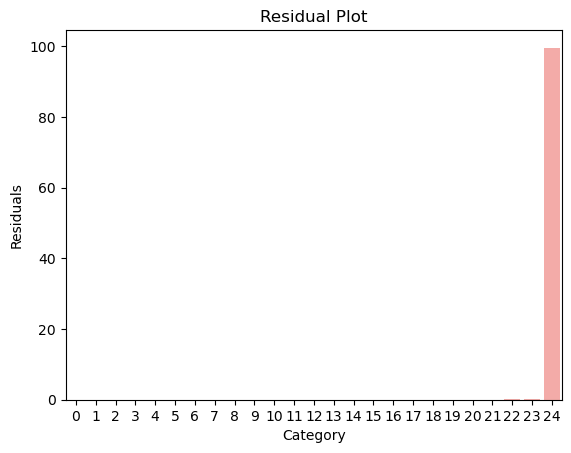

[4.3281803e-13, 2.2696088e-12, 4.168999e-12, 4.0616017e-09, 4.288532e-09, 9.883392e-09, 2.476731e-08, 1.9769257e-07, 3.3166492e-07, 9.478326e-07, 1.919124e-06, 3.775494e-06, 3.854522e-06, 7.5016956e-06, 1.080477e-05, 1.35420505e-05, 6.9460875e-05, 7.4143376e-05, 0.00014345981, 0.0001499747, 0.0002657028, 0.0005326022, 0.00075353746, 0.0023226666, 99.995636]


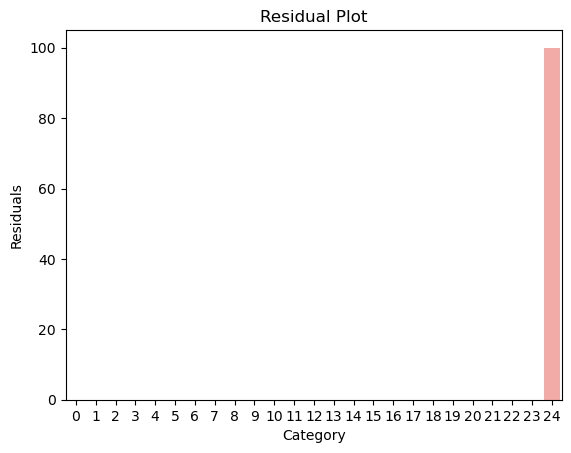

[0.00047670765, 0.0011261464, 0.0015384055, 0.0038652578, 0.005290921, 0.007252171, 0.008504594, 0.01424417, 0.017250758, 0.017741127, 0.024218254, 0.030252095, 0.043642666, 0.058668934, 0.064334795, 0.1582497, 0.17589162, 0.22627261, 0.24260706, 0.55502576, 0.57889116, 1.5823189, 19.101027, 19.413954, 57.667362]


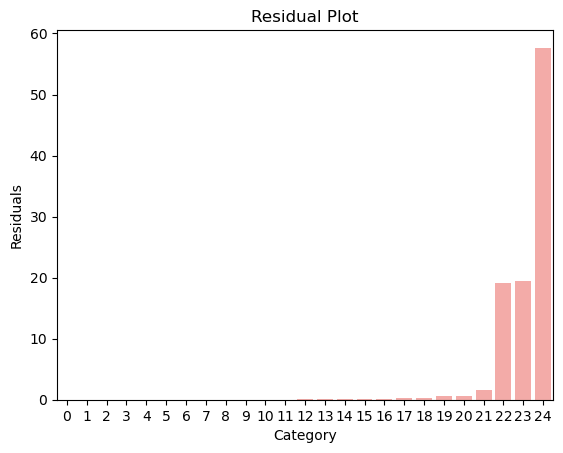

[6.309153e-05, 0.00013959743, 0.0017268942, 0.0030593718, 0.006753968, 0.013633909, 0.01709808, 0.026122205, 0.031037679, 0.06726066, 0.08110959, 0.08990309, 0.16826797, 0.21259594, 0.293607, 0.34029335, 0.45687723, 0.45821047, 0.60336095, 1.7877731, 2.7092562, 3.0045621, 4.526254, 5.62776, 79.47328]


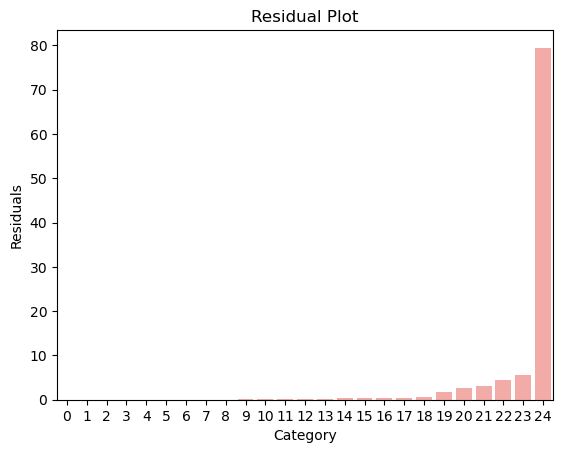

[1.4884056e-17, 9.342434e-16, 1.3017477e-15, 4.076476e-15, 9.289593e-15, 1.16970075e-14, 1.8671594e-14, 2.5924822e-14, 3.6766292e-14, 4.0045024e-13, 1.6342957e-12, 2.4889112e-12, 8.475628e-12, 1.1700237e-11, 1.3271523e-10, 2.6379685e-10, 4.651136e-10, 2.2773763e-08, 2.5139405e-08, 8.778967e-08, 3.4204873e-05, 4.3757747e-05, 7.821818e-05, 0.0018730304, 99.99796]


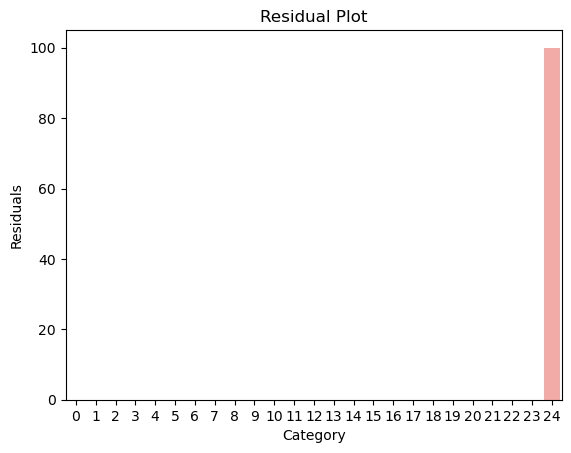

[1.0190015e-06, 3.3754527e-06, 1.3902336e-05, 4.406825e-05, 0.000111453075, 0.00013818986, 0.00062812143, 0.0016757349, 0.0054044244, 0.0067962282, 0.009441201, 0.013496168, 0.013943159, 0.038406897, 0.051313464, 0.07718337, 0.14211419, 0.4721996, 0.4736889, 1.0706645, 1.1114978, 3.0450892, 3.3887322, 9.147611, 80.9298]


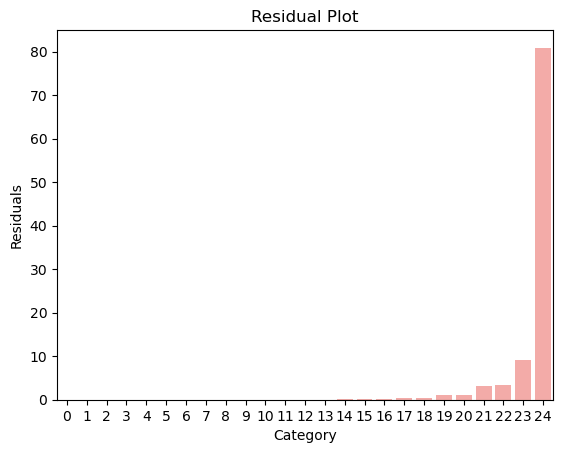

[1.6996886e-06, 2.920694e-06, 0.00010032373, 0.00042087722, 0.00063918054, 0.0009386999, 0.0011101759, 0.0014465345, 0.0017478782, 0.0022604323, 0.0076853344, 0.008009412, 0.013961219, 0.03151146, 0.0321282, 0.07562646, 0.09703353, 0.09749254, 0.10470885, 0.13076031, 0.26765332, 0.61114615, 0.92890096, 1.9499341, 95.63477]


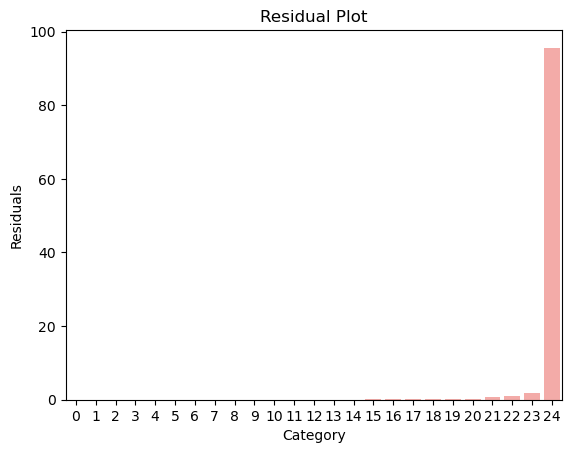

[3.2621865e-05, 0.00020823482, 0.0036689965, 0.011125182, 0.013500343, 0.01967772, 0.046814427, 0.047669157, 0.06105994, 0.19610202, 0.25692332, 0.393642, 0.56070936, 0.5847068, 0.66214997, 0.72456384, 1.0599803, 1.127968, 1.5054945, 1.9123489, 8.442057, 9.203686, 14.111357, 21.421076, 37.63348]


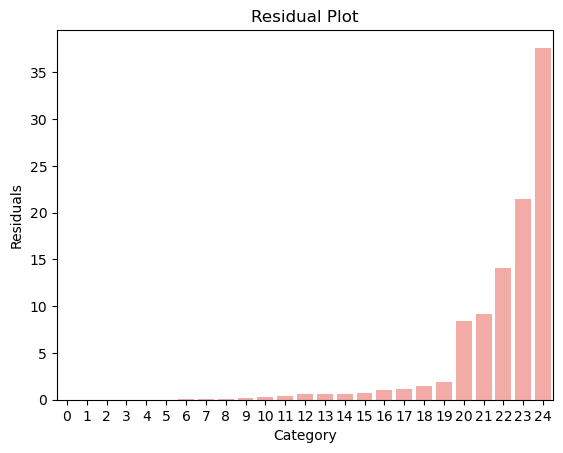

[1.8055953e-16, 8.1388685e-15, 1.6134305e-12, 3.6269176e-12, 7.861617e-12, 2.4661181e-11, 1.5309241e-10, 2.0388459e-10, 3.2681757e-09, 6.6378196e-09, 9.623767e-09, 1.112737e-08, 4.4723546e-08, 6.351314e-07, 1.1195463e-06, 1.3434351e-06, 8.544905e-06, 1.2318939e-05, 1.6303517e-05, 2.3932984e-05, 3.1724925e-05, 3.308505e-05, 0.00013808004, 0.00020406146, 99.999535]


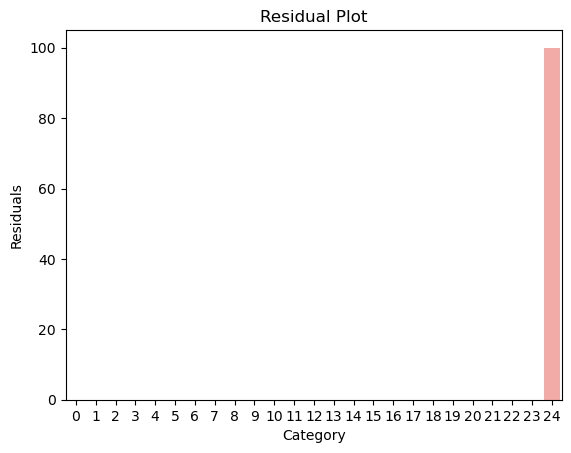

[5.236118e-07, 1.2651586e-06, 0.00014561442, 0.00055922393, 0.0010128941, 0.0028887102, 0.005413574, 0.014133625, 0.029488891, 0.033197537, 0.034084473, 0.045623377, 0.06481638, 0.07217714, 0.08430145, 0.097023904, 0.098753385, 0.10436386, 0.26930943, 0.28578714, 0.4007557, 0.7355495, 2.5475895, 33.188126, 61.8849]


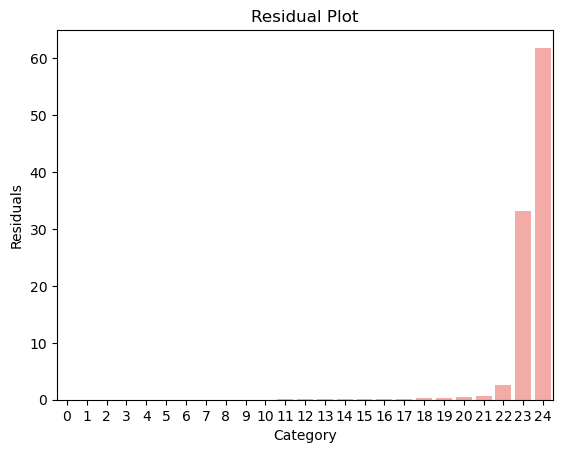

[0.00020791045, 0.003569978, 0.003663882, 0.004137142, 0.013454686, 0.017796842, 0.020519312, 0.025286935, 0.049256276, 0.051185563, 0.06757671, 0.06774157, 0.12778684, 0.13568777, 0.1379292, 0.17502582, 0.40495884, 0.7674661, 0.7968221, 1.9996643, 2.1206331, 2.148669, 2.408103, 16.116413, 72.33645]


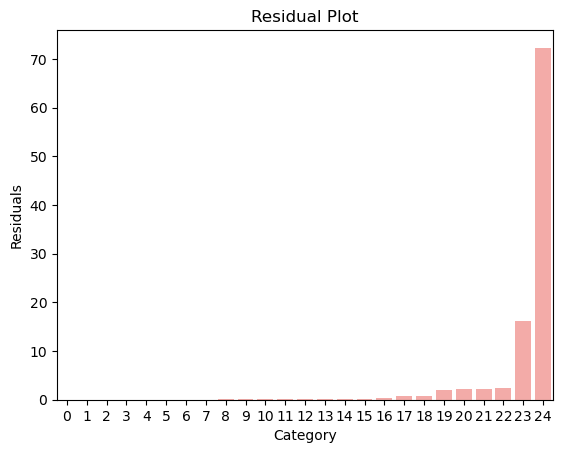

[3.7422637e-13, 5.747409e-12, 2.7650542e-11, 1.1740497e-10, 1.1775123e-10, 2.5079497e-10, 9.793051e-10, 8.1470235e-09, 8.179923e-09, 1.25733095e-08, 2.3332452e-08, 2.5241922e-08, 4.3380172e-08, 3.2999458e-07, 7.7064544e-07, 2.34066e-06, 5.734812e-06, 1.03025695e-05, 4.8340833e-05, 0.00032201092, 0.0007020813, 0.0011988714, 0.0014361343, 0.14151129, 99.85476]


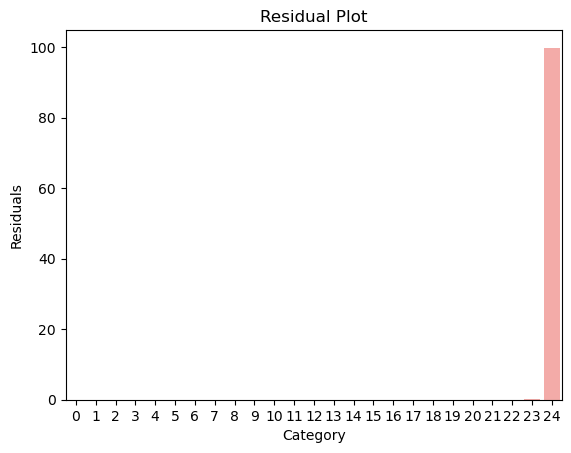

[1.8536635e-07, 7.113167e-07, 4.414428e-06, 9.502094e-06, 1.5859261e-05, 2.5036166e-05, 2.725587e-05, 0.00013967794, 0.00068684656, 0.0008331135, 0.0010033217, 0.0010238885, 0.0011606403, 0.0014079729, 0.0016688932, 0.002012693, 0.004218764, 0.0136979595, 0.027333302, 0.043822728, 0.04392811, 0.13868783, 0.65950483, 0.6707167, 98.38807]


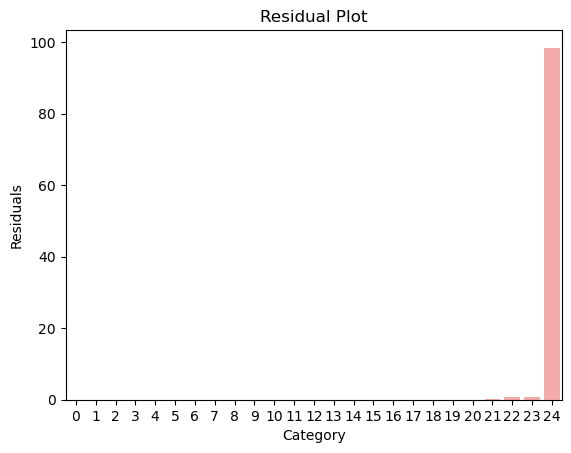

[5.1373822e-18, 9.2671837e-17, 3.4517673e-14, 1.904046e-13, 3.166555e-13, 9.77562e-12, 4.912468e-10, 8.088412e-09, 1.3926084e-08, 2.4379485e-08, 4.0406285e-08, 4.943982e-08, 9.41918e-08, 3.5657487e-07, 6.278732e-07, 1.009872e-06, 1.0264603e-06, 1.1009979e-06, 1.1275524e-06, 1.3610714e-06, 0.00010220131, 0.00010291127, 0.000302411, 0.041139863, 99.95834]


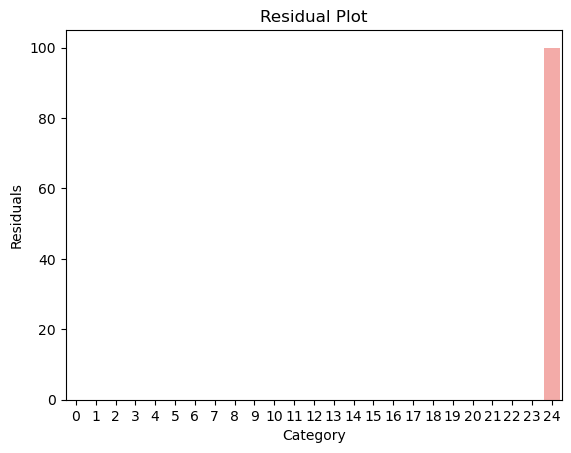

[5.1195912e-15, 1.6788093e-14, 2.0642305e-14, 6.543041e-14, 9.1217886e-14, 1.2005659e-12, 3.381074e-12, 4.686304e-11, 2.3486024e-10, 2.8025574e-10, 3.8750197e-10, 4.4213785e-10, 1.0327239e-09, 1.5688968e-09, 4.762796e-09, 7.574663e-09, 7.460676e-08, 9.155494e-08, 1.6108437e-07, 1.9188002e-07, 8.112188e-07, 1.091404e-06, 1.2817126e-06, 0.0038190265, 99.99617]


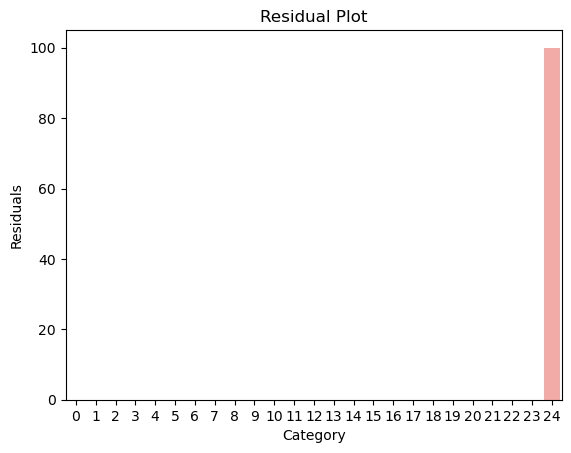

[2.1902775e-05, 2.8548902e-05, 0.00017395473, 0.00019318584, 0.00029340884, 0.0013673626, 0.0014298767, 0.003697143, 0.011301222, 0.011515825, 0.018279048, 0.018906286, 0.024216173, 0.037913803, 0.042351462, 0.06761713, 0.12732902, 0.20460163, 0.20770158, 0.44170272, 0.4672655, 1.2710439, 1.4568964, 3.1150656, 92.46909]


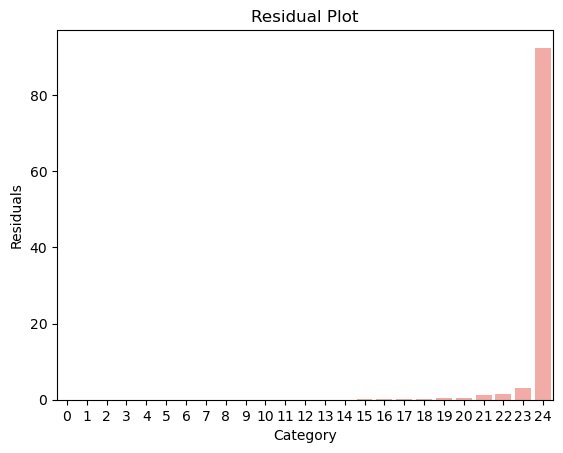

[1.8861206e-07, 6.0121926e-07, 1.201639e-06, 1.7016239e-06, 3.2827388e-06, 0.00010278418, 0.00015127083, 0.00017101387, 0.00023240638, 0.0004772473, 0.0007650582, 0.0012649384, 0.0022036377, 0.004344004, 0.0052796113, 0.007723528, 0.01035536, 0.01221933, 0.027834935, 0.054273702, 0.06115396, 0.3490857, 0.9432529, 2.6901147, 95.82899]


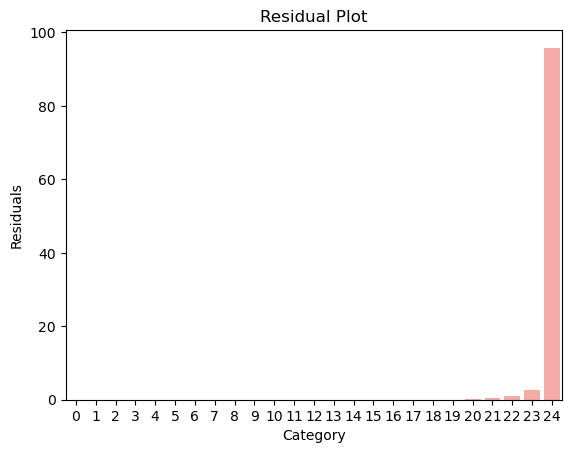

[1.8055953e-16, 8.1388685e-15, 1.6134305e-12, 3.6269176e-12, 7.861617e-12, 2.4661181e-11, 1.5309241e-10, 2.0388459e-10, 3.2681757e-09, 6.6378196e-09, 9.623767e-09, 1.112737e-08, 4.4723546e-08, 6.351314e-07, 1.1195463e-06, 1.3434351e-06, 8.544905e-06, 1.2318939e-05, 1.6303517e-05, 2.3932984e-05, 3.1724925e-05, 3.308505e-05, 0.00013808004, 0.00020406146, 99.999535]


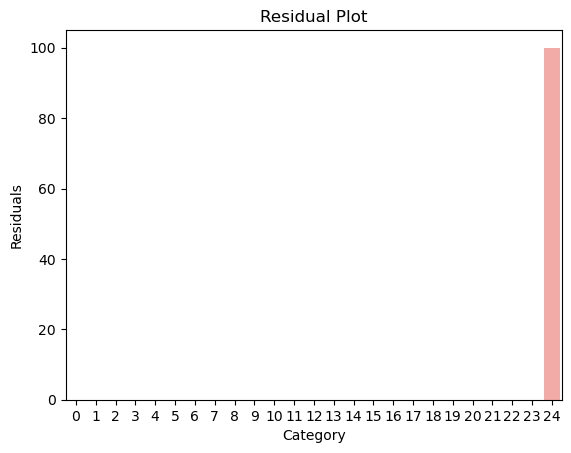

[6.42159e-05, 0.00028823546, 0.0012657685, 0.00334121, 0.0039044116, 0.013643731, 0.01958903, 0.035853695, 0.043972373, 0.0600993, 0.06763673, 0.0894896, 0.096732445, 0.13452485, 0.14616363, 0.1593781, 0.17864376, 0.5352341, 0.87319964, 0.8800985, 1.108306, 1.3490119, 4.039774, 24.238718, 65.92106]


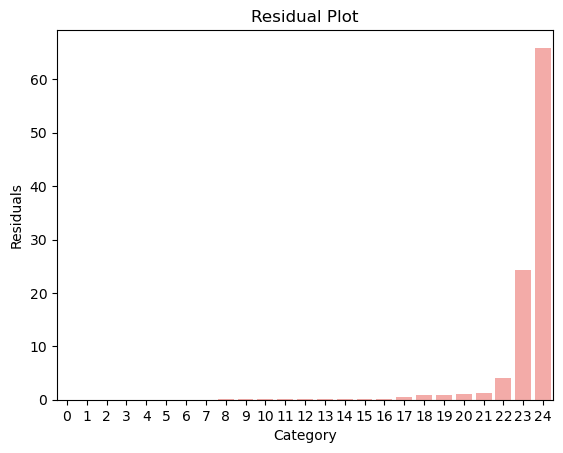

[6.360236e-08, 1.037172e-07, 1.5296115e-06, 2.4720037e-05, 7.0745555e-05, 0.00011328118, 0.00027424833, 0.0002972546, 0.0007276931, 0.00095559715, 0.0020299992, 0.004618585, 0.0050908374, 0.0073111304, 0.013547126, 0.0143369995, 0.014951148, 0.030508094, 0.034181017, 0.12696387, 0.16050562, 0.37726, 1.2900001, 41.485233, 56.430996]


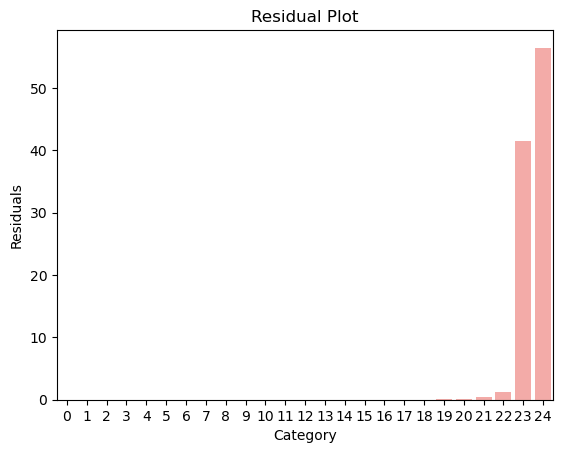

[1.6493794e-05, 5.836092e-05, 0.00037936235, 0.000823516, 0.0022895087, 0.004187623, 0.016427089, 0.023081953, 0.025881667, 0.028381081, 0.14627418, 0.22307807, 0.2593929, 0.2650041, 0.40673274, 0.47674835, 0.5592149, 0.8064783, 1.4577489, 1.6017787, 2.0321128, 2.5494723, 3.741404, 6.272544, 79.10049]


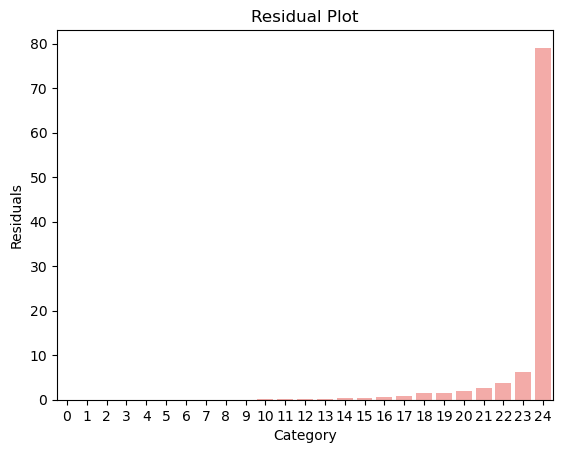

[1.8055953e-16, 8.1388685e-15, 1.6134305e-12, 3.6269176e-12, 7.861617e-12, 2.4661181e-11, 1.5309241e-10, 2.0388459e-10, 3.2681757e-09, 6.6378196e-09, 9.623767e-09, 1.112737e-08, 4.4723546e-08, 6.351314e-07, 1.1195463e-06, 1.3434351e-06, 8.544905e-06, 1.2318939e-05, 1.6303517e-05, 2.3932984e-05, 3.1724925e-05, 3.308505e-05, 0.00013808004, 0.00020406146, 99.999535]


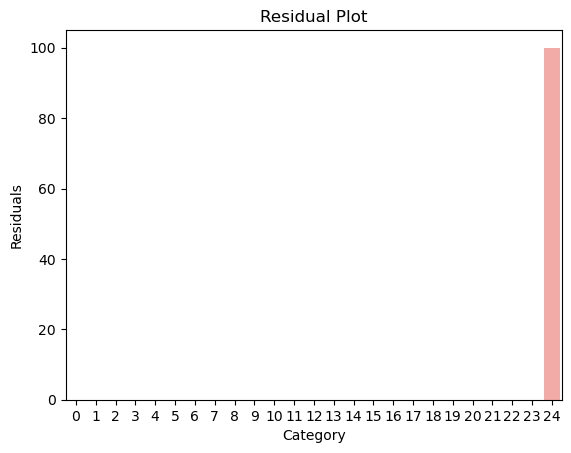

[5.622763e-09, 8.7243876e-08, 2.4083752e-07, 9.191033e-06, 3.8422142e-05, 0.00010274546, 0.00024620994, 0.00027468745, 0.0015413883, 0.0015473459, 0.0021005445, 0.0021109066, 0.0030204197, 0.003281735, 0.0058345846, 0.0062634344, 0.010649951, 0.013175968, 0.020940673, 0.022495968, 0.030080918, 0.0606921, 0.16098578, 0.18409568, 99.47051]


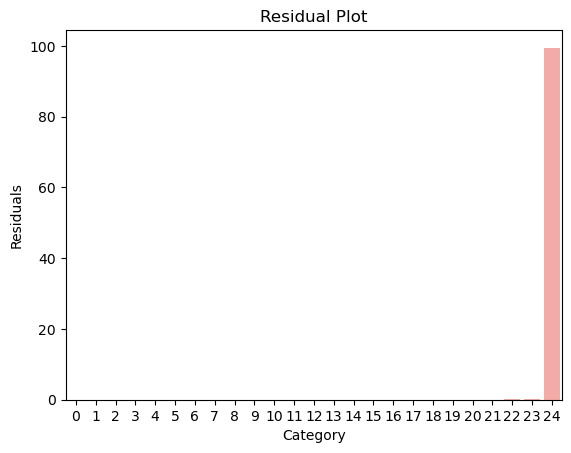

[9.007399e-09, 2.3481444e-08, 2.5928236e-06, 3.2758242e-06, 5.5938003e-06, 1.1550491e-05, 3.438557e-05, 8.708585e-05, 0.00014459163, 0.0001505992, 0.00019305885, 0.00030735717, 0.0006342919, 0.0026180279, 0.009149107, 0.013262957, 0.016586544, 0.016974488, 0.024906855, 0.02546992, 0.030417787, 0.07227762, 0.083798744, 1.2716768, 98.43129]


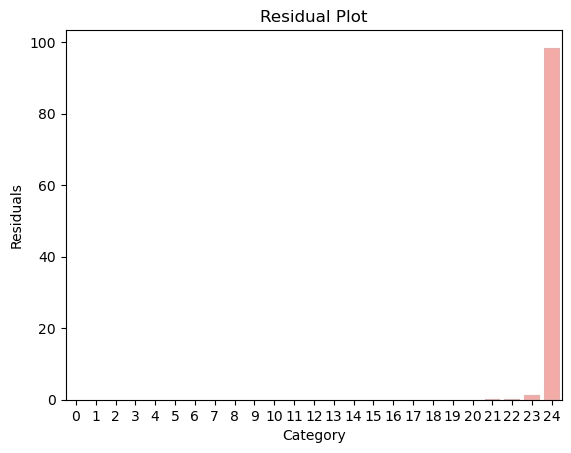

[0.0053445394, 0.0074128443, 0.03904062, 0.057007983, 0.059146278, 0.06465046, 0.115733504, 0.13285963, 0.29203385, 0.45642155, 0.4740245, 0.5094426, 0.61580956, 1.0065272, 1.8571979, 2.0202923, 2.3662539, 3.269944, 3.5033245, 6.8116055, 7.074444, 8.464651, 11.802138, 13.90629, 35.08841]


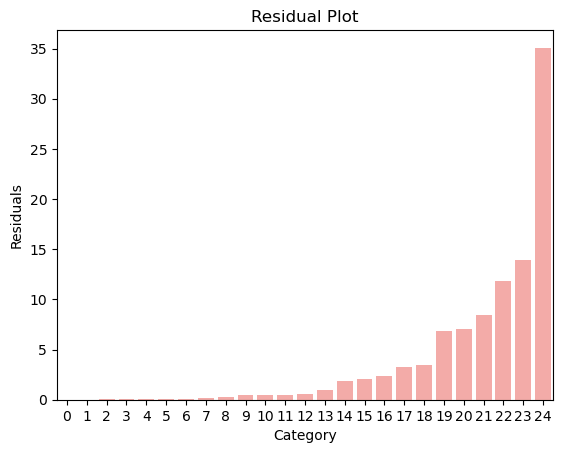

[0.0021559154, 0.0023290562, 0.020286284, 0.025696732, 0.029300796, 0.09020853, 0.11323817, 0.11625356, 0.13934831, 0.15321766, 0.15401654, 0.2540849, 0.4303803, 0.60088146, 0.7255939, 1.0138773, 1.1798704, 1.5735364, 1.6067643, 1.8797013, 3.387373, 3.5350013, 4.0559072, 6.0256286, 72.88536]


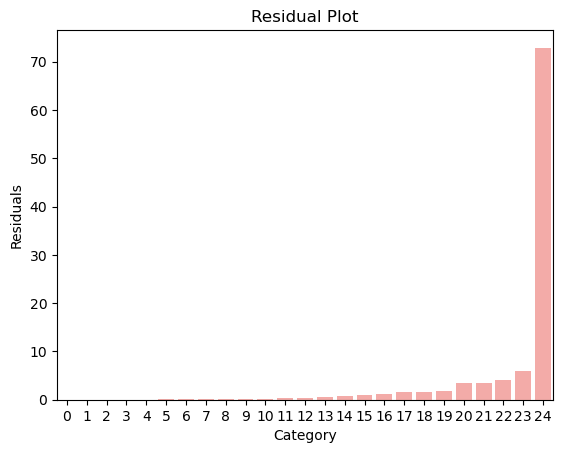

[1.0412644e-13, 1.0518723e-12, 1.1288518e-12, 6.2580366e-12, 6.5495935e-11, 1.15464895e-10, 3.2080835e-10, 5.50535e-10, 1.7984539e-09, 4.4663654e-08, 7.7660026e-08, 1.7504063e-07, 2.5578672e-07, 4.5657572e-07, 1.0669455e-06, 1.1228875e-06, 2.6103087e-06, 3.474275e-06, 1.0891046e-05, 5.9151313e-05, 0.00034396784, 0.0003642339, 0.002013292, 0.0025621962, 99.994644]


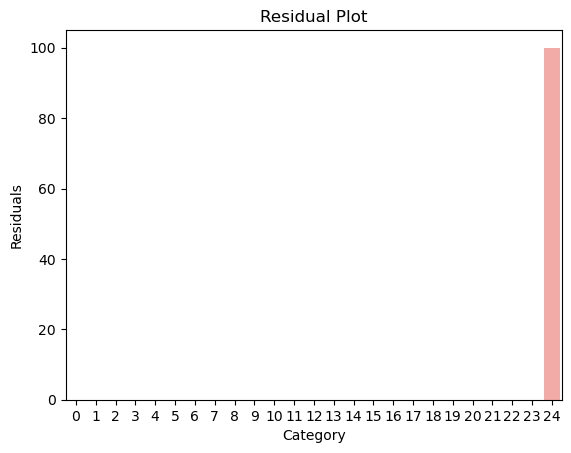

[2.1902775e-05, 2.8548902e-05, 0.00017395473, 0.00019318584, 0.00029340884, 0.0013673626, 0.0014298767, 0.003697143, 0.011301222, 0.011515825, 0.018279048, 0.018906286, 0.024216173, 0.037913803, 0.042351462, 0.06761713, 0.12732902, 0.20460163, 0.20770158, 0.44170272, 0.4672655, 1.2710439, 1.4568964, 3.1150656, 92.46909]


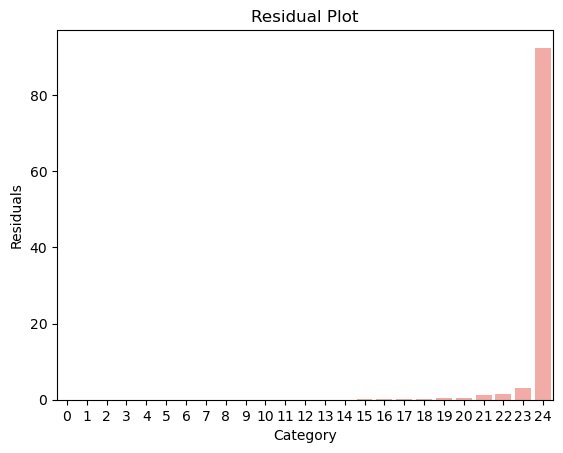

[1.1613307e-06, 2.215775e-05, 4.5170433e-05, 9.713448e-05, 0.00027947407, 0.0004703179, 0.0005078065, 0.000979609, 0.0011952423, 0.0013738524, 0.001443873, 0.0019590058, 0.005221042, 0.0054567955, 0.011217277, 0.014300303, 0.014604158, 0.03197096, 0.07343684, 0.07454907, 0.40652174, 1.1334598, 1.1649197, 15.535273, 81.5207]


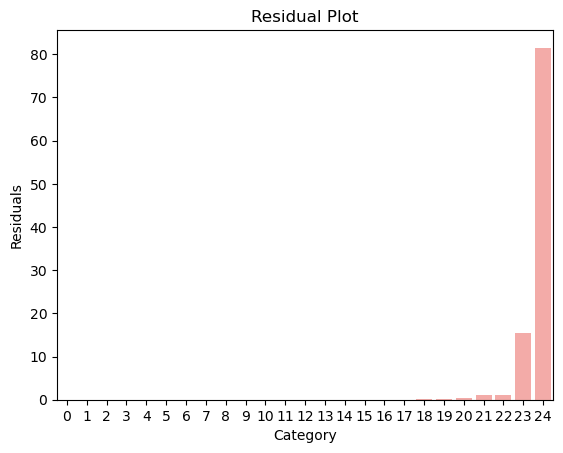

[0.0036208685, 0.011547035, 0.013047472, 0.043465696, 0.07378929, 0.10867404, 0.21153814, 0.3937732, 0.41691628, 0.4610925, 0.46941927, 0.5350139, 0.6111408, 0.8120996, 0.9346001, 1.0030019, 1.0580746, 1.0935705, 1.1630366, 1.2762432, 1.2776515, 1.4966685, 2.0141125, 2.7458613, 81.77204]


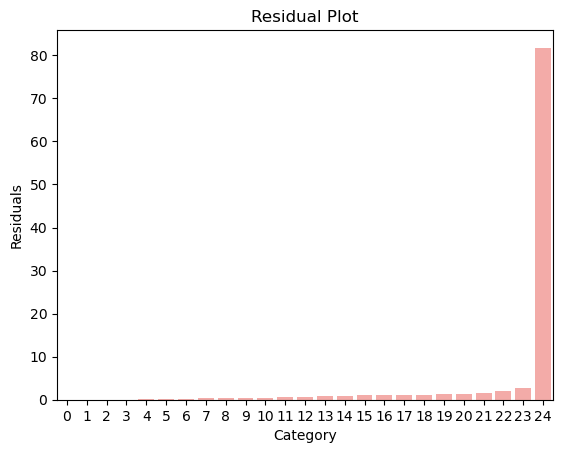

[3.1860372e-11, 6.222925e-11, 1.4079009e-09, 8.509715e-09, 8.438504e-08, 1.2274954e-07, 1.9044668e-07, 3.2810783e-07, 2.578121e-06, 3.3690003e-06, 4.059553e-06, 4.3470292e-05, 8.213072e-05, 8.88221e-05, 0.00016836725, 0.00017374309, 0.0004009867, 0.00062374864, 0.00071489264, 0.0020912706, 0.003548189, 0.006276581, 0.011019859, 0.01179758, 99.96296]


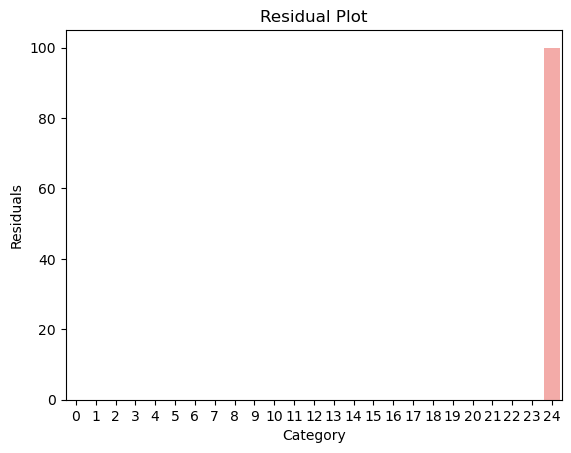

[0.0032524283, 0.009613908, 0.031761818, 0.04750102, 0.06576863, 0.06665253, 0.067951806, 0.089487605, 0.1924084, 0.21823135, 0.22958124, 0.27573615, 0.40885383, 0.79342264, 1.2295274, 1.9405525, 2.0305808, 2.1233222, 2.9925, 4.3508515, 4.822191, 7.831397, 21.249384, 22.09365, 26.835827]


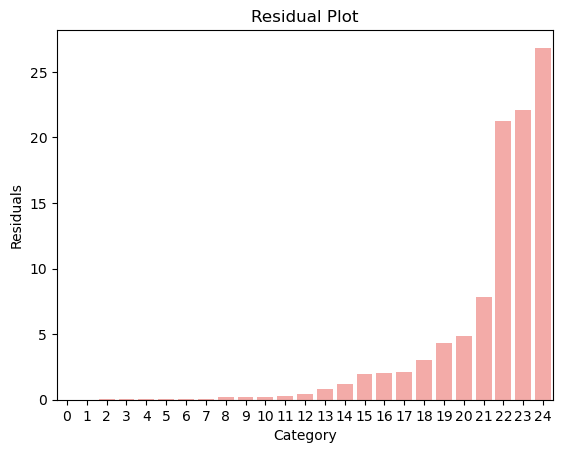

[2.5402394e-14, 8.881307e-13, 4.0630594e-12, 2.2312418e-11, 2.5882511e-11, 2.3795532e-10, 2.7346886e-10, 3.399074e-10, 1.1960632e-09, 1.2576569e-09, 2.6723959e-09, 7.487219e-09, 8.788158e-09, 1.9359402e-06, 2.7754395e-06, 1.8790482e-05, 2.3429848e-05, 2.4805095e-05, 2.9786022e-05, 0.00011927914, 0.00017727782, 0.00018097907, 0.00027488242, 0.00065390224, 99.9985]


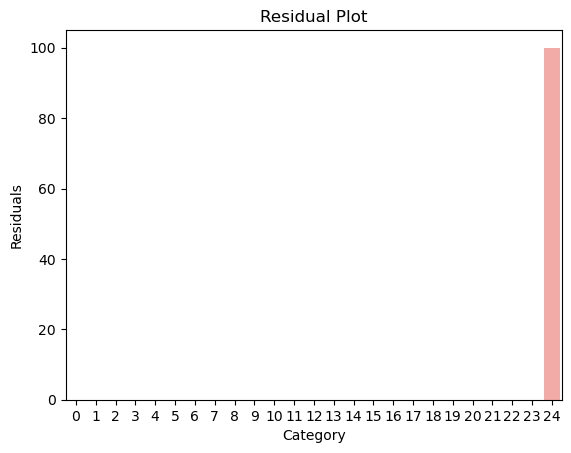

[6.2265156e-07, 1.7699276e-05, 2.9741628e-05, 0.00018388133, 0.00034162658, 0.0005045198, 0.00053890917, 0.00088723074, 0.0015125212, 0.0016880428, 0.0017693033, 0.0021232653, 0.0022936591, 0.0027504019, 0.0040820125, 0.008682851, 0.010324129, 0.013691043, 0.024856519, 0.036155403, 0.058035024, 0.13139735, 0.14285195, 0.22023399, 99.33506]


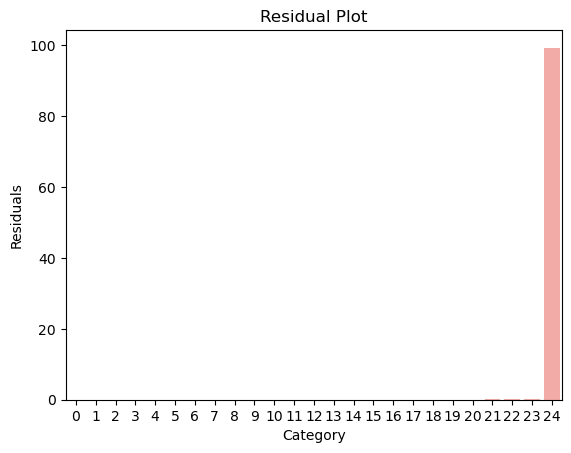

[0.0, 2.6902324e-36, 1.1502119e-35, 3.7096486e-33, 4.1878838e-32, 4.3952983e-32, 7.847731e-32, 9.945318e-32, 1.2855868e-31, 3.630886e-31, 1.5913457e-29, 2.7785527e-29, 6.421459e-29, 2.8477135e-28, 1.9563775e-25, 1.7913548e-23, 2.785077e-23, 5.790489e-23, 7.2372346e-23, 4.1030986e-22, 6.378197e-22, 1.2390485e-21, 8.839291e-21, 5.4208736e-15, 100.0]


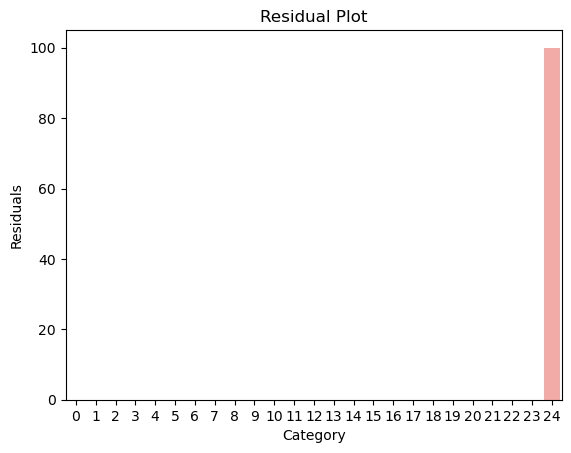

[6.360236e-08, 1.037172e-07, 1.5296115e-06, 2.4720037e-05, 7.0745555e-05, 0.00011328118, 0.00027424833, 0.0002972546, 0.0007276931, 0.00095559715, 0.0020299992, 0.004618585, 0.0050908374, 0.0073111304, 0.013547126, 0.0143369995, 0.014951148, 0.030508094, 0.034181017, 0.12696387, 0.16050562, 0.37726, 1.2900001, 41.485233, 56.430996]


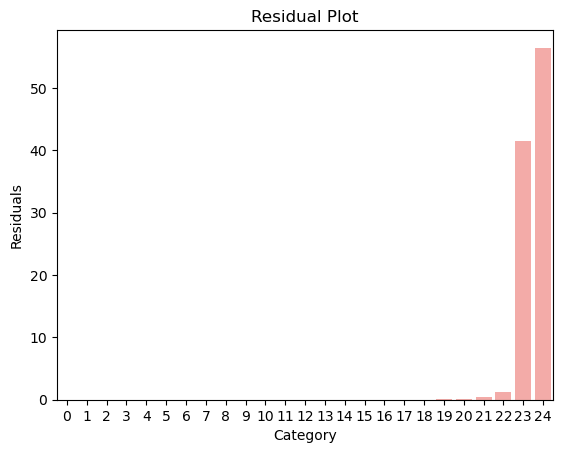

[1.4344159e-09, 1.45159635e-08, 1.7657506e-07, 1.0057532e-06, 1.5861581e-06, 1.4776056e-05, 1.6078171e-05, 0.00010399074, 0.00013708921, 0.00028470825, 0.00034625913, 0.0006597311, 0.00067974033, 0.00071615307, 0.0018505598, 0.002595988, 0.004062972, 0.004289361, 0.011567962, 0.02308934, 0.023845026, 0.06974229, 0.32247585, 0.68612564, 98.84738]


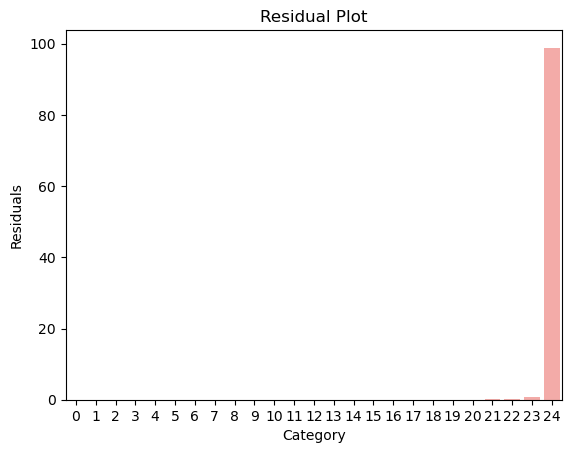

[1.4344159e-09, 1.45159635e-08, 1.7657506e-07, 1.0057532e-06, 1.5861581e-06, 1.4776056e-05, 1.6078171e-05, 0.00010399074, 0.00013708921, 0.00028470825, 0.00034625913, 0.0006597311, 0.00067974033, 0.00071615307, 0.0018505598, 0.002595988, 0.004062972, 0.004289361, 0.011567962, 0.02308934, 0.023845026, 0.06974229, 0.32247585, 0.68612564, 98.84738]


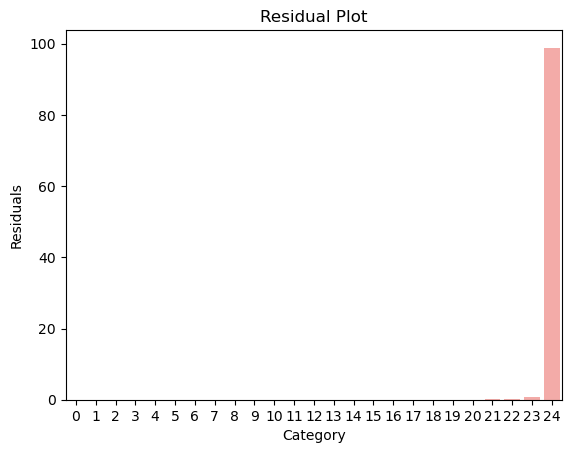

[3.3313572e-05, 5.2848776e-05, 0.00029559218, 0.00030924781, 0.0003234726, 0.00049306045, 0.00073710154, 0.0017659919, 0.014267904, 0.022527413, 0.025805376, 0.027933257, 0.05764656, 0.060363892, 0.07493511, 0.13400632, 0.13924019, 0.195538, 0.19777869, 0.27280915, 0.42219433, 0.44860625, 0.58684534, 1.0000646, 96.315445]


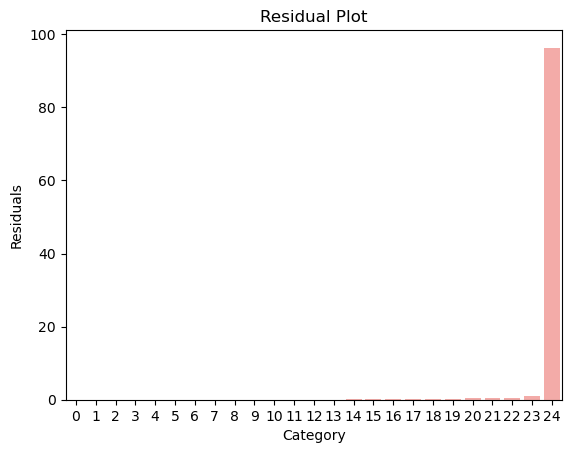

[0.00019497795, 0.0018386374, 0.0050807, 0.006459154, 0.0119909085, 0.018470267, 0.1382763, 0.14093325, 0.15719053, 0.21510595, 0.30117786, 0.32457548, 0.3702912, 0.3805871, 0.41393912, 1.0960321, 1.3726356, 1.8911444, 2.307427, 2.6087463, 3.5973706, 8.396183, 16.084497, 18.578892, 41.58096]


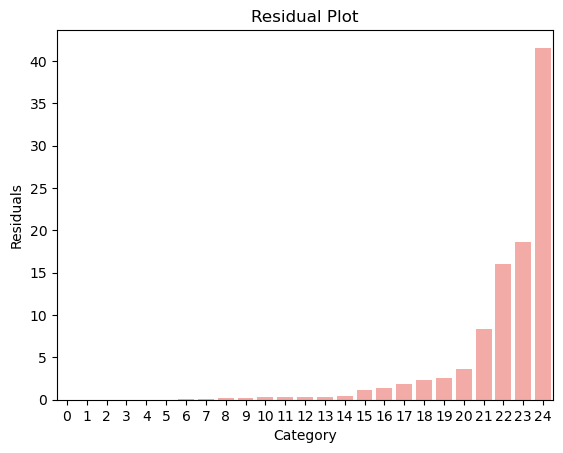

[1.7895678e-06, 2.5298395e-06, 4.279069e-06, 3.54216e-05, 0.0001579184, 0.00026592996, 0.00044834337, 0.0006653701, 0.0007726758, 0.0008274096, 0.0019416527, 0.002255609, 0.002785, 0.0028668032, 0.004173844, 0.015010105, 0.021309424, 0.022838708, 0.047439296, 0.052444357, 0.23575981, 0.34499547, 0.4875155, 3.2601337, 95.495346]


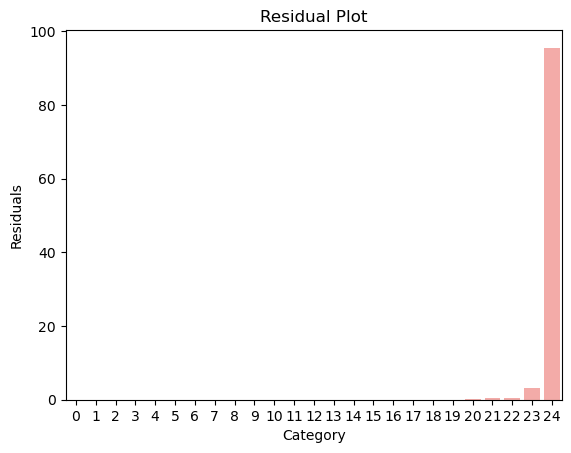

In [146]:
def test(f):
    for i in f:
        index = list(range(len(i)))
        i = sorted(i*100)
        print(i)
        sns.barplot(x=index, y=i, color="r")
        plt.xlabel('Category')
        plt.ylabel('Residuals')
        plt.title('Residual Plot')
        plt.show()
        
test(f)

In [87]:
titanic = sns.load_dataset('titanic')
print(titanic.head())

   survived  pclass     sex   age  sibsp  parch     fare embarked  class  \
0         0       3    male  22.0      1      0   7.2500        S  Third   
1         1       1  female  38.0      1      0  71.2833        C  First   
2         1       3  female  26.0      0      0   7.9250        S  Third   
3         1       1  female  35.0      1      0  53.1000        S  First   
4         0       3    male  35.0      0      0   8.0500        S  Third   

     who  adult_male deck  embark_town alive  alone  
0    man        True  NaN  Southampton    no  False  
1  woman       False    C    Cherbourg   yes  False  
2  woman       False  NaN  Southampton   yes   True  
3  woman       False    C  Southampton   yes  False  
4    man        True  NaN  Southampton    no   True  


In [104]:
# Sample list of values
values = [10, 25, 15, 30, 20]
index = [values = [10, 25, 15, 30, 20]

# Plotting the bar chart
sns.barplot(x=index, y=values)
# Plotting the bar chart

# Adding labels and title
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Bar Chart')

# Display the plot
plt.show()

SyntaxError: '[' was never closed (781682313.py, line 3)

<Axes: >

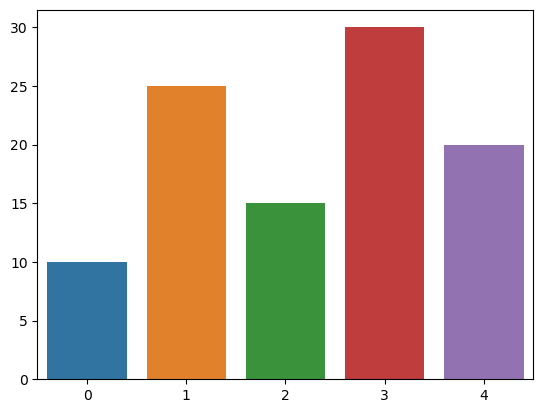

In [101]:
values = [10, 25, 15, 30, 20]

# Create a list of indices for x-axis
indices = list(range(len(values)))

# Plotting the bar chart
sns.barplot(x=indices, y=values)